# Определение стоимости автомобилей


**Описание проекта:**

Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

**Цель исследования:**
Построить модель, которая умеет её определять. В распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

**Ход исследования:**

* загрузка данных;
* предобработка данных;
* исследовательский анализ данных;
* корреляционный анализ данных;
* подготовка данных;
* исследование моделей;
* анализ важности признаков;
* финальное обучение моделей;
* проверка качества лучшей модели на тестовой выборке;
* оформление выводов

**Признаковое описание данных:**

* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

 **Целевой признак**
* `Price` — цена (евро)

**Файлы с данными:**

1.    **/datasets/autos.csv**

## Загрузка данных

In [1]:
#импортируем необходимые библиотеки
!pip install --upgrade -q scikit-learn
!pip install --upgrade -q phik
!pip install optuna -q
!pip install optuna-integration -q
!pip install lightgbm -q

import os

import pandas as pd
import numpy as np

import inflection

import textwrap

import copy

import phik

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder)

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.linear_model import (Ridge,
                                  Lasso, 
                                  ElasticNet)

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
                              
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

from xgboost import XGBRegressor

from catboost import CatBoostRegressor

import optuna
from optuna import distributions

from sklearn.metrics import root_mean_squared_error

import time

import shap

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#настроим отображение графиков
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
#считываем файлы
pth1_1 = '/datasets/autos.csv'
pth1_2 = 'autos.csv'


if os.path.exists(pth1_1):
    autos = pd.read_csv(pth1_1)
elif os.path.exists(pth1_2):
    autos = pd.read_csv(pth1_2)
else:
    print('Something is wrong with file autos.csv')

In [4]:
#посмотрим на данные в файле autos
autos.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Приведём названия столбцов к змеиному регистру с помощью `inflection.underscore`

In [5]:
autos.columns = [inflection.underscore(col) for col in autos.columns]
autos.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Необходимые библиотеки импортированы, данные загружены, названия столбцов приведены к змеиному регистру

## Предобработка данных

In [6]:
#функция, возвращающая базовую информацию о датафрейме
def df_basic_info(df):
    #df - датафрейм
    
    print(f'Названия столбцов\n\n{df.columns}')
    print('----------------------------------------------------------------')
    print('Основные параметры данных\n\n')
    df.info()
    print('----------------------------------------------------------------')
    print(f'Число уникальных значений признаков\n\n{df.nunique()}')
    print('----------------------------------------------------------------')
    print(f'Типы данных\n\n{df.dtypes.value_counts()}')
    print('----------------------------------------------------------------')
    print(f'Размер датафрейма\n\n{df.shape}')
    print('----------------------------------------------------------------')
    print(f'Базовые статистики\n\n{df.describe()}')
    print('----------------------------------------------------------------')
    print(f'Доля пропущенных значений\n\n{df.isna().mean().sort_values()}')
    print('----------------------------------------------------------------')
    print(f'Количество полных дубликатов\n\n{df.duplicated().sum()}')
    print('----------------------------------------------------------------')
    return df.head(10)

In [7]:
df_basic_info(autos)

Названия столбцов

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')
----------------------------------------------------------------
Основные параметры данных


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   regis

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Заметно, что в данных присутствует много признаков с пропущенными значениями. Проведём предобработку данных.

### Изменение типов данных

Приведём типы данных в столбцах к корректным/более оптимальным

In [8]:
#коррекция временных данных
cols_to_datetime = ['date_crawled', 'date_created', 'last_seen']
for col in cols_to_datetime:
    autos[col] = pd.to_datetime(autos[col], format='%Y-%m-%d %H:%M:%S')

#коррекция числовых данных
cols_to_int32 = autos.select_dtypes(include=['int64']).columns
autos[cols_to_int32] = autos[cols_to_int32].astype('int32')

### Обработка дубликатов

Видим в данных полные дубликаты. Удалим их - возможно, это ошибка сбора данных или системный сбой

In [9]:
autos.drop_duplicates(inplace=True)

Неявные дубликаты изучим чуть позже в разделе с EDA

### Предварительный анализ базовых статистик

Отметим наиболее значимые особенности при анализе базовых статистик признаков:
* `price`: выделяются нетривиальные минимальные и максимальные значения признака;
* `registration_year`: выделяются нетривиальные минимальные и максимальные значения;
* `power` - выделяются нетривиальные минимальные и максимальные значения;
* `registration_month` - странное количество месяцев;
* `repaired` - наибольшее количество пропущенных значений (около 20%);
* `number_of_pictures` - неинформативный признак, всего лишь одно значение

Более подробно изучим признаки в разделе с EDA

Проверим результат проведённых операций

In [10]:
df_basic_info(autos)

Названия столбцов

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')
----------------------------------------------------------------
Основные параметры данных


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int32         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int32         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int32         
 6   model               334660 non-null  ob

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


Таким образом, была проведена базовая предобработка данных. Отмечено наличие признаков с пропущенными значениями. Были удалены явные дубликаты. Изменены типы данных на более корректные/подходящие. Отмечены наиболее выделяющиеся особенности признакового описания. Более подробно изучим данные в разделе с EDA, в том числе неявные дубликаты

## EDA

In [11]:
#функция для корректной отрисовки названий столбцов
def wrap_labels(ax, width, break_long_words=False):
    #ax - график
    #width - ширина строки
    
    #создание списка названий столбцов c заданной шириной строки
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_xticks(ax.get_xticks(), labels=labels)

In [12]:
#функция для анализа категориальных признаков
def cat_feat_analysis(df, feat, df_name):
    #df - датафрейм
    #feat - категориальный признак
    #df_name - название датафрейма
    
    #отрисовка упорядоченной столбчатой диаграммы
    fig, ax = plt.subplots()
    print(f'Уникальные значения\n\n{df[feat].value_counts(normalize=True)}')
    print('-----------------------------------------------------')
    print(f'Базовые статистики\n\n{df[feat].describe()}')
    print('-----------------------------------------------------')
    sns.countplot(data=df,
                  x=feat,
                  order = df[feat].value_counts().index,
                  hue=feat,
                  legend=False,
                  palette='pastel',
                  ax=ax).set(title=f'Распределение признака {feat}\n'
                                   f'в датафрейме {df_name}', 
                             ylabel='Количество автомобилей')
    plt.xticks(rotation=90)
    
    #корректировка длины названия столбца
    wrap_labels(ax, 10)
    ax.figure

In [13]:
#функция для анализа количественных признаков
def quant_feat_analysis(df, feat, df_name):
    #df - датафрейм
    #feat - количественный признак
    #df_name - название датафрейма
    
    print(f'Базовые статистики\n\n{df[feat].describe()}')
    print('-----------------------------------------------------')
    fig, (ax_box, ax_hist) = plt.subplots(2,
                                          sharex=True,
                                          gridspec_kw = {'height_ratios': (.1, .9)})
    #отрисовка боксплота
    sns.boxplot(data=df, 
                x=feat,
                color='cadetblue',
                ax=ax_box)
    
    #отрисовка гистограммы
    sns.histplot(data=df,
                 x=feat,
                 bins=round(1 + np.log2(df.shape[0])),
                 kde=True,
                 color='cadetblue',
                 ax=ax_hist)
    
    ax_box.set(xlabel = '') 
    ax_box.set(title=f'Распределение признака {feat}\n в датафрейме {df_name}') 
    ax_hist.set(xlabel=feat)
    ax_hist.set(ylabel='Количество автомобилей')
    
    plt.show()

### date_crawled

Базовые статистики

count                  354365
unique                 271174
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: date_crawled, dtype: object
-----------------------------------------------------


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8268\3080325625.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(f'Базовые статистики\n\n{df[feat].describe()}')


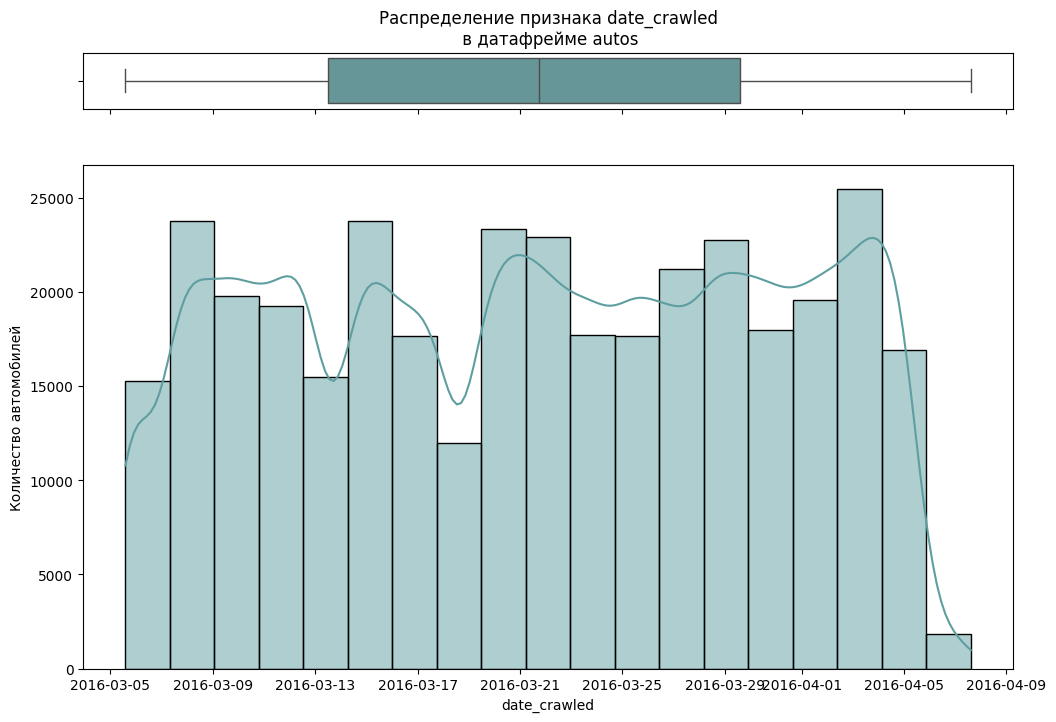

In [14]:
quant_feat_analysis(autos, 'date_crawled', 'autos')

Дата выгрузки анкеты из БД никак не влияет на стоимость автомобиля. Удалим данный столбец, перед этим создадим глубокую копию исходных данных

In [15]:
autos_copy = copy.deepcopy(autos)

autos.drop(['date_crawled'], axis=1, inplace=True)

### date_created

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8268\3080325625.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(f'Базовые статистики\n\n{df[feat].describe()}')


Базовые статистики

count                  354365
unique                    109
top       2016-04-03 00:00:00
freq                    13718
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: date_created, dtype: object
-----------------------------------------------------


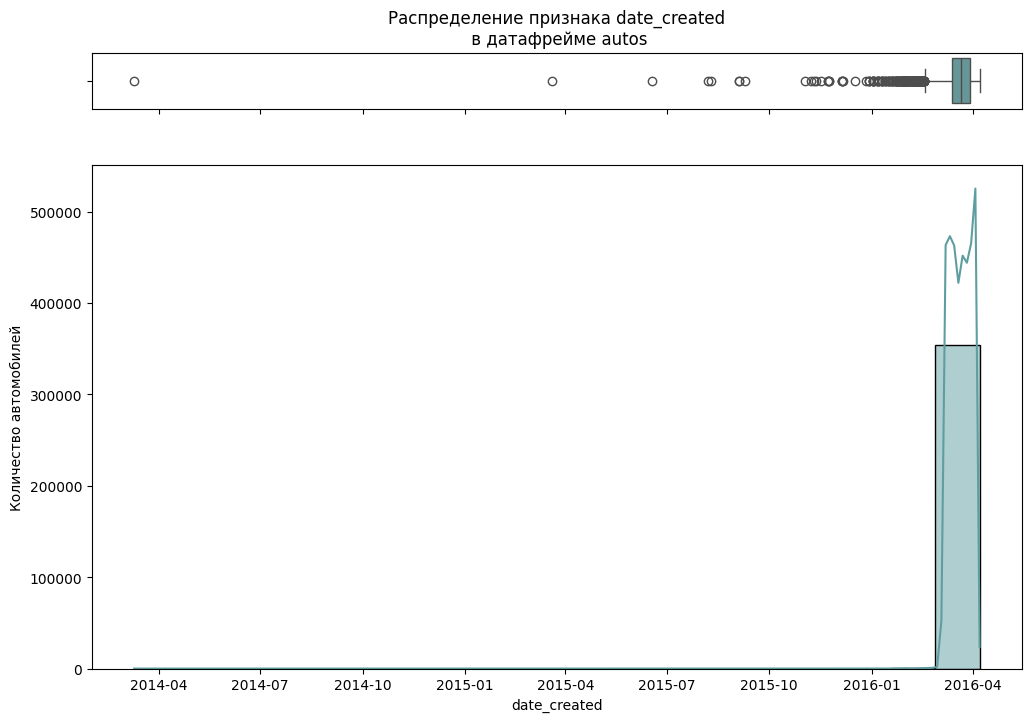

In [16]:
quant_feat_analysis(autos, 'date_created', 'autos')

In [17]:
#посмотрим, в какой отрезок времени было создано подавляющее большинство анкет
np.quantile(autos['date_created'], 0.0001)

numpy.datetime64('2016-01-08T20:56:49.919999999')

Данный столбец также является малоинформативным. 75% анкет были созданы в одном месяце 2016 года, 99.99% анкет были созданы менее чем за половину 2016 года. В течение этого срока вряд ли цены на автомобили изменились сильно - данный столбец можно удалить

In [18]:
autos.drop(['date_created'], axis=1, inplace=True)

### last_seen

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8268\3080325625.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(f'Базовые статистики\n\n{df[feat].describe()}')


Базовые статистики

count                  354365
unique                 179150
top       2016-04-06 13:45:54
freq                       17
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: last_seen, dtype: object
-----------------------------------------------------


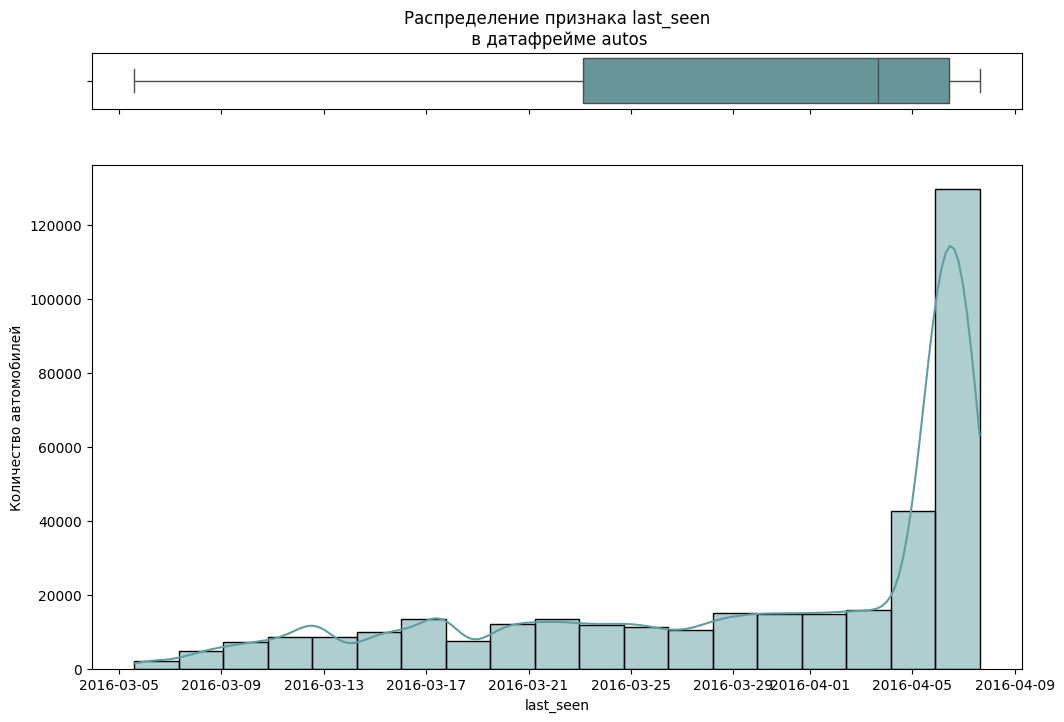

In [19]:
quant_feat_analysis(autos, 'last_seen', 'autos')

Последняя активность пользователей закономерно распространяется на небольшом интервале времени в 1 месяц, при этом около половины пользователей совершали последнюю активность в течение последней недели от точки отсчёта. Так как нам неизвестно, что конкретно подразумевается под последней  активностью (заход на сайт/редактирование анкеты/добавление анкеты/...), совершались ли какие-то изменения пользователями в анкетах уже после их создания; невозможно оценить, корректировалась ли анкета в момент последней активности пользователя на сайте или пользователь просто зашёл на сайт - то наиболее логичным вариантом является удаление данного столбца исходя из предположения, что стоимость автомобиля не зависит от последней активности пользователя

In [20]:
autos.drop(['last_seen'], axis=1, inplace=True)

### number_of_pictures

Уникальные значения

0    1.0
Name: number_of_pictures, dtype: float64
-----------------------------------------------------
Базовые статистики

count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64
-----------------------------------------------------


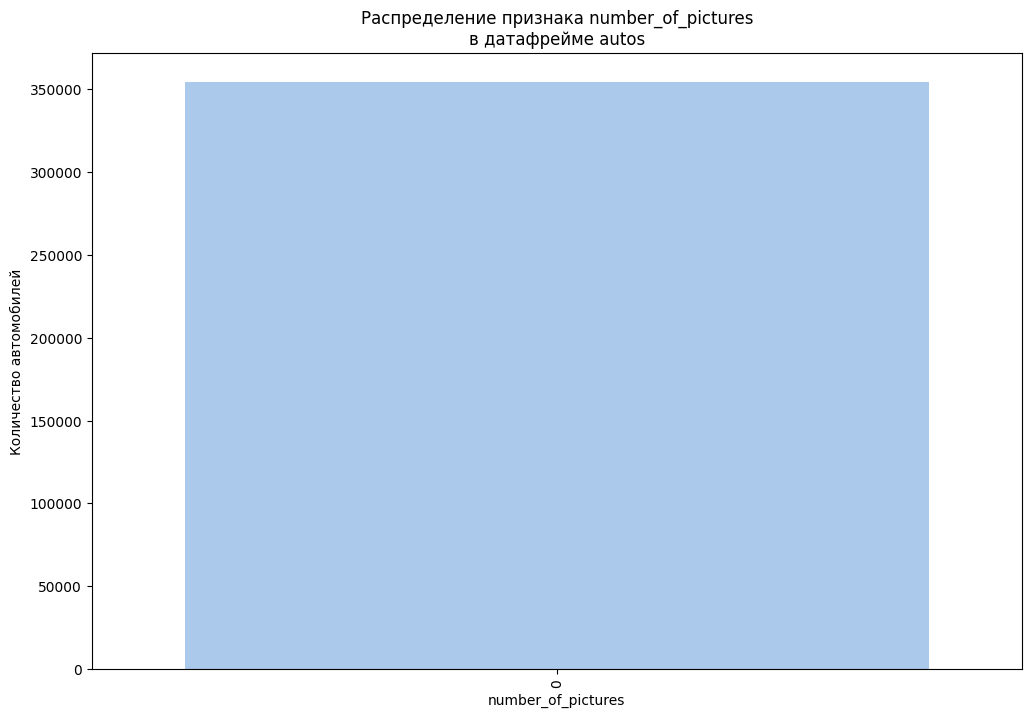

In [21]:
cat_feat_analysis(autos, 'number_of_pictures', 'autos')

Данный признак является неинформативным ввиду единственного значения. Удалим его

In [22]:
autos.drop(['number_of_pictures'], axis=1, inplace=True)

### registration_year, reg_year_group

Пропущенные значения в данном признаке отсутствуют. Наблюдаем некоторое количество аномальных значений. Сначала посмотрим на записи, где год регистрации указан позднее 2016

In [23]:
autos.query('registration_year > 2016')['registration_year'].value_counts()

2017    10441
2018     3959
9999       26
2019       25
5000       17
3000        7
6000        5
2500        4
7000        4
4000        3
9000        3
8000        2
5555        2
2222        2
2800        2
4500        2
5911        2
3700        1
3500        1
2900        1
8500        1
4100        1
9450        1
5900        1
6500        1
7100        1
5300        1
7800        1
8888        1
8200        1
9996        1
8455        1
2290        1
2066        1
5600        1
4800        1
3800        1
3200        1
9229        1
2200        1
7500        1
Name: registration_year, dtype: int64

Удалим данные записи - все временные признаки указывают на окончание сбора данных 2016-м годом, поэтому анкеты с более поздним годом являются нерелевантными. 

In [24]:
autos.query('registration_year <= 2016', inplace=True)

Также посмотрим на старые автомобили. За отсечку возьмём 1950 год

In [25]:
autos.query('registration_year < 1950')['registration_year'].value_counts()

1910    101
1000     37
1937     11
1938      8
1929      7
1800      5
1500      5
1234      4
1945      4
1943      4
1935      4
1942      3
1948      3
1930      3
1932      3
1933      3
1934      3
1111      3
1936      3
1940      2
1300      2
1600      2
1947      2
1944      2
1941      2
1923      2
1928      2
1915      1
1200      1
1001      1
1927      1
1255      1
1253      1
1602      1
1949      1
1925      1
1920      1
1931      1
1946      1
1039      1
1919      1
1400      1
1688      1
Name: registration_year, dtype: int64

Видим как абсолютно нереальные значения (1400, 1688, 1039), так и пограничные (1945, 1940, 1935). Посмотрим, насколько старые автомобили вообще могут продаваться на автомобильных сайтах. Например, [на среднестатистическом сайте продаж автомобилей](https://auto.ru/mag/article/oldcarsfebautoru/?utm_referrer=https%3A%2F%2Fyandex.ru%2F) встречается немало автомобилей, выпущенных в 20-х годах XX века, есть даже экземпляр 1904 года выпуска. Нельзя исключать того, что наш сайт может частично специализироваться на продаже раритетных автомобилей.

При этом абсолютно нереальным кажется продажа 101 автомобиля 1910 года выпуска. Конвейерное производство автомобилей в США было внедрено [в 1913 году](https://ecfor.ru/wp-content/uploads/2023/03/avtomobilizatsiya-v-rossii-i-stranah-mira.pdf), в Европе только [в 1924 году](https://ecfor.ru/wp-content/uploads/2023/03/avtomobilizatsiya-v-rossii-i-stranah-mira.pdf). Возьмём за временную отсечку 1915 год, анкеты с более старыми автомобилями удалим

In [26]:
autos.query('registration_year >=1915', inplace=True)
autos['registration_year'].value_counts()[:30]

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
2003    19762
2004    19611
2002    19091
1998    17899
2007    17183
2008    15391
1997    14666
2009    14503
1996    10835
2010    10764
2011     9909
1995     9607
2016     9599
2012     7178
1994     4841
2013     4131
1993     3438
1992     3002
1990     2806
1991     2762
2014     2537
1989     1318
2015     1302
1988      942
1985      756
Name: registration_year, dtype: int64

Всё равно имеем огромное количество категорий, которое может негативно сказаться на качестве модели. Создадим на основе исходного признака `registration_year` новый признак `reg_year_group`, при этом будем иметь в виду, что наибольшее представительство имеют автомобили 90-х и 00-х годов

In [27]:
#определим интервалы и названия категорий
bins = [0, 1979, 1989, 1994, 1999, 2004, 2009, 2014, 2020]
labels = [
    'before 1980',
    '1980-89',
    '1990-94',
    '1995-99',
    '2000-04',
    '2005-09',
    '2010-14',
    '2015+'
]

#преобразуем года в категории и посмотрим на полученный результат
autos['reg_year_group'] = pd.cut(autos['registration_year'], bins=bins, labels=labels, right=True)
autos.head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code,reg_year_group
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435,1990-94
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954,2010-14
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480,2000-04
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,2000-04
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437,2005-09
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775,1995-99
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112,2000-04
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,19348,1980-89
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,94505,2010-14
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,27472,1995-99


Новый признак создан успешно. Посмотрим на распределение категорий

Уникальные значения

2000-04        0.303464
2005-09        0.262274
1995-99        0.222965
2010-14        0.101626
1990-94        0.049604
2015+          0.032093
1980-89        0.018303
before 1980    0.009671
Name: reg_year_group, dtype: float64
-----------------------------------------------------
Базовые статистики

count      339668
unique          8
top       2000-04
freq       103077
Name: reg_year_group, dtype: object
-----------------------------------------------------


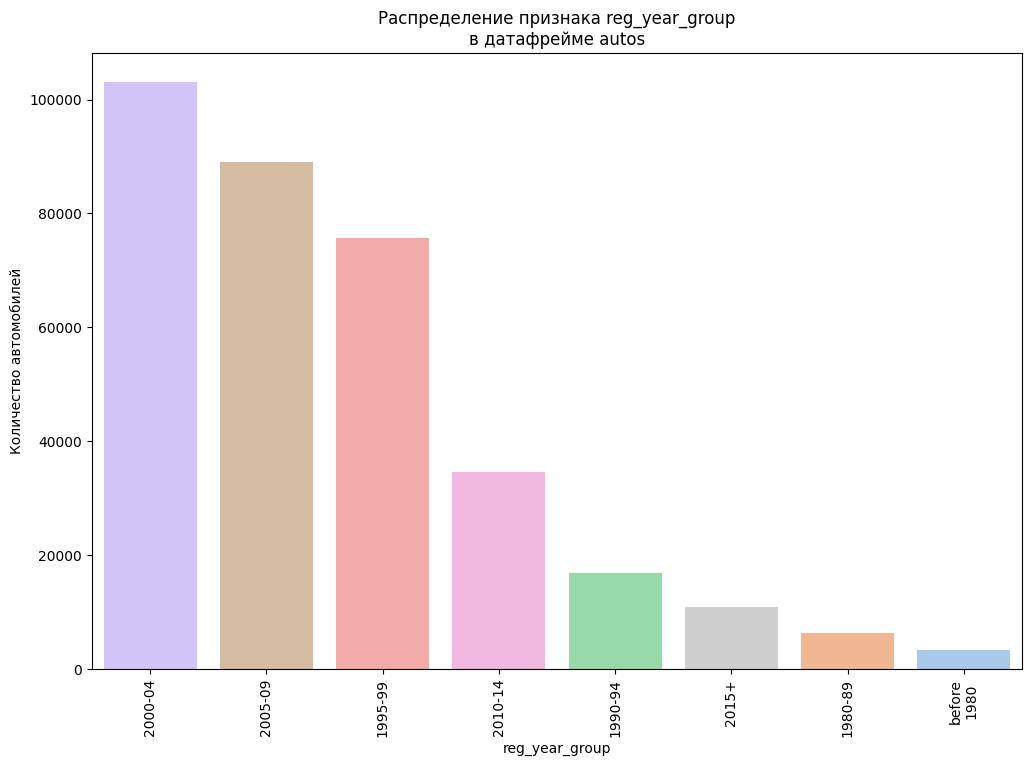

In [28]:
cat_feat_analysis(autos, 'reg_year_group', 'autos')

Получили 8 новых категорий, при этом признак распределён более равномерно - меньше 2% анкет представлено только для раритетных автомобилей, произведённых ранее 1980 года, или автомобилей с годом регистрации от 1980 до 1989 года. При этом более половины анкет представлены автомобилями, произведёнными в 00-х годах

Посмотрим также на распределение исходного признака после всех преобразований

Базовые статистики

count    339668.000000
mean       2002.509736
std           6.910598
min        1915.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64
-----------------------------------------------------


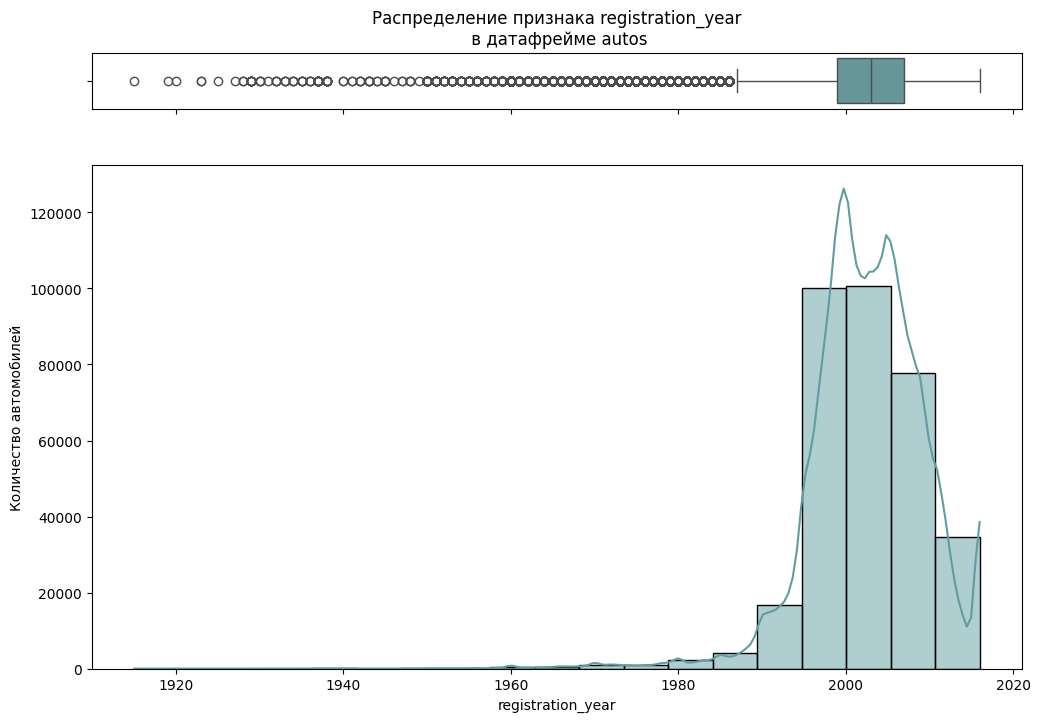

In [29]:
quant_feat_analysis(autos, 'registration_year', 'autos')

Распределение смещено влево из-за "хвоста" раритетных/старых автомобилей, примерно 75% автомобилей выпущены в 1999 году или позже

### power, power_log

Для начала узнаем, в каком вообще диапазоне может изменяться мощность автомобилей. [Здесь](https://quto.ru/journal/articles/kak-menyalas-srednyaya-moshnost-avtomobilei-za-vremya-sushestvovaniya-industrii.htm) указано, что средняя мощность современных автомобилей составляет около 200 л.с. Однако, например, самым продаваемым легковым автомобилем в первом десятилетии нового тысячелетия - временной отрезок, который представлен у нас наибольшим количеством анкет - была Toyota Camry, которую можно было приобрести с мощностью от 133 до 194 л.с. в 2000 году и от 155 до 268 л.с. в 2009 году. При этом есть отклонения в обе стороны:
* К концу 2000-х мощность в 400 л.с. в мощных автомобилях уже не была чем-то необычным, а Mustang GT достигал 460 л.с. В 2000-х годах Koenigsegg и Bugatti выжимали из своих гиперкаров 1 500 л.с.;
* [Здесь](https://auto-daily.livejournal.com/1090502.html) рассказывается о том, что первые автомобили 20-х годов 20 века вполне могли иметь мощность 10-50 л.с. Поэтому сверхнизкие значения мощности для старых автомобилей нас тоже не должны удивлять

Посмотрим, как обстоят дела в реальности

Базовые статистики

count    339668.000000
mean        111.027857
std         186.890710
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64
-----------------------------------------------------


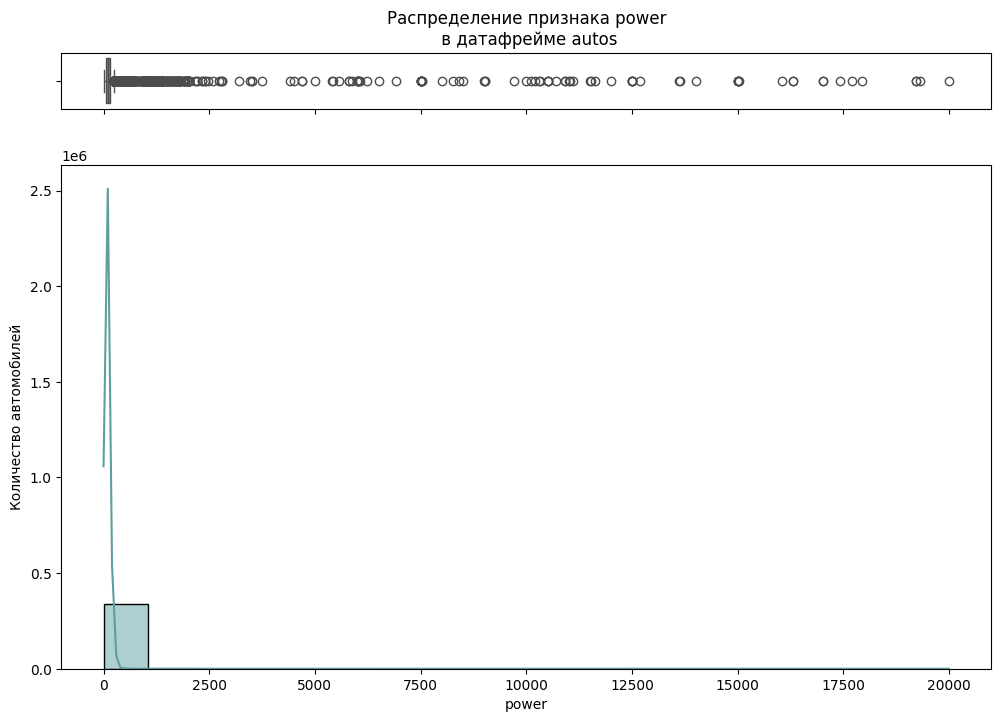

In [30]:
quant_feat_analysis(autos, 'power', 'autos')

Есть несколько видов аномальных значений. Сначала посмотрим на записи, где указана нулевая мощность автомобиля

In [31]:
autos.query('power == 0').head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code,reg_year_group
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435,1990-94
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,44145,1990-94
37,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,46483,2015+
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,56412,1990-94
54,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,88433,2005-09


In [32]:
autos.query('power == 0').shape

(36362, 13)

Около 10% записей имеют значения мощности, равные 0. Не хочется удалять такое большое количество записей - заполним записи с нулевыми значениями медианным значением мощности для автомобилей того же бренда и марки. В противном случае оставим нулевое значение

In [33]:
#считаем медианные значения
median_power = autos.loc[autos['power'] > 0].groupby(['brand', 'model'])['power'].median()

#функция для заполнения нулевых значений
def fill_zero_power(row):
    if row['power'] == 0:
        return median_power.get((row['brand'], row['model']), 0)
    else:
        return row['power']

autos['power'] = autos.apply(fill_zero_power, axis=1)
autos.query('power == 0').shape

(5509, 13)

Имеем около 1.6% записей от общего числа, где не удалось заполнить нулевые значеня. Удалим их

Базовые статистики

count    334159.000000
mean        122.799241
std         184.887048
min           1.000000
25%          75.000000
50%         110.000000
75%         147.000000
max       20000.000000
Name: power, dtype: float64
-----------------------------------------------------


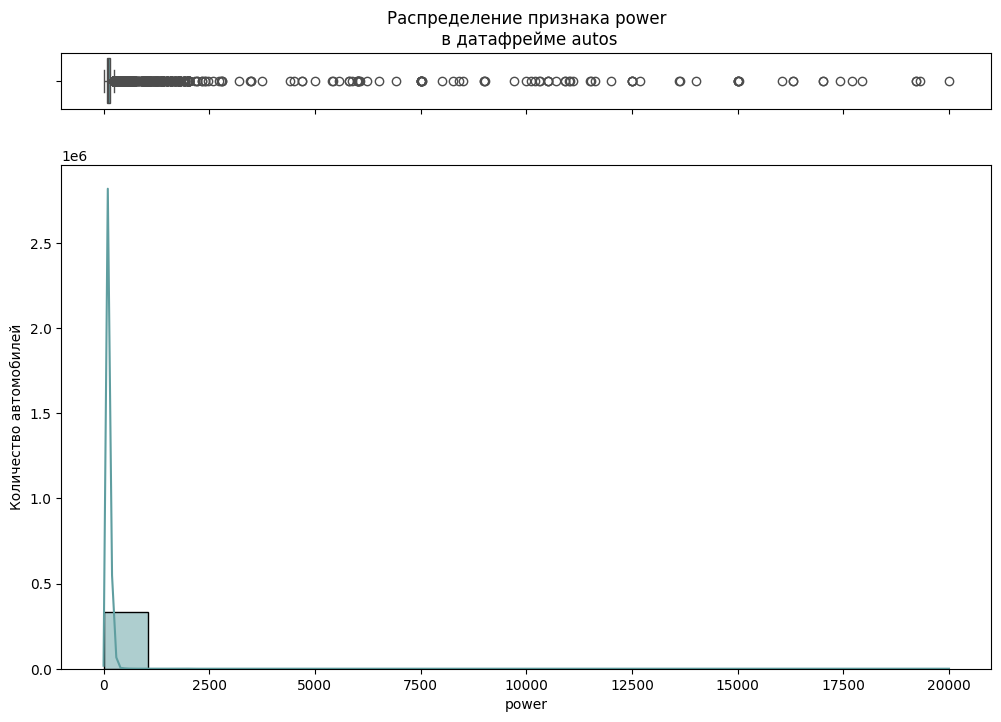

In [34]:
autos.query('power > 0', inplace=True)
quant_feat_analysis(autos, 'power', 'autos')

Посмотрим теперь на автомобили с мощностью не более 10 л.с

In [35]:
autos.query('power <= 10').head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code,reg_year_group
431,3950,small,2004,auto,5.0,NaN,70000,5,gasoline,sonstige_autos,no,90562,2000-04
3349,1990,small,2004,NaN,7.0,polo,150000,5,gasoline,volkswagen,no,37124,2000-04
9561,9000,sedan,2009,manual,2.0,a4,5000,12,gasoline,audi,NaN,12045,2005-09
11852,1999,coupe,1964,manual,10.0,NaN,150000,6,petrol,sonstige_autos,NaN,74918,before 1980
12747,2850,small,2005,auto,5.0,NaN,40000,8,gasoline,sonstige_autos,no,56825,2005-09
16228,2500,small,2006,auto,5.0,NaN,40000,1,gasoline,sonstige_autos,yes,78532,2005-09
16237,4500,other,2006,auto,5.0,NaN,40000,7,electric,sonstige_autos,no,77855,2005-09
16523,4600,other,2012,manual,4.0,NaN,20000,9,gasoline,sonstige_autos,no,40822,2010-14
20229,4999,sedan,2003,manual,1.0,e_klasse,150000,12,gasoline,mercedes_benz,NaN,66571,2000-04
20493,5200,small,1998,auto,5.0,NaN,40000,9,gasoline,sonstige_autos,NaN,84085,1995-99


In [36]:
autos.query('power <= 10')['brand'].value_counts()

sonstige_autos    145
volkswagen         18
opel               14
renault            10
seat                5
audi                5
ford                5
citroen             4
fiat                3
hyundai             3
mercedes_benz       2
mazda               2
smart               2
chrysler            2
porsche             1
mitsubishi          1
peugeot             1
honda               1
bmw                 1
daewoo              1
skoda               1
suzuki              1
Name: brand, dtype: int64

Большинство автомобилей в данной группе относятся к бренду `остальные машины`. Не самая информативная для нас группа

Посмотрим также, в каких годах были произведены данные машины. В реальности с мощностью не более 10 л.с. машины выпускались только в начале 20 века

In [37]:
autos.query('power <= 10')['reg_year_group'].value_counts()

2005-09        56
2000-04        54
2010-14        43
1995-99        33
1990-94        15
2015+          11
before 1980     9
1980-89         7
Name: reg_year_group, dtype: int64

In [38]:
autos.query('power <= 10 & reg_year_group == "before 1980"')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code,reg_year_group
11852,1999,coupe,1964,manual,10.0,NaN,150000,6,petrol,sonstige_autos,NaN,74918,before 1980
52952,990,coupe,1974,manual,1.0,kadett,5000,3,petrol,opel,yes,94036,before 1980
122963,4500,small,1956,manual,9.0,NaN,5000,0,petrol,sonstige_autos,NaN,21258,before 1980
196897,500,small,1975,manual,1.0,polo,150000,8,petrol,volkswagen,no,33442,before 1980
251318,2999,NaN,1970,manual,10.0,NaN,150000,10,petrol,sonstige_autos,no,74889,before 1980
275026,2,sedan,1950,auto,5.0,leon,5000,0,gasoline,seat,NaN,26919,before 1980
324049,8750,convertible,1923,manual,8.0,c3,5000,1,petrol,citroen,no,27299,before 1980
335547,9000,sedan,1938,manual,1.0,kadett,5000,0,petrol,opel,NaN,93437,before 1980
346716,0,NaN,1970,NaN,1.0,NaN,5000,1,NaN,sonstige_autos,NaN,15517,before 1980


Более-менее нормальной выглядит только анкета для [Citroen c3](https://ru.wikipedia.org/wiki/Citroën_Type_C). Есть подозрение, что значение 1 в мощности автомобиля для выделенных записей соответствует не этой характеристике, а объёму двигателя. Ничего не поделаешь, придётся удалить все записи с объёмом двигателя не более 10 л.с. кроме Citroen c3 1923 года выпуска

Базовые статистики

count    333932.000000
mean        122.879525
std         184.924217
min           8.000000
25%          75.000000
50%         110.000000
75%         147.000000
max       20000.000000
Name: power, dtype: float64
-----------------------------------------------------


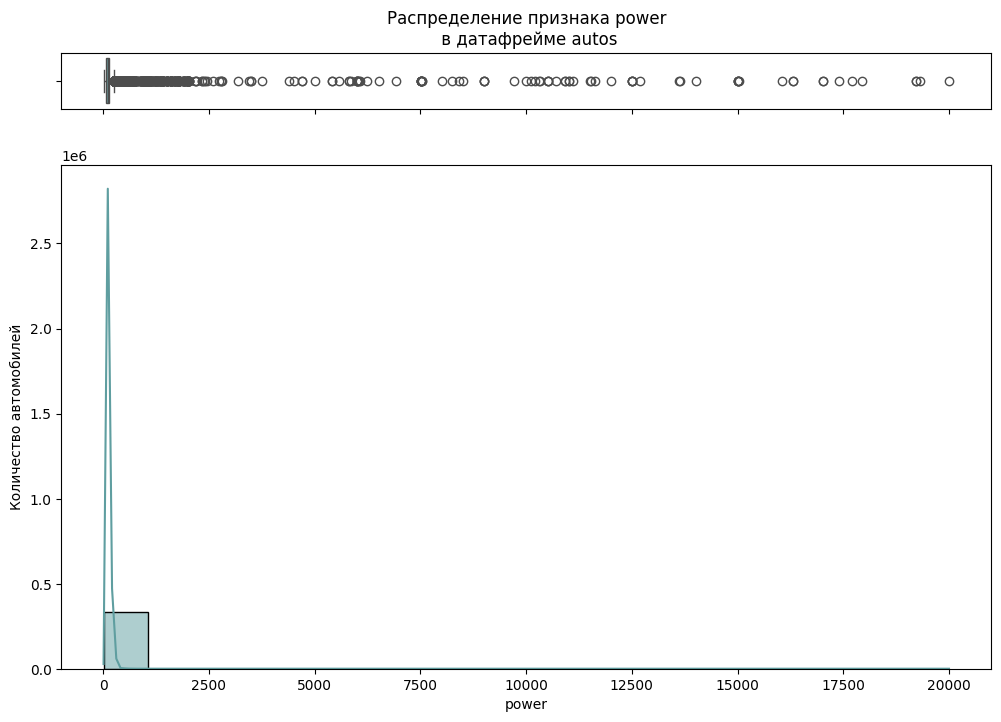

In [39]:
autos.query('power > 10 | registration_year == 1923', inplace=True)
quant_feat_analysis(autos, 'power', 'autos')

Наконец посмотрим на записи с мощностью автомобиля более 2000 л.с.

In [40]:
autos.query('power > 2000').sample(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code,reg_year_group
196532,6000,wagon,2004,auto,17700.0,5er,150000,7,gasoline,bmw,no,26316,2000-04
322798,0,sedan,2006,manual,2200.0,e_klasse,150000,12,gasoline,mercedes_benz,no,14947,2005-09
260878,1500,wagon,2006,manual,10910.0,NaN,20000,3,petrol,peugeot,yes,56567,2005-09
19092,9750,wagon,2005,auto,2729.0,5er,150000,7,gasoline,bmw,no,21376,2005-09
159612,1150,NaN,2016,manual,6011.0,polo,150000,5,NaN,volkswagen,no,49477,2015+
143118,6500,small,1987,manual,6018.0,cooper,60000,4,petrol,mini,NaN,91126,1980-89
227634,15499,wagon,2012,manual,13636.0,c_klasse,125000,4,gasoline,mercedes_benz,no,24983,2010-14
113184,350,small,1995,manual,5575.0,polo,150000,1,petrol,volkswagen,yes,29664,1995-99
148466,3650,small,2002,auto,15020.0,147,125000,11,petrol,alfa_romeo,no,30855,2000-04
290033,1000,small,1997,manual,5420.0,corsa,150000,0,petrol,opel,no,49824,1995-99


In [41]:
autos.query('power > 2000').shape

(109, 13)

Видим 109 записей, при этом более подробное изучение данных показывает, что это более-менее обычные автомобили, которые не должны иметь такое значение мощности двигателя в лошадиных силах. Возможно, ошибка могла возникнуть, если пользователь вместо мощности записывал объём двигателя в кубических сантиметрах. Удалим записи с аномально высоким объёмом двигателя

Базовые статистики

count    333823.000000
mean        120.198813
std          62.125964
min           8.000000
25%          75.000000
50%         110.000000
75%         147.000000
max        2000.000000
Name: power, dtype: float64
-----------------------------------------------------


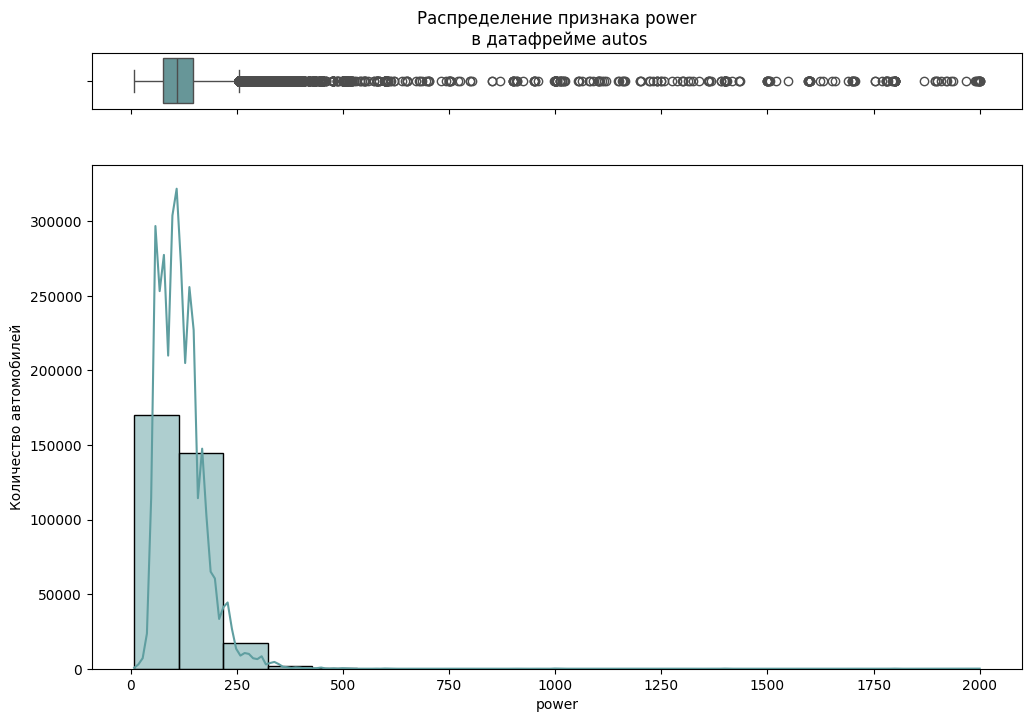

In [42]:
autos.query('power <=2000 ', inplace=True)
quant_feat_analysis(autos, 'power', 'autos')

Распределение приняло более разумный вид после удаления аномальных значений. Поскольку я не являюсь большим экспертом в автомобилях, не буду удалять оставшиеся высокие значения мощности автомобиля. Однако можно применить логарифмическую трансформацию для данного признака для получения распределения, более близкого к нормальному

Базовые статистики

count    333823.000000
mean          4.692335
std           0.435117
min           2.079442
25%           4.317488
50%           4.700480
75%           4.990433
max           7.600902
Name: power_log, dtype: float64
-----------------------------------------------------


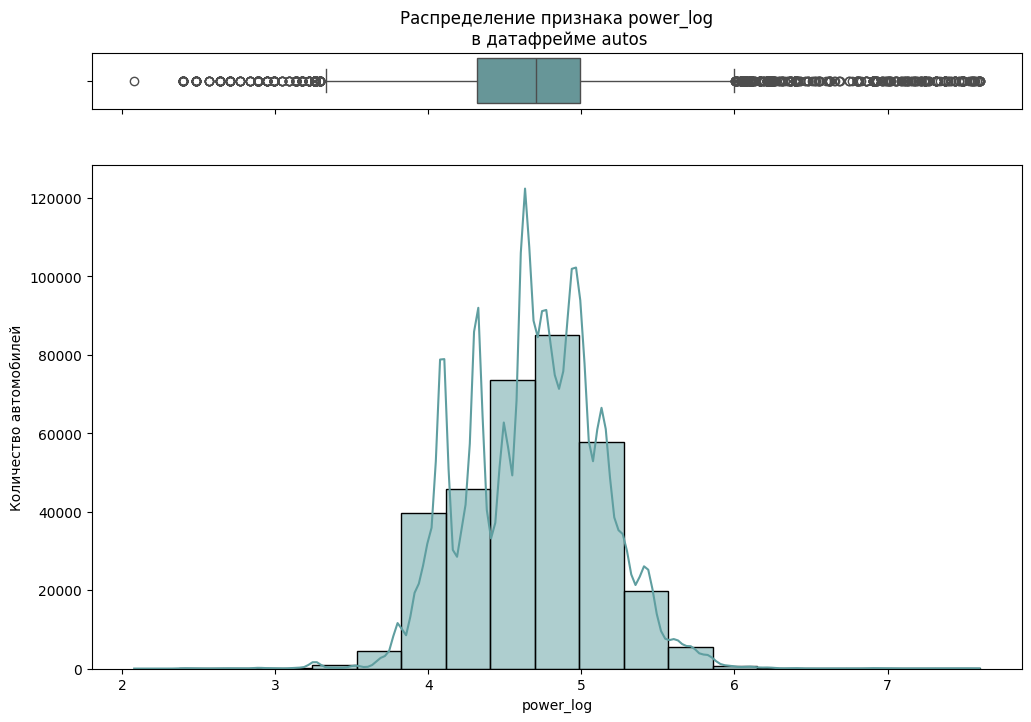

In [43]:
autos['power_log'] = np.log(autos['power'])
quant_feat_analysis(autos, 'power_log', 'autos')

Получили гораздо более близкое к нормальному распределение

### kilometer, kilo_group

Уникальные значения

150000    0.671395
125000    0.104004
100000    0.042214
90000     0.033299
80000     0.028979
70000     0.024825
60000     0.021610
50000     0.017905
5000      0.014807
40000     0.014244
30000     0.012629
20000     0.010931
10000     0.003157
Name: kilometer, dtype: float64
-----------------------------------------------------
Базовые статистики

count    333823.000000
mean     128448.848641
std       37324.115202
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64
-----------------------------------------------------


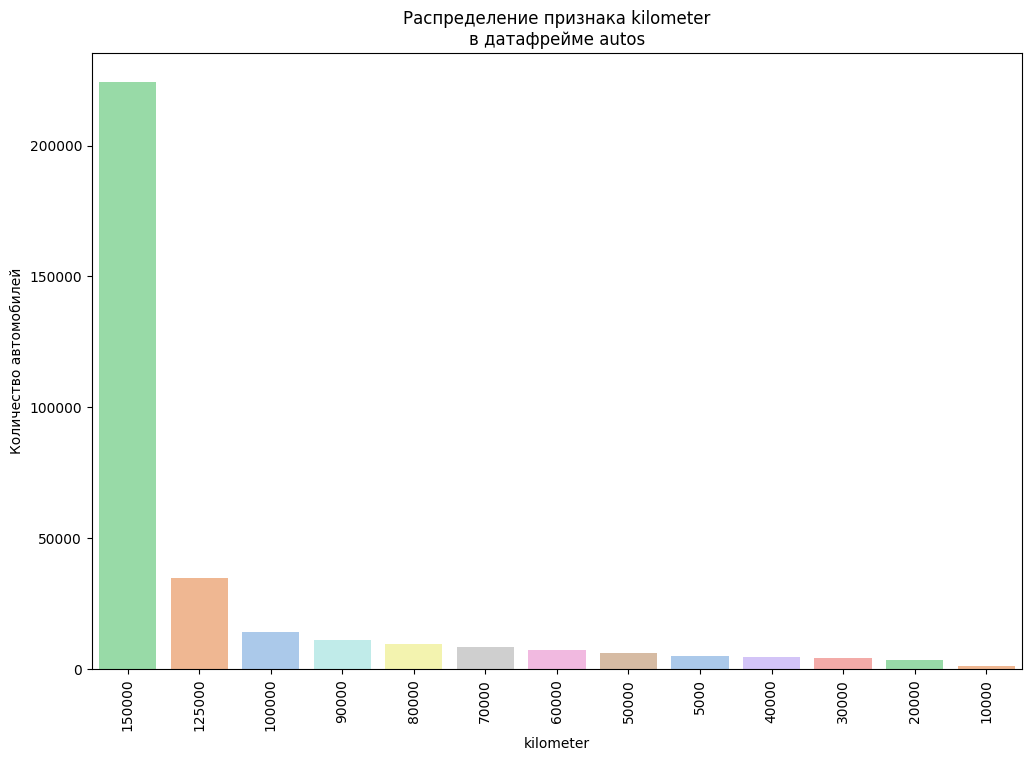

In [44]:
cat_feat_analysis(autos, 'kilometer', 'autos')

Видим разбалансированность значений по категориям - 2/3 анкет содержат информацию об автомобилях с пробегом 150000 км, остальная 1/3 'размазана' по 12 категориям. Сгруппируем автомобили по пробегу более компактно:
* 0-30 тыс. км - `new`;
* 40-50 тыс. км - `almost_new`;
* 60-100 тыс. км - `average`;
* 125 тыс. км - `high`;
* 150 тыс. км - `very_high`

In [45]:
#определим интервалы и названия категорий
bins = [0, 30000, 50000, 100000, 125000, 150000]
labels = [
    'new',
    'almost_new',
    'average',
    'high',
    'very_high'
]

#преобразуем года в категории  и посмотрим на полученный результат
autos['kilo_group'] = pd.cut(autos['kilometer'], bins=bins, labels=labels, right=True)
autos.head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code,reg_year_group,power_log,kilo_group
0,480,NaN,1993,manual,101.0,golf,150000,0,petrol,volkswagen,NaN,70435,1990-94,4.615121,very_high
1,18300,coupe,2011,manual,190.0,NaN,125000,5,gasoline,audi,yes,66954,2010-14,5.247024,high
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,NaN,90480,2000-04,5.093750,high
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,91074,2000-04,4.317488,very_high
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,60437,2005-09,4.234107,average
5,650,sedan,1995,manual,102.0,3er,150000,10,petrol,bmw,yes,33775,1995-99,4.624973,very_high
6,2200,convertible,2004,manual,109.0,2_reihe,150000,8,petrol,peugeot,no,67112,2000-04,4.691348,very_high
7,0,sedan,1980,manual,50.0,other,40000,7,petrol,volkswagen,no,19348,1980-89,3.912023,almost_new
8,14500,bus,2014,manual,125.0,c_max,30000,8,petrol,ford,NaN,94505,2010-14,4.828314,new
9,999,small,1998,manual,101.0,golf,150000,0,NaN,volkswagen,NaN,27472,1995-99,4.615121,very_high


Уникальные значения

very_high     0.671395
average       0.150927
high          0.104004
new           0.041525
almost_new    0.032149
Name: kilo_group, dtype: float64
-----------------------------------------------------
Базовые статистики

count        333823
unique            5
top       very_high
freq         224127
Name: kilo_group, dtype: object
-----------------------------------------------------


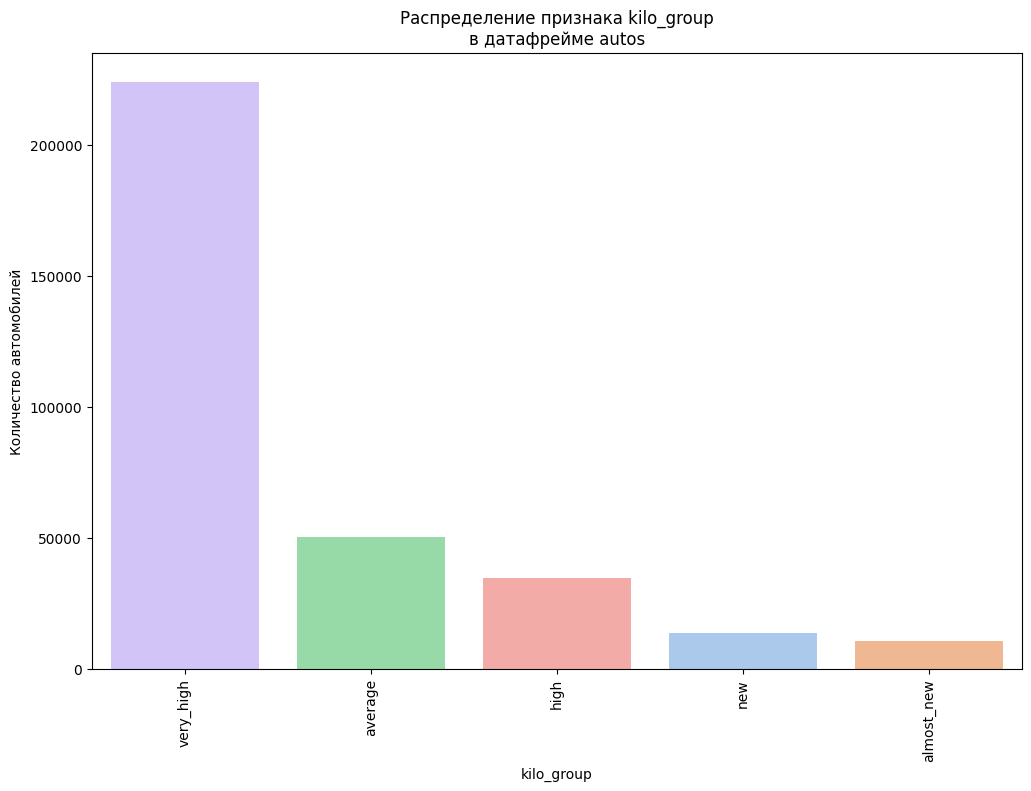

In [46]:
cat_feat_analysis(autos, 'kilo_group', 'autos')

Таким образом, сгруппировали данные по категориям - разбалансированность по группам осталась, но снизилась.

### registration_month

Уникальные значения

3     0.098717
0     0.090515
6     0.090272
4     0.083748
5     0.083526
7     0.078089
10    0.075136
11    0.069558
12    0.069402
9     0.068716
1     0.066254
8     0.064894
2     0.061173
Name: registration_month, dtype: float64
-----------------------------------------------------
Базовые статистики

count    333823.000000
mean          5.812544
std           3.682557
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64
-----------------------------------------------------


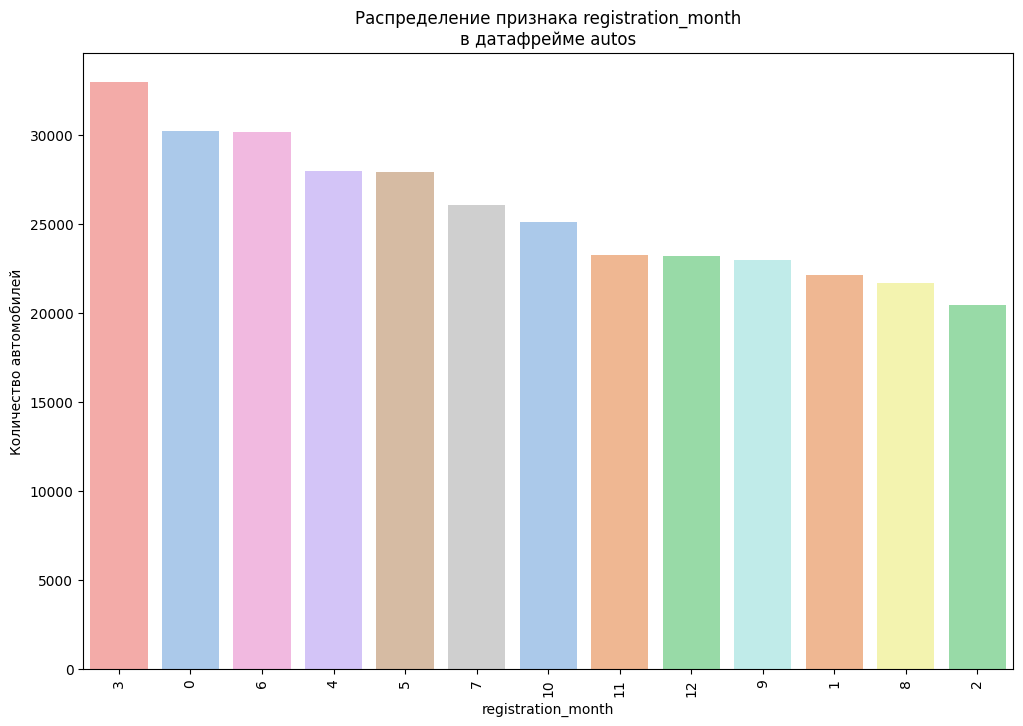

In [47]:
cat_feat_analysis(autos, 'registration_month', 'autos')

Удалим данный признак - дисперсия количества автомобилей в зависимости от категории невелика, к тому же значений признака больше, чем количество месяцев в году, что настораживает

In [48]:
autos.drop(['registration_month'], axis=1, inplace=True)

### brand

Уникальные значения

volkswagen        0.216483
opel              0.112383
bmw               0.105766
mercedes_benz     0.091722
audi              0.084383
ford              0.071448
renault           0.049985
peugeot           0.031151
fiat              0.026912
seat              0.019379
skoda             0.015949
mazda             0.015862
smart             0.014801
citroen           0.014502
nissan            0.014061
toyota            0.013229
hyundai           0.010158
volvo             0.009346
mini              0.009238
mitsubishi        0.008600
honda             0.007950
kia               0.007004
suzuki            0.006590
alfa_romeo        0.006572
sonstige_autos    0.005317
chevrolet         0.005006
chrysler          0.004098
dacia             0.002600
daihatsu          0.002286
subaru            0.002190
porsche           0.002160
jeep              0.001938
land_rover        0.001600
trabant           0.001561
saab              0.001531
daewoo            0.001486
jaguar 

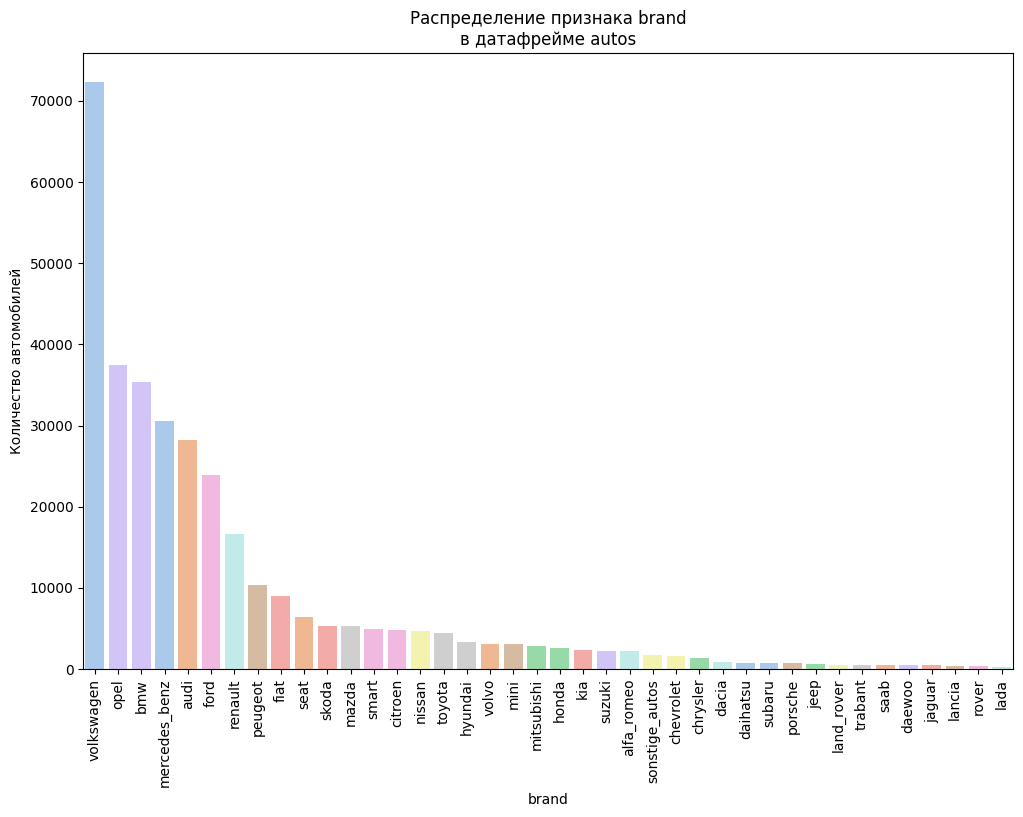

In [49]:
cat_feat_analysis(autos, 'brand', 'autos')

Имеем 40 брендов автомобилей, при этом присутствует категория `sonstige_autos` - `остальные_авто`. При этом 4 самых популярных бренда - `volkswagen`, `opel`, `bmw` и `mercedes_benz` - покрывают более 50% анкет. В данном случае не будем группировать автомобили - разные бренды относятся к разным ценовым категориям, и поскольку у меня нет глубоких познаний в моделях разных брендов, оставлю данные группы как есть. Запомним это место - в том случае, если модель не будет достигать приемлемого качества, возможно будет здесь провести группировку

### postal_code

Базовые статистики

count    333823.000000
mean      50692.858701
std       25795.802883
min        1067.000000
25%       30419.000000
50%       49565.000000
75%       71277.000000
max       99998.000000
Name: postal_code, dtype: float64
-----------------------------------------------------


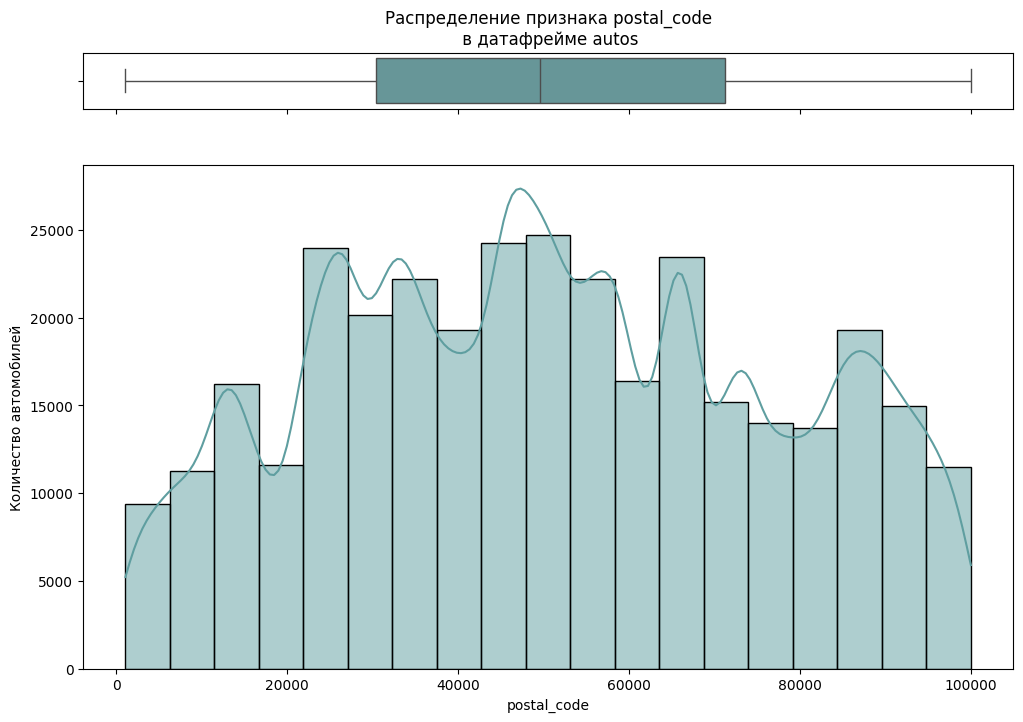

In [50]:
quant_feat_analysis(autos, 'postal_code', 'autos')

Распределение признака близко к равномерному. Удалим данный признак ввиду малой дисперсии, к тому же данный признак не является информативным без дополнительных данных - как минимум, страны, в которой живёт пользователь

In [51]:
autos.drop(['postal_code'], axis=1, inplace=True)

Перейдём теперь к анализу признаков с пропущенными значениями.

Сначала посмотрим на записи с пропусками во всех 5 признаках

In [52]:
cols_na = ['model', 'gearbox', 'fuel_type', 'vehicle_type', 'repaired']
autos[autos[cols_na].isna().all(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 1331 to 353104
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   price              166 non-null    int32   
 1   vehicle_type       0 non-null      object  
 2   registration_year  166 non-null    int32   
 3   gearbox            0 non-null      object  
 4   power              166 non-null    float64 
 5   model              0 non-null      object  
 6   kilometer          166 non-null    int32   
 7   fuel_type          0 non-null      object  
 8   brand              166 non-null    object  
 9   repaired           0 non-null      object  
 10  reg_year_group     166 non-null    category
 11  power_log          166 non-null    float64 
 12  kilo_group         166 non-null    category
dtypes: category(2), float64(2), int32(3), object(6)
memory usage: 14.5+ KB


Всего 166 записей - удалим их ввиду малого числа и большого количества пропущенных значений

In [53]:
autos.dropna(subset=cols_na, how='all', inplace=True)

### model

In [54]:
autos['model'].value_counts()[:30]

golf           27601
other          23846
3er            19219
polo           12437
corsa          11924
astra          10331
passat          9839
a4              9692
c_klasse        8111
5er             7716
e_klasse        6632
a3              5758
focus           5629
fiesta          5546
a6              5423
2_reihe         4699
transporter     4661
twingo          4641
fortwo          4186
vectra          4093
a_klasse        3919
mondeo          3499
1er             3417
3_reihe         3369
clio            3359
touran          3259
punto           3135
zafira          2852
megane          2790
ka              2598
Name: model, dtype: int64

In [55]:
autos['model'].value_counts()[-30:]

glk                   63
crossfire             63
nubira                61
move                  57
range_rover_sport     54
lybra                 53
145                   45
v60                   41
croma                 40
lodgy                 35
terios                35
delta                 32
charade               26
b_max                 26
9000                  26
musa                  22
200                   18
materia               18
kappa                 15
q3                    15
amarok                15
samara                13
gl                    12
i3                     8
elefantino             8
serie_2                7
kalina                 6
serie_3                4
rangerover             3
range_rover_evoque     2
Name: model, dtype: int64

In [56]:
autos['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', '100', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda',
       'up', 'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira',
       'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1',
       

Отметим несколько особенностей значений данного признака:

* очень большое количество категорий - некоторые модели автомобилей представлены всего 2-3 десятками анкет, а то и меньше;
* вторая по популярности модель - `other`. В эту группу можно будет отнести пропущенные значения;
* есть неявные дубликаты `range_rover` и `rangerover`. Объединим эти значения в одну категорию. При этом `range_rover_sport` и `range_rover_evoque` - это уже другие и разные модели;
* нет полной уверенности, что `3er`, `3_reihe` и `serie_3` (и аналогичные группы для других цифр, например 2) - это одинаковые модели BMW. Поэтому было принято решение оставить эти модели как есть

In [57]:
#заполним пропуски значением other
autos['model'].fillna(value='other', inplace=True)

#заменим значение rangerover на range_rover
autos['model'].replace(to_replace='rangerover', value='range_rover', inplace=True)

#проверим наличие пропусков
autos['model'].isna().sum()

0

Пропущенные значения отсутствуют

In [58]:
autos['model'].value_counts()

other                 35562
golf                  27601
3er                   19219
polo                  12437
corsa                 11924
                      ...  
elefantino                8
serie_2                   7
kalina                    6
serie_3                   4
range_rover_evoque        2
Name: model, Length: 248, dtype: int64

Категория `other` стала самой популярной, при этом категория `rangerover`, которая была одной из наименее популярных, пропала - обработка произведена успешно

### gearbox

Уникальные значения

manual    0.800423
auto      0.199577
Name: gearbox, dtype: float64
-----------------------------------------------------
Базовые статистики

count     318825
unique         2
top       manual
freq      255195
Name: gearbox, dtype: object
-----------------------------------------------------


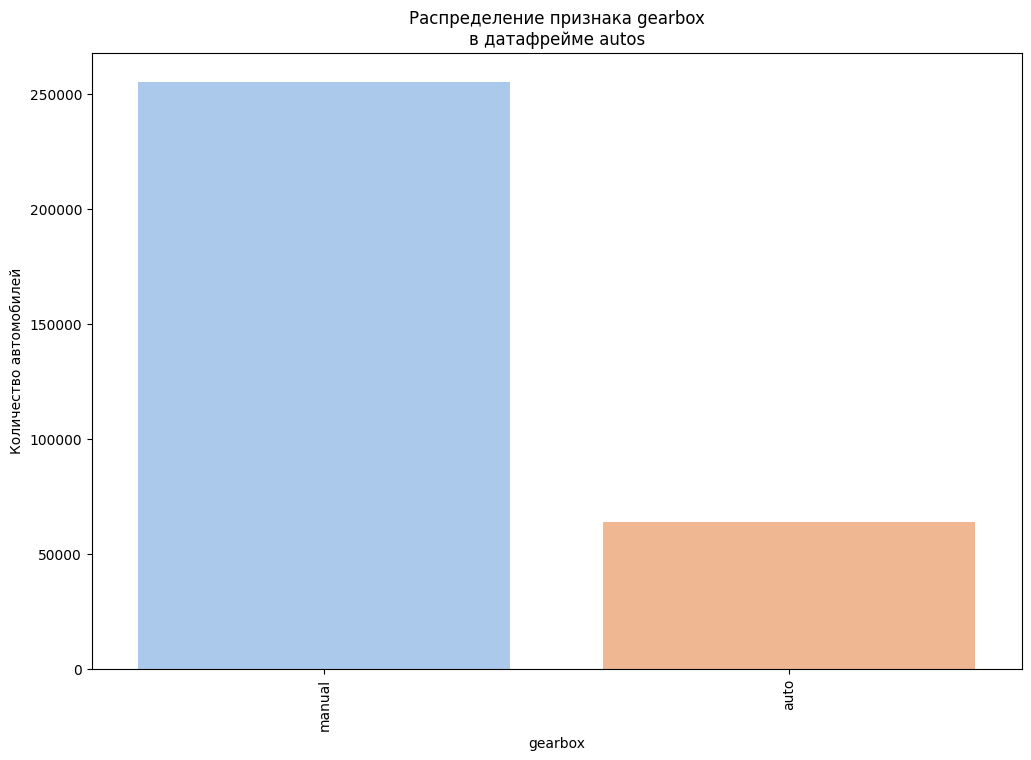

In [59]:
cat_feat_analysis(autos, 'gearbox', 'autos')

Примерно 80% процентов автомобилей имеют МКПП, около 20% - АКПП

In [60]:
autos['gearbox'].isna().mean()

0.04445283629595662

Имеем почти 4.5% пропущенных значений. 

Сгруппируем данные по марке автомобиля и его модели. Заполним пропущенные значения модой группы, в противном случае оставим пропуск. Создадим функцию для заполнения пропусков

In [61]:
# функция для заполнения по моде внутри группы
# или np.nan, если мода отсутствует

def fiilna_with_group_mode(group):
    #group - группа значений
    
    mode = group.mode()
    if not mode.empty:
        return group.fillna(mode[0])
    else:
        return np.nan

Уникальные значения

manual    0.803622
auto      0.196378
Name: gearbox, dtype: float64
-----------------------------------------------------
Базовые статистики

count     333657
unique         2
top       manual
freq      268134
Name: gearbox, dtype: object
-----------------------------------------------------


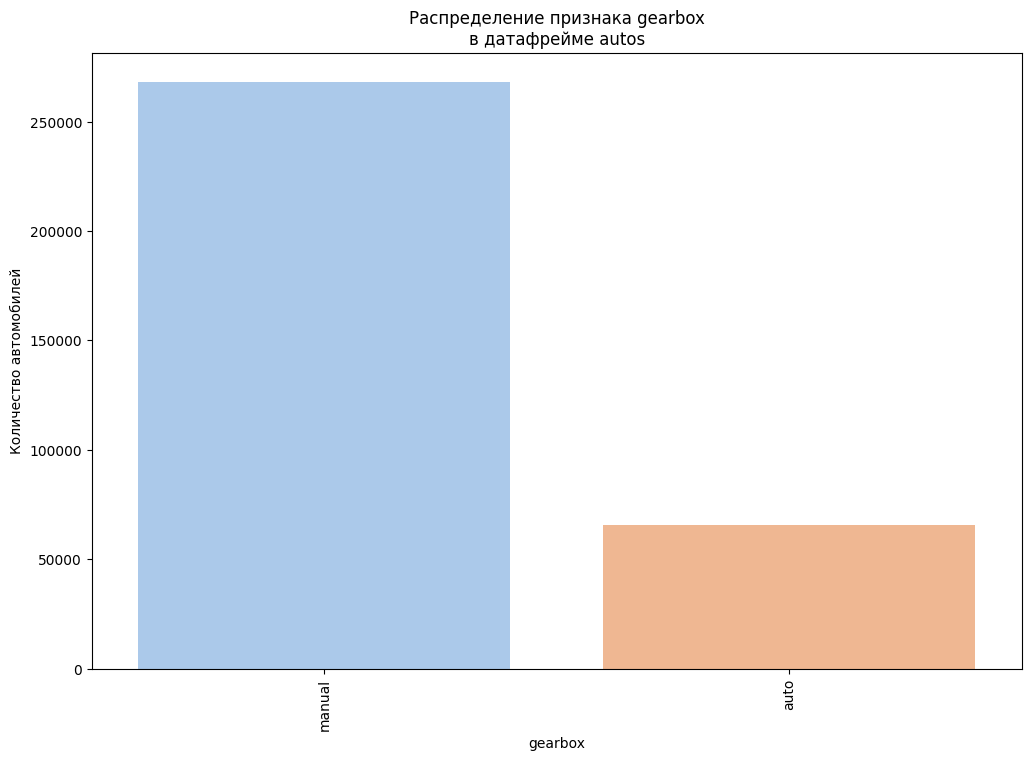

In [62]:
#заполним пропущенные значения
autos['gearbox'] = (
    autos.groupby(['brand', 'model'])['gearbox']
         .transform(fiilna_with_group_mode)
)

cat_feat_analysis(autos, 'gearbox', 'autos')

Доля автомобилей с МКПП незначительно выросла после заполнения пропусков

In [63]:
autos['gearbox'].isna().mean()

0.0

При этом необработанных пропущенных значений не осталось

### vehicle_type

Уникальные значения

sedan          0.289232
small          0.251477
wagon          0.206117
bus            0.090850
convertible    0.063820
coupe          0.050998
suv            0.037803
other          0.009703
Name: vehicle_type, dtype: float64
-----------------------------------------------------
Базовые статистики

count     313914
unique         8
top        sedan
freq       90794
Name: vehicle_type, dtype: object
-----------------------------------------------------


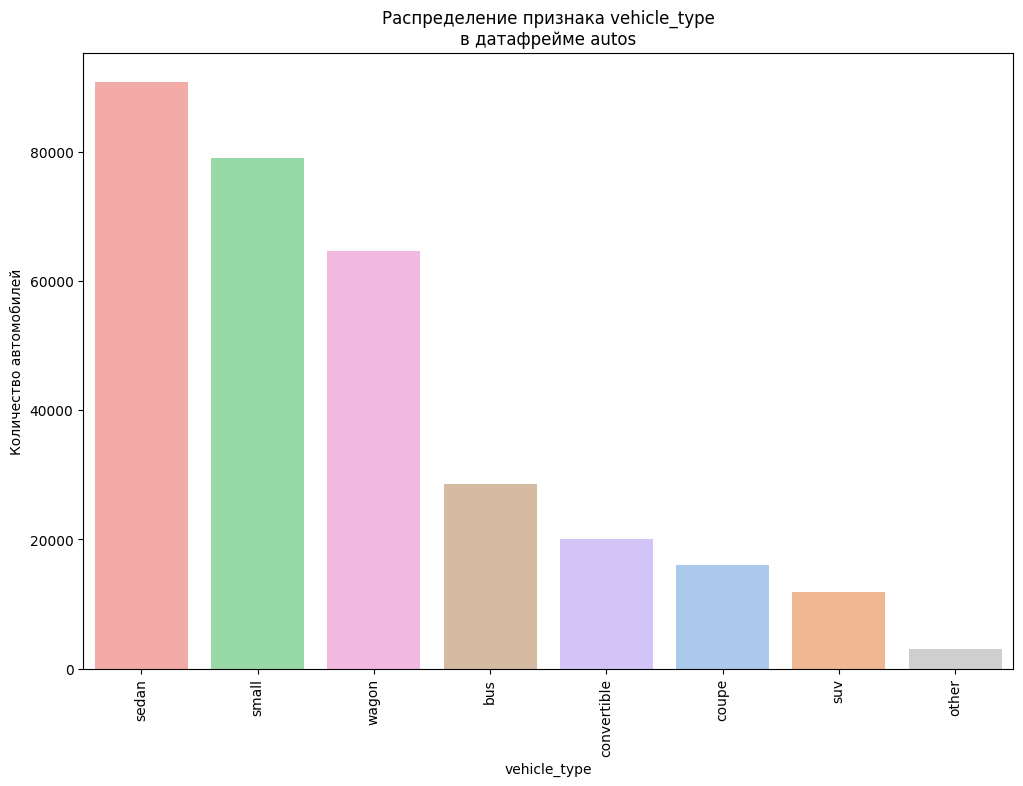

In [64]:
cat_feat_analysis(autos, 'vehicle_type', 'autos')

Наблюдаем 8 типов кузовов автомобилей. При этом 3 типа кузова - `sedan`, `small` и `wagon` - покрывают почти 75% известных данных о типах кузовов автомобилей. Также присутствует группа `other`, в которой находится около 1% данных

In [65]:
autos['vehicle_type'].isna().mean()

0.059171544430358124

Имеем почти 6 процентов пропущенных значений. Поступим так же, как и с предыдущим признаком - сгруппируем данные по марке автомобиля и его модели. Заполним пропущенные значения модой группы, в противном случае оставим пропуск. Воспользуемся уже имеющейся функцией

Уникальные значения

sedan          0.296103
small          0.255628
wagon          0.200571
bus            0.091636
convertible    0.060613
coupe          0.049695
suv            0.036621
other          0.009132
Name: vehicle_type, dtype: float64
-----------------------------------------------------
Базовые статистики

count     333657
unique         8
top        sedan
freq       98797
Name: vehicle_type, dtype: object
-----------------------------------------------------


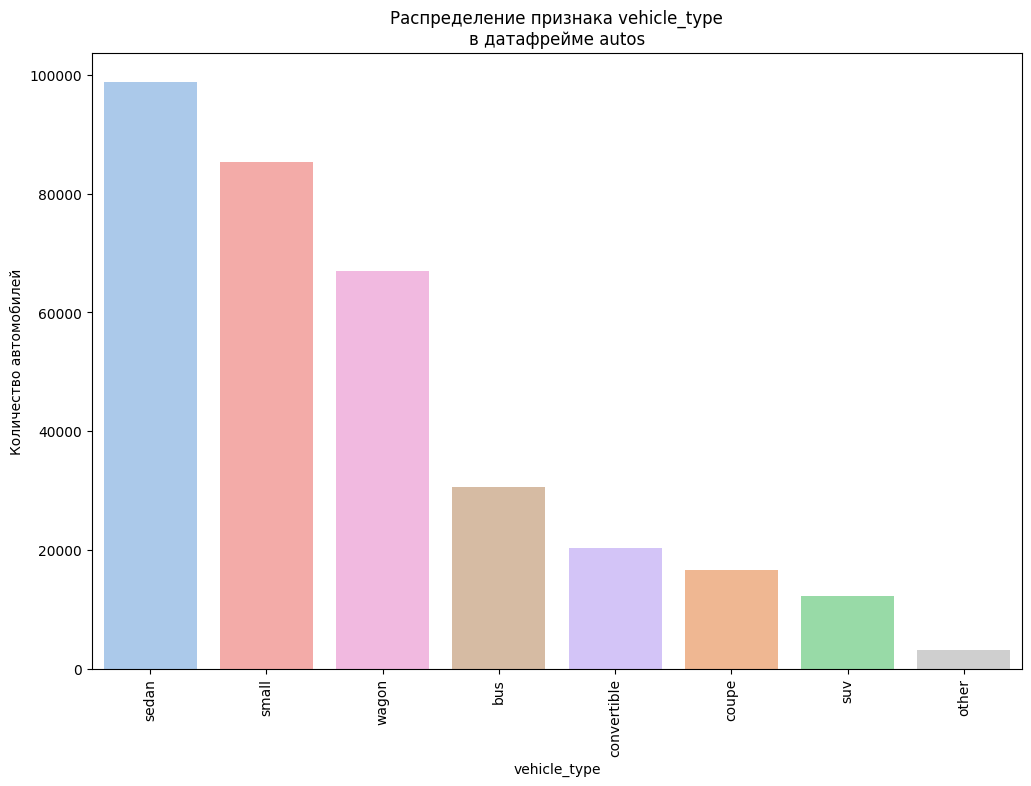

In [66]:
autos['vehicle_type'] = (
    autos.groupby(['brand', 'model'])['vehicle_type']
         .transform(fiilna_with_group_mode)
)

cat_feat_analysis(autos, 'vehicle_type', 'autos')

In [67]:
autos['vehicle_type'].isna().sum()

0

Доля автомобилей с кузовом `sedan` выросла почти на 1%, с кузовом `small` - на 0.5%, `wagon` - упала примерно на 0.5%. Для остальных категорий процентное соотношение изменилось меньше

При этом все пропущенные значения оказались обработаны

### fuel_type

Уникальные значения

petrol      0.671679
gasoline    0.308672
lpg         0.016507
cng         0.001734
hybrid      0.000720
other       0.000462
electric    0.000226
Name: fuel_type, dtype: float64
-----------------------------------------------------
Базовые статистики

count     309740
unique         7
top       petrol
freq      208046
Name: fuel_type, dtype: object
-----------------------------------------------------


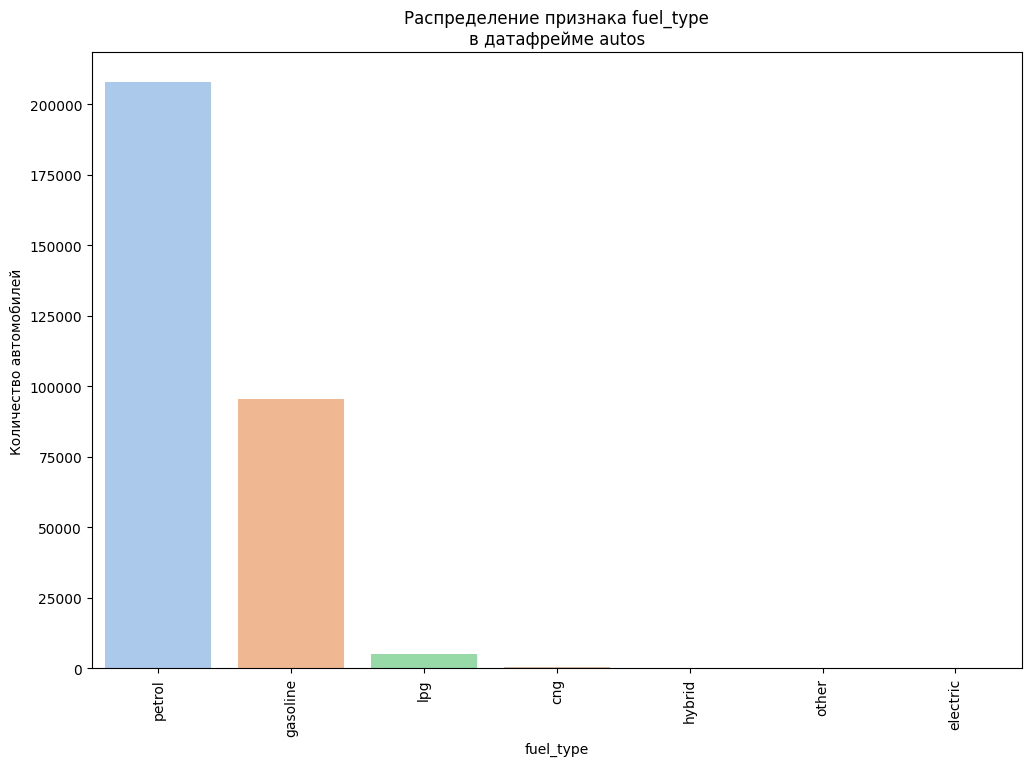

In [68]:
cat_feat_analysis(autos, 'fuel_type', 'autos')

Наблюдаем 7 категорий, причём 2 самых популярных вида топлива -  `gasoline` и `petrol` - используют более 98% автомобилей. Стоит отметить, что [различные](https://tagvault.org/blog/gasoline-vs-petrol-explained/) [статьи](https://thecontentauthority.com/blog/petrol-vs-gasoline) говорят о том, что эти два понятия описывают [один и тот же](https://thisvsthat.io/gasoline-vs-petrol) вид тот топлива, но используются в разных регионах планеты. Объединим 2 данные категории топлива в одну

In [69]:
autos['fuel_type'].replace(to_replace='gasoline', value='petrol', inplace=True)

Остальные категории описывают уникальные различающиеся между собой виды топлива, оставим их как есть

In [70]:
autos['fuel_type'].isna().mean()

0.07168139736316037

Имеем около 7 процентов пропущенных значений. Заполним их по аналогии с предыдущими признаками

Уникальные значения

petrol      0.981760
lpg         0.015324
cng         0.001609
hybrid      0.000668
other       0.000429
electric    0.000210
Name: fuel_type, dtype: float64
-----------------------------------------------------
Базовые статистики

count     333657
unique         6
top       petrol
freq      327571
Name: fuel_type, dtype: object
-----------------------------------------------------


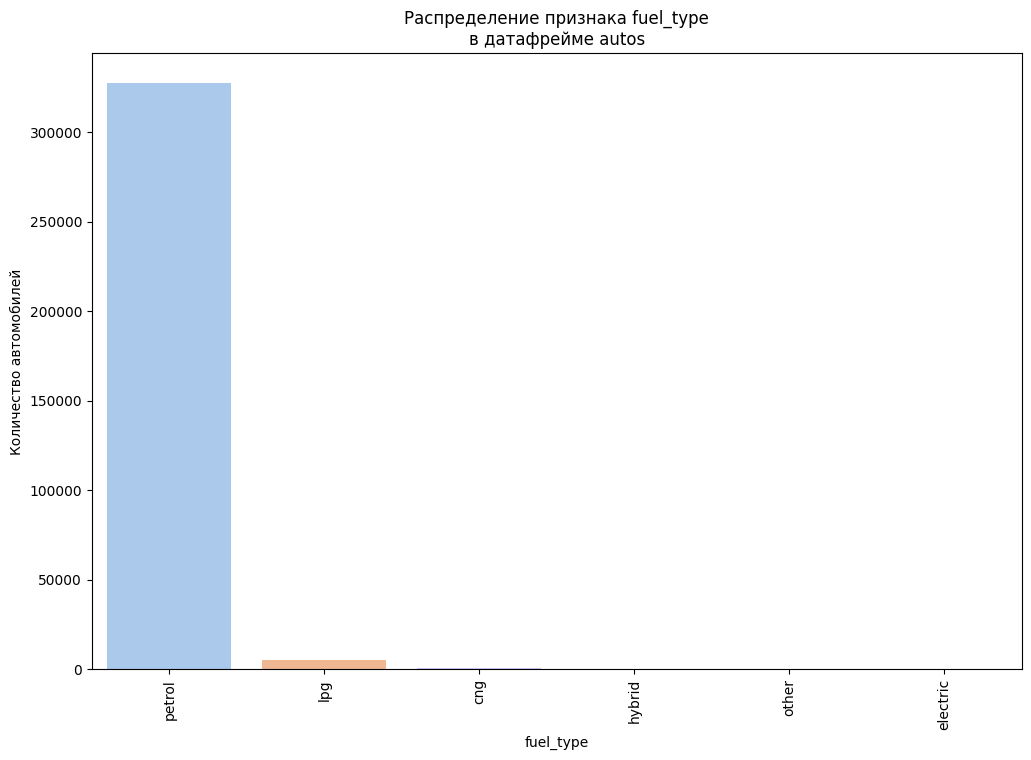

In [71]:
autos['fuel_type'] = (
    autos.groupby(['brand', 'model'])['fuel_type']
         .transform(fiilna_with_group_mode)
)

cat_feat_analysis(autos, 'fuel_type', 'autos')

Ожидаемо возросла доля только у автомобилей, использующих бензин

In [72]:
autos['fuel_type'].isna().mean()

0.0

Пропущенных значений не осталось. При этом 6 категорий описывают меньше 2% записей, что может негативно сказаться на важности признака

### repaired

Уникальные значения

no     0.87434
yes    0.12566
Name: repaired, dtype: float64
-----------------------------------------------------
Базовые статистики

count     273047
unique         2
top           no
freq      238736
Name: repaired, dtype: object
-----------------------------------------------------


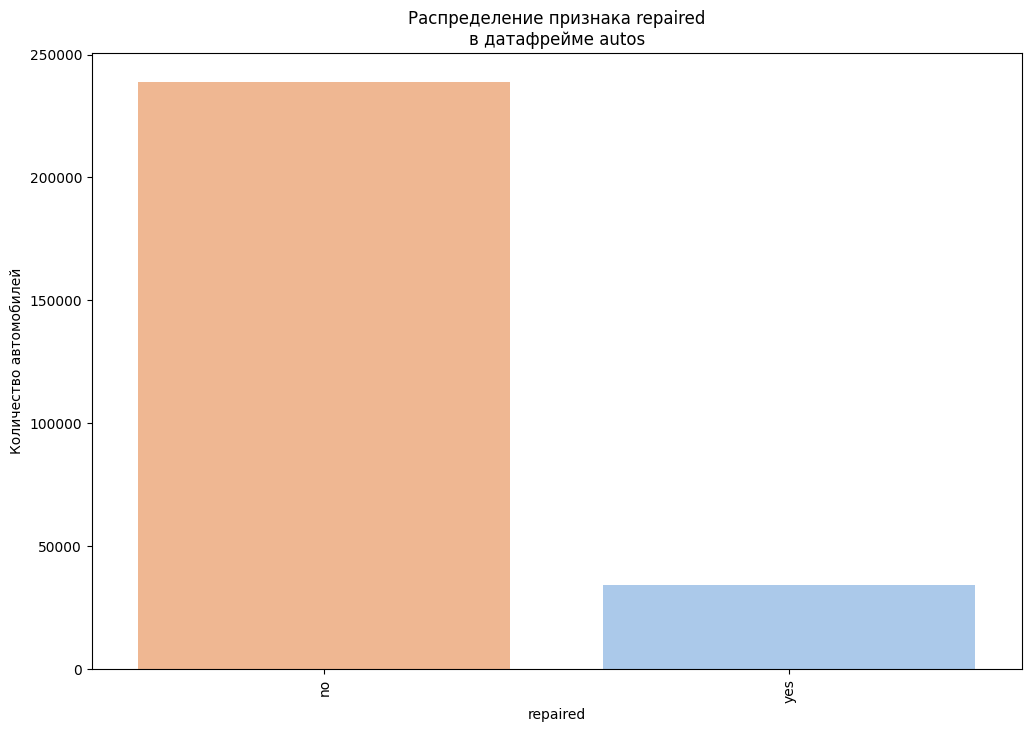

In [73]:
cat_feat_analysis(autos, 'repaired', 'autos')

Почти 90% автомобилей не было в ремонте ни разу

In [74]:
autos['repaired'].isna().mean()

0.1816536143404754

Имеем около 20% пропущенных значений. Посмотрим, как изменяется доля ремонтировавшихся машин в зависимости от возраста автомобиля - ожидается, что чем старее автомобиль, тем более вероятно, что он ремонтировался

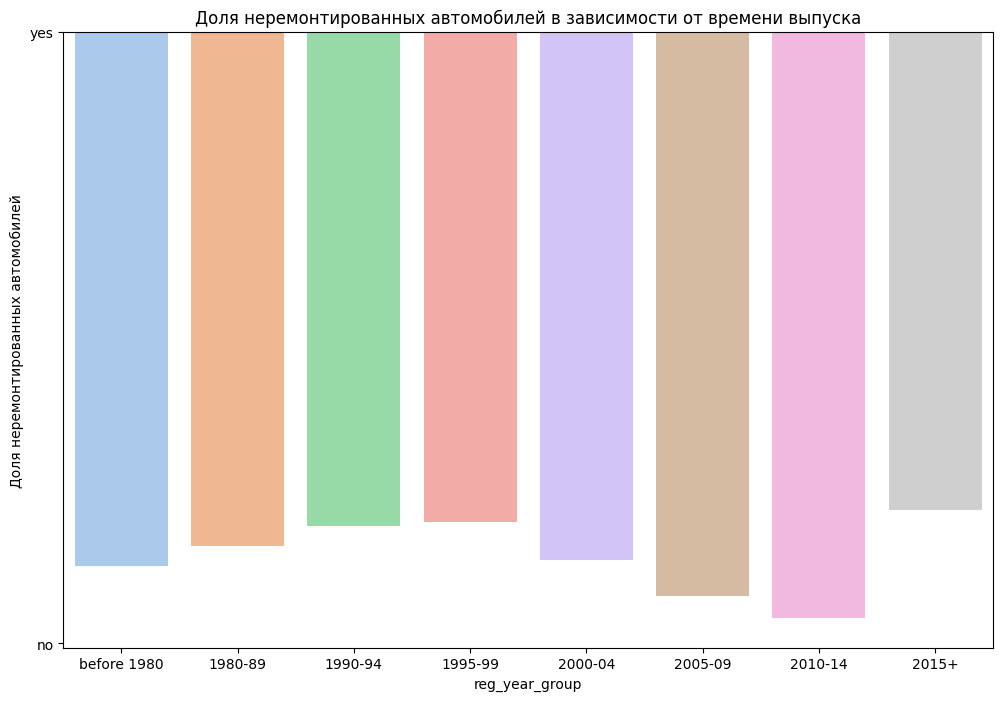

In [75]:
sns.barplot(
    data=autos,
    x='reg_year_group',     
    y='repaired',   
    hue='reg_year_group',
    estimator=lambda x: x.mean(),  
    errorbar=None,
    palette='pastel'
)
plt.ylabel('Доля неремонтированных автомобилей')
plt.xlabel('reg_year_group')
plt.title('Доля неремонтированных автомобилей в зависимости от времени выпуска')
plt.xticks(rotation=0)
plt.show()

Парадоксально, но изначальное предположение подтвердилось лишь частично. Больше всего чинилось самых новых машин - возможно, поэтому они и продаются, что не устроили владельцев. При этом на предыдущем временном интервале - с 2010 по 2014 год - доля автомобилей, побывавших в ремонте, наименьшая. Затем до отрезка 1995-99 идёт ожидаемое возрастание доли чинившихся автомобилей, а после этого тренд меняется на обратный. Возможно, это связано с малым объёмом выборки для старых и раритетных автомобилей.

Так как нет ярко выраженного тренда между возрастом автомобиля и вероятностью его ремонта, заполним пропуски тем же методом, что и ранее - какие-то марки и модели автомобилей более склонны к поломкам, какие-то менее

Уникальные значения

no     0.897167
yes    0.102833
Name: repaired, dtype: float64
-----------------------------------------------------
Базовые статистики

count     333657
unique         2
top           no
freq      299346
Name: repaired, dtype: object
-----------------------------------------------------


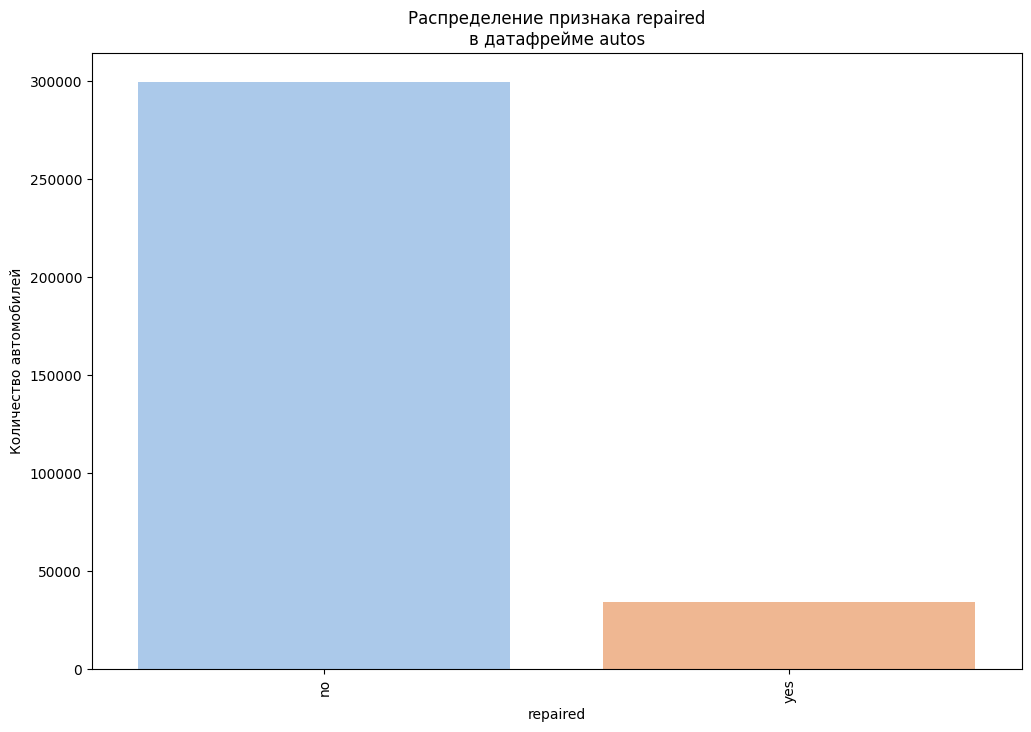

In [76]:
autos['repaired'] = (
    autos.groupby(['brand', 'model'])['repaired']
         .transform(fiilna_with_group_mode)
)

cat_feat_analysis(autos, 'repaired', 'autos')

Доля неремонтировавшихся автомобилей закономерно возросла

In [77]:
autos['repaired'].isna().sum()

0

Пропущенных значений не осталось

### price

Наконец, перейдём к анализу таргета

Базовые статистики

count    333657.000000
mean       4520.196900
std        4554.685153
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64
-----------------------------------------------------


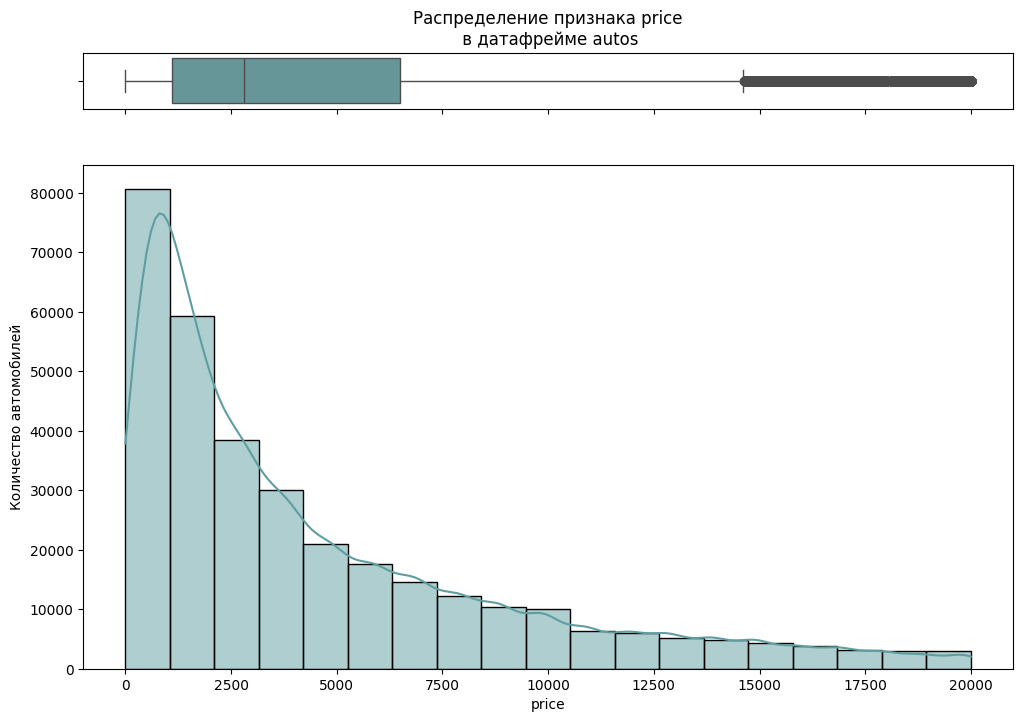

In [78]:
quant_feat_analysis(autos, 'price', 'autos')

Распределение таргета сильно смещено вправо из-за дорогих автомобилей - среднее значение более чем в 1.5 превышает медиану.

Сначала посмотрим на автомобили с аномально низким значением таргета

In [79]:
autos.query('price == 0').shape

(8769, 13)

In [80]:
autos.query('price == 0').head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,reg_year_group,power_log,kilo_group
7,0,sedan,1980,manual,50.0,other,40000,petrol,volkswagen,no,1980-89,3.912023,almost_new
40,0,small,1990,manual,60.0,corsa,150000,petrol,opel,no,1990-94,4.094345,very_high
152,0,bus,2004,manual,101.0,meriva,150000,lpg,opel,yes,2000-04,4.615121,very_high
154,0,small,2006,manual,92.0,other,5000,petrol,fiat,no,2005-09,4.521789,new
231,0,wagon,2001,manual,115.0,mondeo,150000,petrol,ford,no,2000-04,4.744932,very_high
334,0,small,2005,manual,60.0,polo,150000,petrol,volkswagen,no,2005-09,4.094345,very_high
415,0,sedan,1985,manual,150.0,3er,150000,petrol,bmw,no,1980-89,5.010635,very_high
466,0,sedan,2016,auto,197.0,3er,150000,petrol,bmw,no,2015+,5.283204,very_high
471,0,sedan,1990,manual,150.0,3er,5000,petrol,bmw,no,1990-94,5.010635,new
524,0,coupe,2005,manual,136.0,other,100000,petrol,toyota,no,2005-09,4.912655,average


C учётом того, что это таргет, мы не можем никак корректировать данные аномальные значения - вряд ли люди зарегистрировались на сайте продаж автомобилей, чтобы продать машину за ноль евро. Придётся удалить данные записи

Базовые статистики

count    324888.000000
mean       4642.200811
std        4553.978412
min           1.000000
25%        1200.000000
50%        2950.000000
75%        6700.000000
max       20000.000000
Name: price, dtype: float64
-----------------------------------------------------


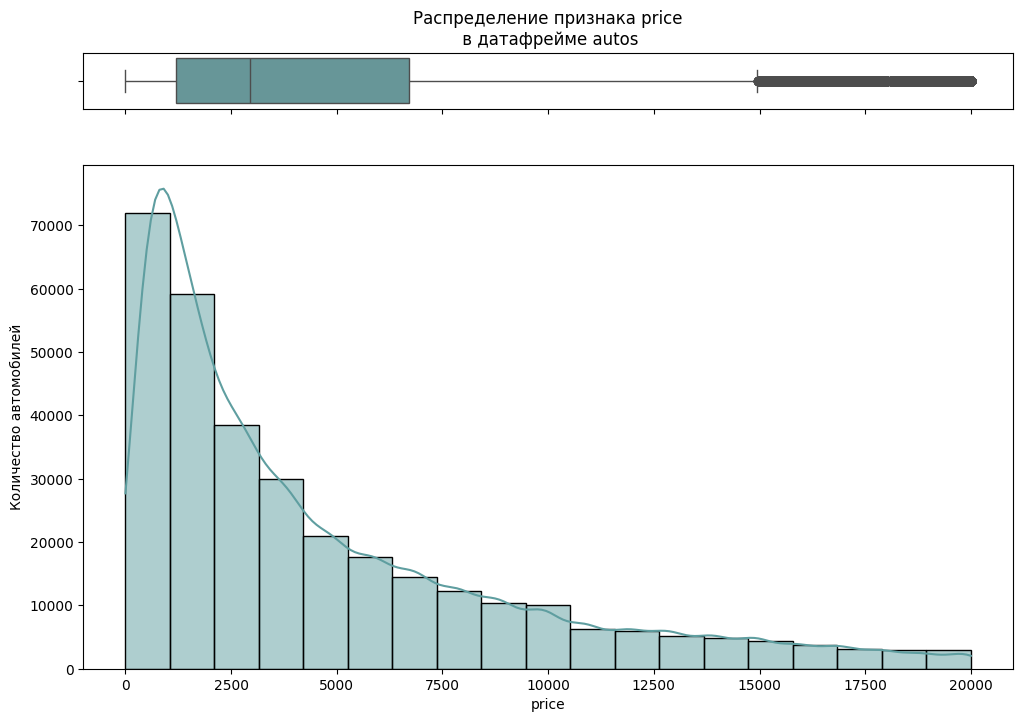

In [81]:
autos.query('price > 0', inplace=True)
quant_feat_analysis(autos, 'price', 'autos')

Возьмём теперь чуть более широкий диапазон - автомобили стоимостью менее 10 евро

In [82]:
autos.query('price < 10').sample(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,reg_year_group,power_log,kilo_group
323664,1,sedan,2000,manual,122.0,carisma,150000,petrol,mitsubishi,yes,2000-04,4.804021,very_high
61103,1,sedan,1986,auto,75.0,jetta,150000,petrol,volkswagen,no,1980-89,4.317488,very_high
85488,1,wagon,1996,manual,193.0,5er,150000,petrol,bmw,no,1995-99,5.262690,very_high
276405,1,small,1988,manual,45.0,corsa,150000,petrol,opel,no,1980-89,3.806662,very_high
329318,1,small,1997,manual,60.0,corsa,125000,petrol,opel,no,1995-99,4.094345,high
34717,1,sedan,1993,manual,132.0,other,150000,petrol,mercedes_benz,yes,1990-94,4.882802,very_high
95606,1,sedan,1995,manual,75.0,astra,5000,petrol,opel,no,1995-99,4.317488,new
408,1,sedan,2000,manual,75.0,golf,90000,petrol,volkswagen,no,2000-04,4.317488,average
330435,1,bus,2003,manual,117.0,touran,150000,petrol,volkswagen,no,2000-04,4.762174,very_high
170976,1,sedan,1995,manual,160.0,a4,150000,petrol,audi,no,1995-99,5.075174,very_high


Проведём грубую прикидку - сравним среднюю стоимость аномальных автомобилей (с ценой менее 10 евро), остальных машин и вообще всех автомобилей в зависимости от бренда

In [83]:
mean_prices_10 = pd.DataFrame({'under_10': autos.query('price < 10').groupby('brand')['price'].mean(),
                               'more_than_10': autos.query('price >= 10').groupby('brand')['price'].mean(),
                               'all': autos.groupby('brand')['price'].mean()})
mean_prices_10.head(30)

,under_10,more_than_10,all
brand,,,
alfa_romeo,1.000000,3923.005690,3900.816124
audi,1.000000,6545.599436,6528.402577
bmw,1.126761,6468.362783,6441.634001
chevrolet,1.000000,5881.658492,5874.456216
chrysler,1.666667,3957.639167,3939.422870
citroen,1.000000,3623.408129,3611.942393
dacia,1.000000,5948.492433,5941.576744
daewoo,1.000000,1040.977505,1038.855102
daihatsu,1.000000,1785.557377,1783.122783


Заметно, что цены между аномальными автомобилями и остальными отличаются в тысячи раз, при этом чем более дорогой бренд, чем больше разница

Проведём аналогичный анализ для автомобилей разных брендов с границей цены в 100, 500 и 1000 евро

In [84]:
mean_prices_100 = pd.DataFrame({'under_100': autos.query('price < 100').groupby('brand')['price'].mean(),
                                'more_than_100': autos.query('price >= 100').groupby('brand')['price'].mean(),
                                'all': autos.groupby('brand')['price'].mean()})
mean_prices_100.head(30)

,under_100,more_than_100,all
brand,,,
alfa_romeo,19.350000,3937.764874,3900.816124
audi,18.100000,6557.039221,6528.402577
bmw,14.120603,6479.078749,6441.634001
chevrolet,36.400000,5892.386364,5874.456216
chrysler,30.909091,3972.699690,3939.422870
citroen,36.486486,3640.077627,3611.942393
dacia,15.500000,5955.390443,5941.576744
daewoo,35.250000,1047.115226,1038.855102
daihatsu,64.076923,1814.161111,1783.122783


In [85]:
mean_prices_500 = pd.DataFrame({'under_500': autos.query('price < 500').groupby('brand')['price'].mean(),
                                'more_than_500': autos.query('price >= 500').groupby('brand')['price'].mean(),
                                'all': autos.groupby('brand')['price'].mean()})
mean_prices_500.head(30)

,under_500,more_than_500,all
brand,,,
alfa_romeo,277.235294,4182.527439,3900.816124
audi,288.611043,6719.684834,6528.402577
bmw,263.139896,6620.181805,6441.634001
chevrolet,262.315789,5940.522305,5874.456216
chrysler,275.621622,4160.026037,3939.422870
citroen,260.153179,3875.934896,3611.942393
dacia,15.500000,5955.390443,5941.576744
daewoo,300.269231,1237.852332,1038.855102
daihatsu,274.435897,2191.017331,1783.122783


In [86]:
mean_prices_1000 = pd.DataFrame({'under_1000': autos.query('price < 1000').groupby('brand')['price'].mean(),
                                'more_than_1000': autos.query('price >= 1000').groupby('brand')['price'].mean(),
                                'all': autos.groupby('brand')['price'].mean()})
mean_prices_1000.head(30)

,under_1000,more_than_1000,all
brand,,,
alfa_romeo,597.170213,4841.284676,3900.816124
audi,620.547207,7271.374856,6528.402577
bmw,598.606098,7058.312407,6441.634001
chevrolet,650.857143,6233.407723,5874.456216
chrysler,623.074324,4914.238332,3939.422870
citroen,581.455984,4433.782994,3611.942393
dacia,756.294118,6046.143535,5941.576744
daewoo,562.892430,1538.715481,1038.855102
daihatsu,533.849432,2937.307087,1783.122783


Наиболее разумной границей выглядит 100 евро - с одной стороны, мы отсекаем наиболее явные аномальные значения (вызванные, например, тем, что человек указывал цену не в фунтах, а в тысячах фунтов), где разница между средними значениями в группах для одного бренда различается в сотни раз, с другой - не убираем слишком много записей, а также не исключаем варианты, когда пользователь действительно хочет продать автомобиль по заниженной цене.

Посмотрим на группу анкет с ценами автомобилей от 100 до 500 евро

In [87]:
autos.query('price >= 100 & price <= 500')['kilo_group'].value_counts()

very_high     21449
high           1875
average        1586
new            1292
almost_new      162
Name: kilo_group, dtype: int64

In [88]:
autos.query('price >= 100 & price <= 500')['reg_year_group'].value_counts()

1995-99        14585
2000-04         5115
1990-94         3409
2015+           2196
1980-89          434
2005-09          421
2010-14          132
before 1980       72
Name: reg_year_group, dtype: int64

In [89]:
autos.query('price >= 100 & price <= 500')['power'].value_counts().head(20)

60.0     4855
75.0     3300
90.0     1860
101.0    1540
45.0     1124
54.0     1070
50.0      958
58.0      749
116.0     740
55.0      696
150.0     608
115.0     541
102.0     384
125.0     361
136.0     352
69.0      318
131.0     311
107.0     290
65.0      245
100.0     223
Name: power, dtype: int64

In [90]:
autos.query('price >= 100 & price <= 500')['brand'].value_counts()

volkswagen        5709
opel              5215
ford              3482
renault           2539
fiat              1286
bmw               1070
audi              1001
peugeot            861
seat               594
nissan             524
mazda              517
mercedes_benz      510
mitsubishi         420
citroen            390
volvo              261
honda              209
alfa_romeo         181
suzuki             178
daihatsu           166
hyundai            143
skoda              124
daewoo             113
subaru             104
chrysler            99
kia                 95
trabant             91
rover               88
lancia              79
toyota              79
smart               65
sonstige_autos      62
saab                34
chevrolet           27
porsche             16
mini                14
lada                 8
jeep                 4
jaguar               3
land_rover           2
dacia                1
Name: brand, dtype: int64

Видим, что в большинстве своём сегмент автомобилей стоимостью от 100 до 500 евро представлен машинами средней ценовой категории с очень высоким пробегом, возрастом не менее 10 лет и не самой высокой мощностью. Вполне можно допустить, что продаваться данные автомобили будут недорого

Итак, удалим только записи для автомобилей дешевле 100 евро. Проверим на всякий случай, не удаляем ли мы слишком много записей

In [91]:
autos.query('price < 100').shape

(2065, 13)

Менее 1% записей - не столь критично

Базовые статистики

count    322823.000000
mean       4671.705309
std        4553.505546
min         100.000000
25%        1250.000000
50%        2990.000000
75%        6750.000000
max       20000.000000
Name: price, dtype: float64
-----------------------------------------------------


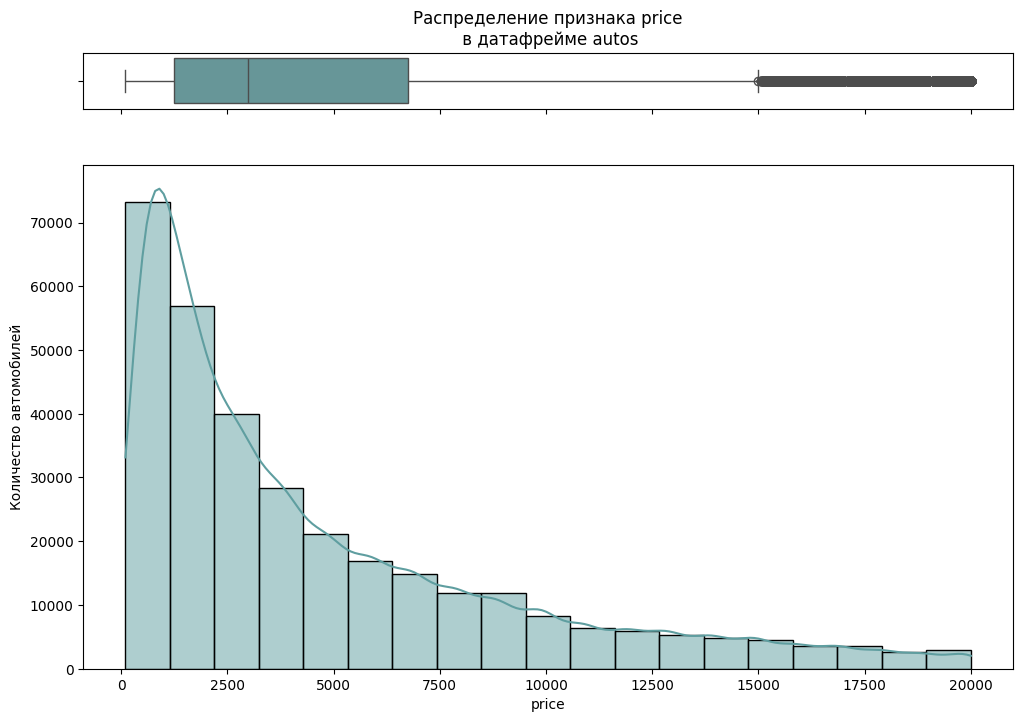

In [92]:
autos.query('price >= 100', inplace=True)
quant_feat_analysis(autos, 'price', 'autos')

Посмотрим, наконец, на очень дорогие автомобили, отмеченные боксплотом как выбросы

In [93]:
autos.query('price > 15000').shape

(14594, 13)

In [94]:
autos.query('price > 15000').sample(30)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,reg_year_group,power_log,kilo_group
125362,15500,sedan,2009,auto,211.0,golf,90000,petrol,volkswagen,no,2005-09,5.351858,average
28154,17750,wagon,2009,auto,161.0,a3,80000,petrol,audi,no,2005-09,5.081404,average
127590,19500,other,2012,auto,141.0,qashqai,50000,petrol,nissan,no,2010-14,4.948760,almost_new
275940,17250,sedan,2013,manual,156.0,a_klasse,50000,petrol,mercedes_benz,no,2010-14,5.049856,almost_new
202110,15450,convertible,2011,manual,140.0,eos,100000,petrol,volkswagen,no,2010-14,4.941642,average
316916,15700,coupe,2010,auto,170.0,passat,100000,petrol,volkswagen,no,2010-14,5.135798,average
94753,19999,suv,2008,auto,204.0,x_reihe,150000,petrol,bmw,no,2005-09,5.318120,very_high
157207,16299,convertible,2009,manual,170.0,3er,100000,petrol,bmw,no,2005-09,5.135798,average
38661,17900,sedan,2006,manual,230.0,5er,90000,petrol,bmw,no,2005-09,5.438079,average
352709,15990,coupe,1964,auto,250.0,other,5000,petrol,chevrolet,no,before 1980,5.521461,new


Проведём более детальный анализ данной группы автомобилей

In [95]:
autos.query('price > 15000')['power'].value_counts().head(20)

170.0    1146
140.0    1064
184.0     617
143.0     608
150.0     535
122.0     502
105.0     456
204.0     380
160.0     368
177.0     367
211.0     361
163.0     341
136.0     327
190.0     310
231.0     303
200.0     291
235.0     272
239.0     271
224.0     261
110.0     229
Name: power, dtype: int64

In [96]:
autos.query('price > 15000')['brand'].value_counts()

volkswagen        3011
bmw               2662
audi              2432
mercedes_benz     2401
ford               610
opel               420
mini               407
skoda              274
sonstige_autos     222
nissan             210
porsche            205
seat               184
hyundai            149
volvo              142
kia                131
peugeot            125
renault            124
toyota             121
mazda              110
chevrolet           90
land_rover          81
jeep                61
citroen             55
mitsubishi          54
jaguar              53
fiat                50
alfa_romeo          47
honda               35
chrysler            34
subaru              29
suzuki              22
smart               17
dacia               11
saab                10
lancia               4
rover                1
Name: brand, dtype: int64

In [97]:
autos.query('price > 15000')['repaired'].value_counts()

no     14382
yes      212
Name: repaired, dtype: int64

In [98]:
autos.query('price > 15000')['reg_year_group'].value_counts()

2010-14        8222
2005-09        4595
2015+           524
2000-04         519
before 1980     344
1995-99         143
1980-89         139
1990-94         108
Name: reg_year_group, dtype: int64

In [99]:
autos.query('price > 15000')['kilo_group'].value_counts()

average       5005
very_high     4029
new           1981
almost_new    1923
high          1656
Name: kilo_group, dtype: int64

Видим, что в большинстве своём автомобили данной ценовой категории новые или практические новые, не ремонтировались, имеют высокую мощность, меньший по сравнению со всеми автомобилями пробег и в целом представлены дорогими брендами. Нет ничего удивительного, что данные автомобили продаются по цене выше рынка, удалять такие анкеты не будем

Посмотрим, наконец, что получилось в результате EDA

In [100]:
df_basic_info(autos)

Названия столбцов

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired',
       'reg_year_group', 'power_log', 'kilo_group'],
      dtype='object')
----------------------------------------------------------------
Основные параметры данных


<class 'pandas.core.frame.DataFrame'>
Int64Index: 322823 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              322823 non-null  int32   
 1   vehicle_type       322823 non-null  object  
 2   registration_year  322823 non-null  int32   
 3   gearbox            322823 non-null  object  
 4   power              322823 non-null  float64 
 5   model              322823 non-null  object  
 6   kilometer          322823 non-null  int32   
 7   fuel_type          322823 non-null  object  
 8   brand              322823 non-null  object  
 9   repaired   

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,reg_year_group,power_log,kilo_group
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,no,1990-94,4.615121,very_high
1,18300,coupe,2011,manual,190.0,other,125000,petrol,audi,yes,2010-14,5.247024,high
2,9800,suv,2004,auto,163.0,grand,125000,petrol,jeep,no,2000-04,5.093750,high
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,2000-04,4.317488,very_high
4,3600,small,2008,manual,69.0,fabia,90000,petrol,skoda,no,2005-09,4.234107,average
5,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,1995-99,4.624973,very_high
6,2200,convertible,2004,manual,109.0,2_reihe,150000,petrol,peugeot,no,2000-04,4.691348,very_high
8,14500,bus,2014,manual,125.0,c_max,30000,petrol,ford,no,2010-14,4.828314,new
9,999,small,1998,manual,101.0,golf,150000,petrol,volkswagen,no,1995-99,4.615121,very_high
10,2000,sedan,2004,manual,105.0,3_reihe,150000,petrol,mazda,no,2000-04,4.653960,very_high


После EDA появилось большое количество полных дубликатов. Удалим их

In [101]:
autos.drop_duplicates(inplace=True)
df_basic_info(autos)

Названия столбцов

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired',
       'reg_year_group', 'power_log', 'kilo_group'],
      dtype='object')
----------------------------------------------------------------
Основные параметры данных


<class 'pandas.core.frame.DataFrame'>
Int64Index: 266101 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              266101 non-null  int32   
 1   vehicle_type       266101 non-null  object  
 2   registration_year  266101 non-null  int32   
 3   gearbox            266101 non-null  object  
 4   power              266101 non-null  float64 
 5   model              266101 non-null  object  
 6   kilometer          266101 non-null  int32   
 7   fuel_type          266101 non-null  object  
 8   brand              266101 non-null  object  
 9   repaired   

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,reg_year_group,power_log,kilo_group
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,no,1990-94,4.615121,very_high
1,18300,coupe,2011,manual,190.0,other,125000,petrol,audi,yes,2010-14,5.247024,high
2,9800,suv,2004,auto,163.0,grand,125000,petrol,jeep,no,2000-04,5.093750,high
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,2000-04,4.317488,very_high
4,3600,small,2008,manual,69.0,fabia,90000,petrol,skoda,no,2005-09,4.234107,average
5,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,1995-99,4.624973,very_high
6,2200,convertible,2004,manual,109.0,2_reihe,150000,petrol,peugeot,no,2000-04,4.691348,very_high
8,14500,bus,2014,manual,125.0,c_max,30000,petrol,ford,no,2010-14,4.828314,new
9,999,small,1998,manual,101.0,golf,150000,petrol,volkswagen,no,1995-99,4.615121,very_high
10,2000,sedan,2004,manual,105.0,3_reihe,150000,petrol,mazda,no,2000-04,4.653960,very_high


Проверим теперь датафрейм на наличие неявных дубликатов - без учёта таргета

In [102]:
autos[autos.duplicated(subset=['vehicle_type',                        
                               'registration_year',                       
                               'gearbox',                    
                               'power',           
                               'model',          
                               'kilometer',       
                               'fuel_type',       
                               'brand',      
                               'repaired',
                               'reg_year_group',
                               'power_log',
                               'kilo_group']
                        )
             ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146345 entries, 237 to 354367
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              146345 non-null  int32   
 1   vehicle_type       146345 non-null  object  
 2   registration_year  146345 non-null  int32   
 3   gearbox            146345 non-null  object  
 4   power              146345 non-null  float64 
 5   model              146345 non-null  object  
 6   kilometer          146345 non-null  int32   
 7   fuel_type          146345 non-null  object  
 8   brand              146345 non-null  object  
 9   repaired           146345 non-null  object  
 10  reg_year_group     146345 non-null  category
 11  power_log          146345 non-null  float64 
 12  kilo_group         146345 non-null  category
dtypes: category(2), float64(2), int32(3), object(6)
memory usage: 12.0+ MB


Удаление признаков с большИм количеством уникальных значений привело к тому, что больше половины данных теперь является дубликатами. Это может привести к завышению метрики на кросс-валидации, если неявные дубликаты попадут одновременно в тренировочную и валидационную выборку.

С другой стороны, не очень хочется удалять больше половины данных, с учётом того, что и так уже было удалено около 25% записей от исходного числа.

Поэтому попробуем обучить модели на тех данных, что имеются. Если не удастся достигнуть приемлемого качества на тестовых данных, будем решать данную особенность датафрейма

Таким образом, в данном разделе был проведён исследовательский анализ данных:
* проведён анализ признакового описания и таргета;
* удалены малоинформативные признаки `date_crawled`, `registration_month`, `date_created`, `number_of_pictures`, `postal_code`  и `last_seen`;
* на основе признаков `registration_year` и `kilometer` созданы категориальные признаки `reg_year_group` и `kilo_group` соответственно;
* проведена логарифмическая трансформация признака `power` с образованием признака `power_log`;
* удалены полные дубликаты и аномальные значения;
* пропущенные значения заполнены наиболее оптимальным образом в зависимости от распределения признака и типа данных;
* отмечена смещённость распределения таргета вправо ввиду наличия большого числа дорогостоящих автомобилей;
* отмечена неравномерность распределения значений внутри категорий для категориальных признаков

## Корреляционный анализ

Проведём корреляционный анализ наших данных. Сначала изучим корреляции между количественными признаками с использованием коэффиицента Спирмена - посмотрим на линейные зависимости

In [103]:
num_cols = list(autos.select_dtypes(include=['int32', 'float64']))
cat_cols = list(autos.select_dtypes(exclude=['int32', 'float64']))

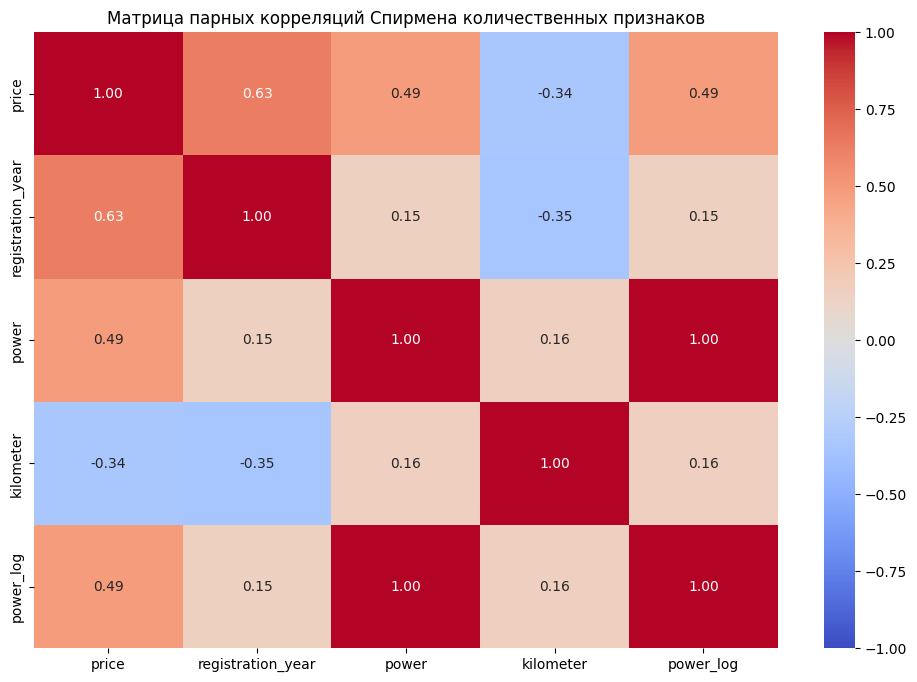

In [104]:
corr_df_spearman = autos[num_cols].corr(method='spearman')
sns.heatmap(corr_df_spearman,
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций Спирмена количественных признаков');

Судя по данным матрицы корреляций, мультиколлинеарности между количественнымии признаками не наблюдается (за исключением `power` и `power_log` в силу генерации второго на основе первого). Наибольшую корреляцию с таргетом имеет признак `registration_year` (0.63, сильная прямая связь),  признаки `power` и `power_log` имеют среднюю связь с таргетом (0.49)

Однако будем иметь в виду, что к этим значениям стоит относиться с осторожностью ввиду ненормальности распределения исходных  признаков

Теперь проведём корреляционный анализ с помощью библиотеки `phik` - у нас в данных большинство признаков категориальные, это поможет уловить более глубокие закономерности между данными

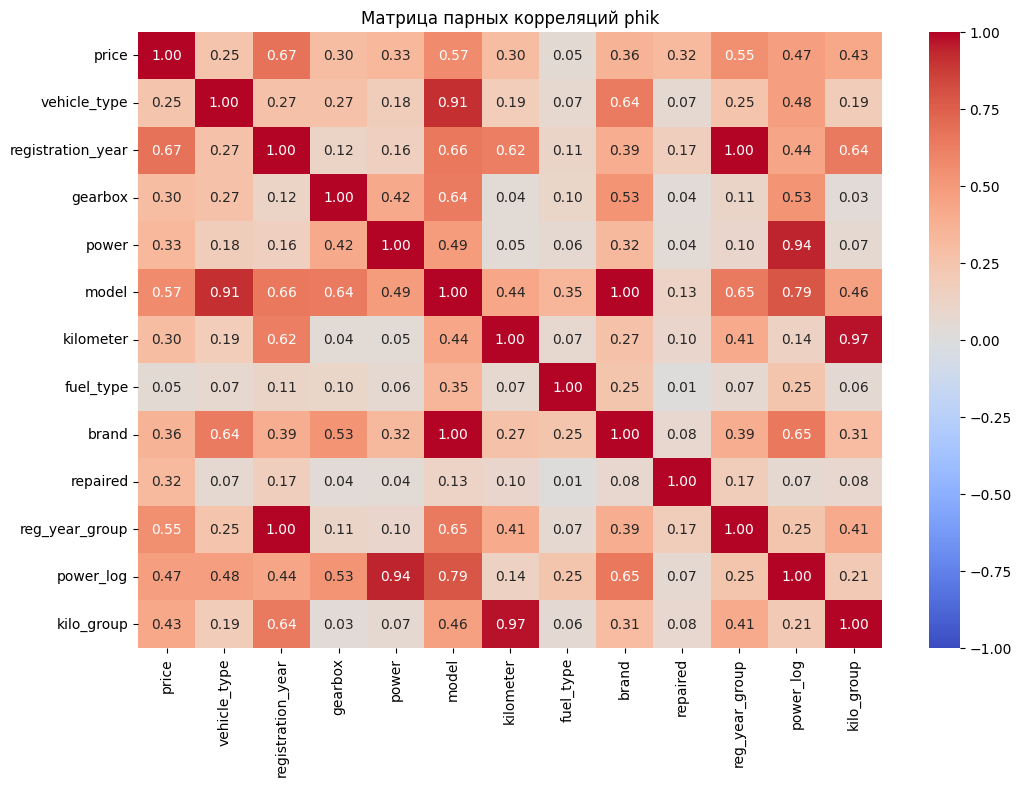

In [105]:
#рассчитаем коэффициенты корреляции phik между всеми признаками
sns.heatmap(autos.phik_matrix(interval_cols=['price',
                                             'power',
                                             'kilometer',
                                             'power_log']),
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций phik');

Отметим самые высокие значения корреляций признаков с таргетом:
* `registration_year`: 0.67, сильная связь;
* `model`: 0.57, средняя связь;
* `reg_year_group`: 0.55, средняя связь;
* `power_log`: 0.47, средняя связь;
* `kilo_group`: 0.43, средняя связь

Мультиколлинеарность наблюдается между исходными и сгенерированными на их основе признаками. 

* В паре `registration_year` и `reg_year_group` выберем для обучения моделей `registration_year` ввиду более сильных связей с таргетом и остальными признаками. Вероятно, не очень удачно была подобрана группировка для годов;
* в паре `power` и `power_log` выберем признак `power_log` по тем же причинам - логарифмическая трансформация позитивна сказалась на силе признака;
* в паре `kilometer` и  `kilo_group` выберем признак `kilo_group`. В данном случае группировка значений признака привела к усилению связей

Также важно отметить, что у признака `model` мультиколлинеарность сразу с двумя признаками - `vehicle_type` (0.91) и `brand` (1.00). Несмотря на то, что данный признак имеет высокие значения корреляций почти со всеми признаками (в том числе с таргетом), удалим его, чтобы улучшить качество работы моделей. Кроме того, вспомним, что в этом признаке у нас наиболее популярная категория модели `other`, что не является хорошим предсказательным свойством

Также стоит отметить наиболее высокие значения коэффиицентов корреляций между остальными признаками:
* `brand` и `vehicle_type` - 0.64, сильная связь;
* `power_log` и `brand` - 0.65, сильная связь;
* `kilo_group` и `registration_year` - 0.64, сильная связь

Кроме того, посмотрим, какие признаки имеют более сильную связь между собой для наиболее высоких и наиболее низких значений таргета

In [106]:
price_q_90 = autos['price'].quantile(0.9)
price_q_10 = autos['price'].quantile(0.1)

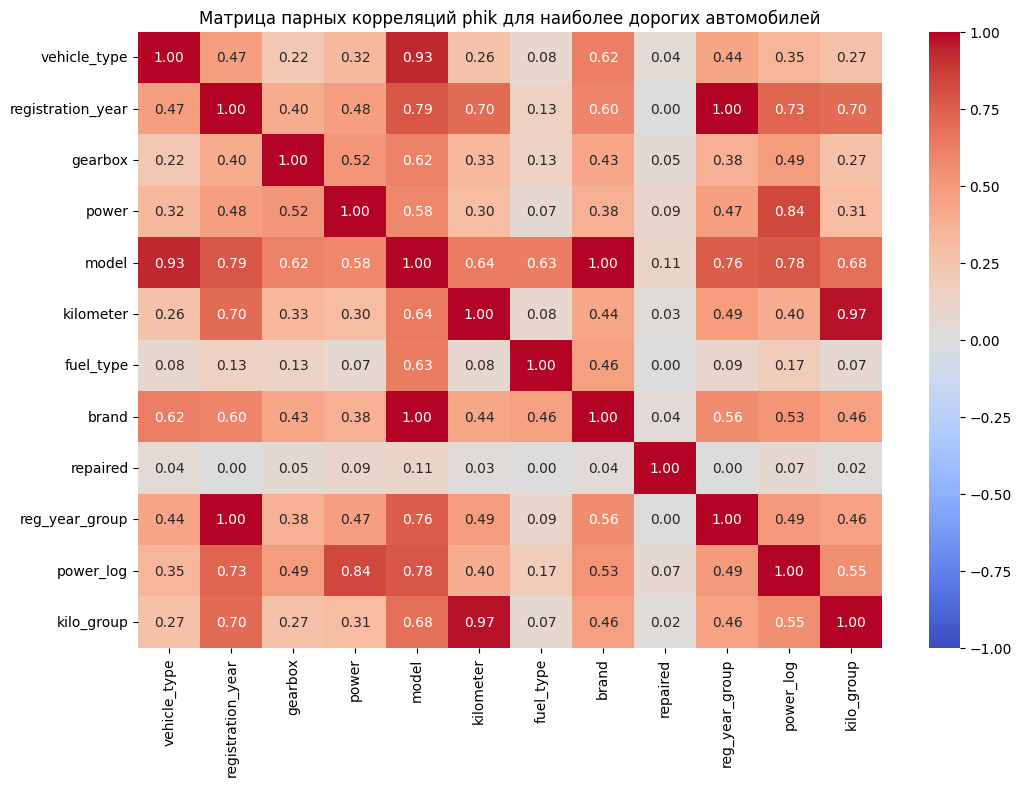

In [107]:
#рассчитаем коэффициенты корреляции между признаками
#для наиболее дорогих автомобилей
sns.heatmap(autos.query('price >= @price_q_90')
                 .loc[:, autos.columns != 'price']
                 .phik_matrix(interval_cols=['power',
                                             'kilometer',
                                             'power_log']),
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций phik для наиболее дорогих автомобилей');

Можно отметить усиление корреляций для признаков `power_log` и `kilo_group` - как мы отмечали ранее, действительно, дорогие автомобили имеют мощный двигатель и низкий пробег

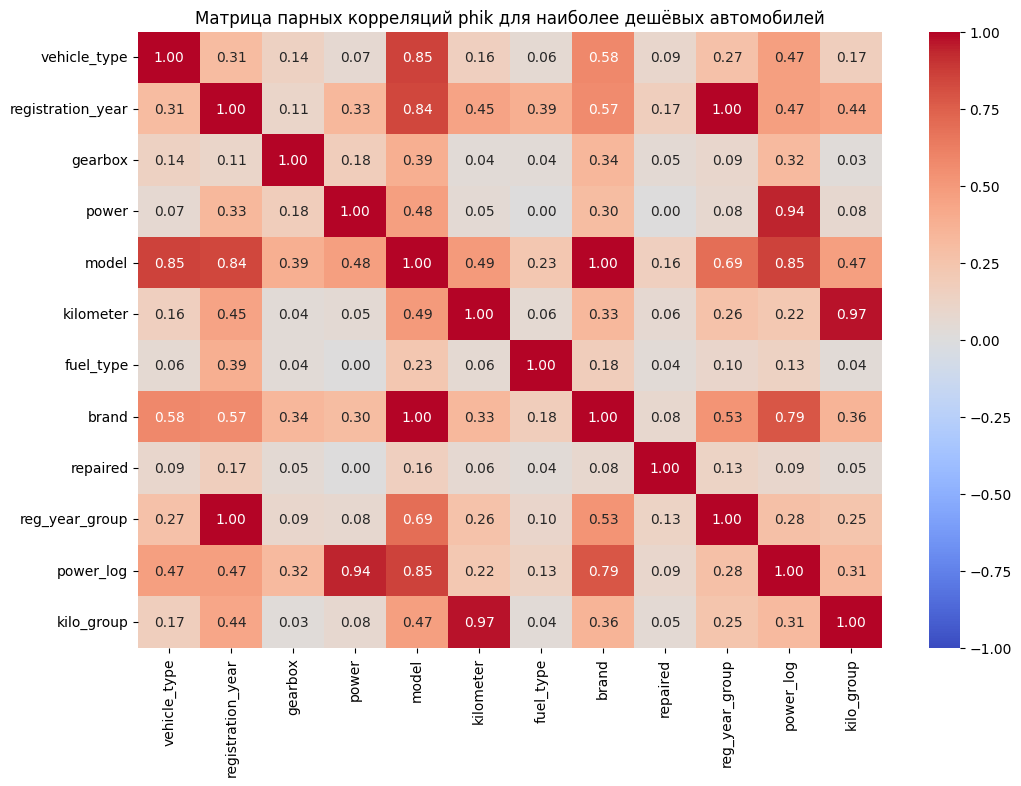

In [108]:
#рассчитаем коэффициенты корреляции между признаками
#для наиболее дешёвых автомобилей
sns.heatmap(autos.query('price <= @price_q_10')
                 .loc[:, autos.columns != 'price']
                 .phik_matrix(interval_cols=['power',
                                             'kilometer',
                                             'power_log']),
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций phik для наиболее дешёвых автомобилей');

Для наиболее дешёвых автомобилей нельзя выделить какие-то значимые изменения в сравнении с данными по всему датафрейму

Таким образом, для данного датафрейма был проведён корреляционный анализ данных:
* анализ линейных зависимостей количественных признаков с помощью корреляций Спирмена показал, что наибольшую корреляцию с таргетом имеет признак `registration_year` (0.63, сильная прямая связь);
* расширенный анализ зависимостей всех признаков с помощью корреляций `phik` показал наибольшую корреляцию с таргетом признаков `registration_year` (0.67, сильная связь), `model` (0.57, средняя связь), `reg_year_group` (0.55, средняя связь), `power_log` (0.47, средняя связь), `kilo_group` (0.43, средняя связь);
* из коррелирующих между собой признаков выберем для обучения моделей `registration_year`, `power_log` и `kilo_group`. Кроме того, исключим признак `model` ввиду мультиколлинеарности с двумя признаками;
* для наиболее дорогих автомобилей отметим усиление корреляций для признаков `power_log` и `kilo_group`

## Подготовка данных и обучение моделей

Удалим признаки, которые не будем использовать для обучения

In [109]:
#сохраним данные для обучения в датафрейм autos_fin
autos_fin = autos.drop(['model', 'kilometer', 'power', 'reg_year_group'], axis=1)
df_basic_info(autos_fin)

Названия столбцов

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'fuel_type',
       'brand', 'repaired', 'power_log', 'kilo_group'],
      dtype='object')
----------------------------------------------------------------
Основные параметры данных


<class 'pandas.core.frame.DataFrame'>
Int64Index: 266101 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              266101 non-null  int32   
 1   vehicle_type       266101 non-null  object  
 2   registration_year  266101 non-null  int32   
 3   gearbox            266101 non-null  object  
 4   fuel_type          266101 non-null  object  
 5   brand              266101 non-null  object  
 6   repaired           266101 non-null  object  
 7   power_log          266101 non-null  float64 
 8   kilo_group         266101 non-null  category
dtypes: category(1), float64(1), int32(2), object(5)
memory usage: 16.5+ 

,price,vehicle_type,registration_year,gearbox,fuel_type,brand,repaired,power_log,kilo_group
0,480,sedan,1993,manual,petrol,volkswagen,no,4.615121,very_high
1,18300,coupe,2011,manual,petrol,audi,yes,5.247024,high
2,9800,suv,2004,auto,petrol,jeep,no,5.093750,high
3,1500,small,2001,manual,petrol,volkswagen,no,4.317488,very_high
4,3600,small,2008,manual,petrol,skoda,no,4.234107,average
5,650,sedan,1995,manual,petrol,bmw,yes,4.624973,very_high
6,2200,convertible,2004,manual,petrol,peugeot,no,4.691348,very_high
8,14500,bus,2014,manual,petrol,ford,no,4.828314,new
9,999,small,1998,manual,petrol,volkswagen,no,4.615121,very_high
10,2000,sedan,2004,manual,petrol,mazda,no,4.653960,very_high


In [110]:
#удалим явные дубликаты
autos_fin.drop_duplicates(inplace=True)
df_basic_info(autos_fin)

Названия столбцов

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'fuel_type',
       'brand', 'repaired', 'power_log', 'kilo_group'],
      dtype='object')
----------------------------------------------------------------
Основные параметры данных


<class 'pandas.core.frame.DataFrame'>
Int64Index: 255854 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              255854 non-null  int32   
 1   vehicle_type       255854 non-null  object  
 2   registration_year  255854 non-null  int32   
 3   gearbox            255854 non-null  object  
 4   fuel_type          255854 non-null  object  
 5   brand              255854 non-null  object  
 6   repaired           255854 non-null  object  
 7   power_log          255854 non-null  float64 
 8   kilo_group         255854 non-null  category
dtypes: category(1), float64(1), int32(2), object(5)
memory usage: 15.9+ 

,price,vehicle_type,registration_year,gearbox,fuel_type,brand,repaired,power_log,kilo_group
0,480,sedan,1993,manual,petrol,volkswagen,no,4.615121,very_high
1,18300,coupe,2011,manual,petrol,audi,yes,5.247024,high
2,9800,suv,2004,auto,petrol,jeep,no,5.093750,high
3,1500,small,2001,manual,petrol,volkswagen,no,4.317488,very_high
4,3600,small,2008,manual,petrol,skoda,no,4.234107,average
5,650,sedan,1995,manual,petrol,bmw,yes,4.624973,very_high
6,2200,convertible,2004,manual,petrol,peugeot,no,4.691348,very_high
8,14500,bus,2014,manual,petrol,ford,no,4.828314,new
9,999,small,1998,manual,petrol,volkswagen,no,4.615121,very_high
10,2000,sedan,2004,manual,petrol,mazda,no,4.653960,very_high


Разобьём данные на тренировочную, валидационную и тестовую выборки

In [111]:
X = autos_fin.drop(['price'], axis=1)
y = autos_fin['price']

In [112]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=123)

#проверим корректность разбиения на выборки
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((153512, 8), (51171, 8), (51171, 8), (153512,), (51171,), (51171,))

Разбиение на выборки произведено успешно. Создадим группы признаков в соответствии с их типами данных

In [113]:
num_cols = list(X.select_dtypes(include=['int32', 'float64']))
cat_cols = list(X.select_dtypes(exclude=['int32', 'float64']))
num_cols, cat_cols

(['registration_year', 'power_log'],
 ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired', 'kilo_group'])

Создадим пайплайн. 

В качестве метрики была выбрана `RMSE`. Исходные данные были разделены на признаковое описание и целевую переменную, впоследствии - на тренировочную, валидационную и тестовую выборку.

Исходные признаки были разделены на категориальные номинальные (`cat_cols`) и количественные (`num_cols`). Категориальные признаки предобработаем с помощью `OneHotEncoder` (номинальные признаки) с заполнением пропусков с помощью `SimpleImputer`. Для модели `CatBoostRegressor` категориальные признаки обрабатывать не будем, передадим их напрямую в модель. Для количественных признаков используем маштабирование с помощью `StandardScaler`.

Будем исследовать 10 регрессионных моделей с перебором одного или нескольких гиперпараметров:

* *DummyRegressor*. Получим предсказания дамми-регрессора для оценки качества работы основных моделей;
* *KNeighborsRegressor*. Проварьируем количество ближайших соседей и параметр взвешивания весов для нахождения баланса между сложностью модели и качеством;
* *DecisionTreeRegressor*. Проварьируем максимальную глубину дерева, минимальное количество объектов в листе, минимальное количество объектов в разделяемом листе для определения оптимальной структуры одиночного дерева;
* *RandomForestRegressor*. Проварьируем число деревьев, поскольку от их количества напрямую зависит предсказательная способность леса; также проварьируем максимальную глубину дерева, минимальное количество объектов в листе, минимальное количество объектов в разделяемом листе для определения оптимальной структуры одиночного дерева в ансамбле;
* *Ridge и Lasso*. Проварьируем для этих двух моделей параметр `gamma` для построения оптимальной разделяющей поверхности;
* *ElasticNet*. Проварьируем параметр `gamma` и соотношение типов регуляризаций для нахождения оптимального баланса между `Lasso` и `Ridge` регрессиями;
* *LGBMRegressor, CatBoostRegressor, XGBoostRegressor*. Для трёх мощных моделей, основанных на градиентном бустинге, проварьируем количество деревьев в ансамбле, максимальную глубину дерева и скорость обучения для определения оптимального ансамбля решающих деревьев. Также сравним модели между собой;

Оптимизацию гиперпараметров будем проводить с помощью `optuna`. Для каждой модели индивидуально подберём количество итераций ввиду различной скорости обучения и предсказания. Качество моделей определим по метрике `RMSE` на валидационных данных. Лучшие модели затем будут исследоваться более глубоко. Успешным считается значение метрики `RMSE<=2500`, также важным является время работы модели. Также качество модели проверим сравнением с метрикой для `DummyRegressor`

In [114]:
#создаём пайплайн для подготовки признаков из списка cat_cols:
#заполнение пропусков модой и OHE-кодирование
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

#создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_cols),
     ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)


#создадим списки с названиями моделей, метриками на тренировочных данных
#и затраченным на все операции временем
regr_models_list = []
regr_metrics_list = []
regr_time_list = []

### Исследование моделей

#### DummyRegressor

In [115]:
#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DummyRegressor())
    ]
)

# запускаем таймер
start = time.time()

#объявляем обучение пайплайна
pipe_final.fit(X_train, y_train)

#получаем предсказания
y_pred_dummy = pipe_final.predict(X_valid)

# считаем, сколько секунд прошло с начала запуска
regr_time_list.append(time.time() - start)

#проверяем работу модели на валидационной выборке
print('Параметры DummyRegressor:\n\n', pipe_final.get_params())
print('Метрика DummyRegressor на валидационной выборке:', root_mean_squared_error(y_valid, y_pred_dummy))

regr_models_list.append('Dummy')
regr_metrics_list.append(root_mean_squared_error(y_valid, y_pred_dummy))

Параметры DummyRegressor:

 {'memory': None, 'steps': [('preprocessor', ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['vehicle_type', 'gearbox', 'fuel_type',
                                  'brand', 'repaired', 'kilo_group']),
                                ('num', StandardScaler(),
                                 ['registration_year', 'power_log'])])), ('models', DummyRegressor())], 'transform_input': None, 'verbose': False, 'preprocessor': Col

#### Lasso

In [116]:
#создаём функцию для оптимизации гиперпараметров Lasso
def objective_lasso(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 1e3, log=True)
    
    regr_lasso = Pipeline(steps=[
        ('preprocessor', data_preprocessor),
        ('regressor', Lasso(alpha=alpha))
    ])
    
    regr_lasso.fit(X_train, y_train)
    y_pred_lasso = regr_lasso.predict(X_valid)
    
    return (root_mean_squared_error(y_valid, y_pred_lasso))

In [117]:
# запускаем таймер
start = time.time()
        
# запускаем оптимизацию    
study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=15)

# считаем, сколько секунд прошло с начала запуска
regr_time_list.append(time.time() - start)

#проверяем работу модели на валидационной выборке
print('Гиперпараметры лучшей модели:', study_lasso.best_params)
print('Метрика лучшей модели на валидационной выборке:', study_lasso.best_value)

regr_models_list.append('Lasso')
regr_metrics_list.append(study_lasso.best_value)

[I 2025-09-13 15:47:32,473] A new study created in memory with name: no-name-17d3e1e7-c0ac-46c0-bc0f-1a421b9d1972
[I 2025-09-13 15:47:33,562] Trial 0 finished with value: 3075.4256983132314 and parameters: {'alpha': 0.8929284159808919}. Best is trial 0 with value: 3075.4256983132314.
[I 2025-09-13 15:47:36,831] Trial 1 finished with value: 3074.063757832226 and parameters: {'alpha': 0.02612368669667331}. Best is trial 1 with value: 3074.063757832226.
[I 2025-09-13 15:47:41,482] Trial 2 finished with value: 3074.0807792638984 and parameters: {'alpha': 0.0010921599416958995}. Best is trial 1 with value: 3074.063757832226.
[I 2025-09-13 15:47:46,677] Trial 3 finished with value: 3074.081503136338 and parameters: {'alpha': 0.00021411363319835073}. Best is trial 1 with value: 3074.063757832226.
[I 2025-09-13 15:47:47,624] Trial 4 finished with value: 3081.047447012049 and parameters: {'alpha': 2.399524329936161}. Best is trial 1 with value: 3074.063757832226.
[I 2025-09-13 15:47:48,424] Tri

Гиперпараметры лучшей модели: {'alpha': 0.0955967493644388}
Метрика лучшей модели на валидационной выборке: 3074.0236197348863


#### Ridge

In [118]:
#создаём функцию для оптимизации гиперпараметров Ridge
def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 1e3, log=True)
    
    regr_ridge = Pipeline(steps=[
        ('preprocessor', data_preprocessor),
        ('regressor', Ridge(alpha=alpha))
    ])
    
    regr_ridge.fit(X_train, y_train)
    y_pred_ridge = regr_ridge.predict(X_valid)
    
    return (root_mean_squared_error(y_valid, y_pred_ridge))

In [119]:
# запускаем таймер
start = time.time()
        
# запускаем оптимизацию    
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=15)

# считаем, сколько секунд прошло с начала запуска
regr_time_list.append(time.time() - start)

#проверяем работу модели на валидационной выборке
print('Гиперпараметры лучшей модели:', study_ridge.best_params)
print('Метрика лучшей модели на валидационной выборке:', study_ridge.best_value)

regr_models_list.append('Ridge')
regr_metrics_list.append(study_ridge.best_value)

[I 2025-09-13 15:48:16,938] A new study created in memory with name: no-name-d15182ef-68b7-40a7-8b2b-d6add61ac4d0
[I 2025-09-13 15:48:17,647] Trial 0 finished with value: 3074.0815273900294 and parameters: {'alpha': 0.026667597537526743}. Best is trial 0 with value: 3074.0815273900294.
[I 2025-09-13 15:48:18,319] Trial 1 finished with value: 3074.081674422661 and parameters: {'alpha': 0.0011260486994889793}. Best is trial 0 with value: 3074.0815273900294.
[I 2025-09-13 15:48:18,979] Trial 2 finished with value: 3074.0811411119616 and parameters: {'alpha': 0.09579897041593059}. Best is trial 2 with value: 3074.0811411119616.
[I 2025-09-13 15:48:19,649] Trial 3 finished with value: 3082.011900166523 and parameters: {'alpha': 253.18239107492226}. Best is trial 2 with value: 3074.0811411119616.
[I 2025-09-13 15:48:20,324] Trial 4 finished with value: 3074.081199306981 and parameters: {'alpha': 0.08518634318906389}. Best is trial 2 with value: 3074.0811411119616.
[I 2025-09-13 15:48:20,998]

Гиперпараметры лучшей модели: {'alpha': 2.100779598876403}
Метрика лучшей модели на валидационной выборке: 3074.0766531175245


#### ElasticNet

In [120]:
#создаём функцию для оптимизации гиперпараметров ElasticNet
def objective_enet(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 1e3, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.05, 0.95, step=0.1)
    
    regr_enet = Pipeline(steps=[
        ('preprocessor', data_preprocessor),
        ('regressor', ElasticNet(alpha=alpha,
                                 l1_ratio=l1_ratio, 
                                 random_state=123))
    ])
    
    regr_enet.fit(X_train, y_train)
    y_pred_enet = regr_enet.predict(X_valid)
    
    return (root_mean_squared_error(y_valid, y_pred_enet))

In [121]:
# запускаем таймер
start = time.time()
        
# запускаем оптимизацию    
study_enet = optuna.create_study(direction='minimize')
study_enet.optimize(objective_enet, n_trials=15)

# считаем, сколько секунд прошло с начала запуска
regr_time_list.append(time.time() - start)

#проверяем работу модели на валидационной выборке
print('Гиперпараметры лучшей модели:', study_enet.best_params)
print('Метрика лучшей модели на валидационной выборке:', study_enet.best_value)

regr_models_list.append('ElasticNet')
regr_metrics_list.append(study_enet.best_value)

[I 2025-09-13 15:48:27,121] A new study created in memory with name: no-name-31900f2b-ac88-4e4a-a71b-cf901df9c168
[I 2025-09-13 15:48:30,825] Trial 0 finished with value: 3074.3918773257055 and parameters: {'alpha': 0.00020107045594220182, 'l1_ratio': 0.25}. Best is trial 0 with value: 3074.3918773257055.
[I 2025-09-13 15:48:31,878] Trial 1 finished with value: 3110.1967019826357 and parameters: {'alpha': 0.0218958275181412, 'l1_ratio': 0.6500000000000001}. Best is trial 0 with value: 3074.3918773257055.
[I 2025-09-13 15:48:33,760] Trial 2 finished with value: 3075.3593784057944 and parameters: {'alpha': 0.007661196863798118, 'l1_ratio': 0.95}. Best is trial 0 with value: 3074.3918773257055.
[I 2025-09-13 15:48:34,576] Trial 3 finished with value: 3325.6852715315667 and parameters: {'alpha': 2.759273748075866, 'l1_ratio': 0.95}. Best is trial 0 with value: 3074.3918773257055.
[I 2025-09-13 15:48:35,354] Trial 4 finished with value: 4123.066087566991 and parameters: {'alpha': 3.85157682

Гиперпараметры лучшей модели: {'alpha': 1.1623864271267186e-05, 'l1_ratio': 0.05}
Метрика лучшей модели на валидационной выборке: 3074.0765944001596


#### kNN

In [122]:
#создаём функцию для оптимизации гиперпараметров kNN
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    regr_knn = Pipeline(steps=[
        ('preprocessor', data_preprocessor),
        ('regressor', KNeighborsRegressor(n_neighbors=n_neighbors,
                                          weights=weights))
    ])
    
    regr_knn.fit(X_train, y_train)
    y_pred_knn = regr_knn.predict(X_valid)
    
    return (root_mean_squared_error(y_valid, y_pred_knn))

In [123]:
# запускаем таймер
start = time.time()
        
# запускаем оптимизацию    
study_knn = optuna.create_study(direction='minimize')
study_knn.optimize(objective_knn, n_trials=15)

# считаем, сколько секунд прошло с начала запуска
regr_time_list.append(time.time() - start)

#проверяем работу модели на валидационной выборке
print('Гиперпараметры лучшей модели:', study_knn.best_params)
print('Метрика лучшей модели на валидационной выборке:', study_knn.best_value)

regr_models_list.append('kNN')
regr_metrics_list.append(study_knn.best_value)

[I 2025-09-13 15:49:10,371] A new study created in memory with name: no-name-c2a2108d-a473-41e2-8f5b-bf9e5d6b5dd6
[I 2025-09-13 15:49:23,093] Trial 0 finished with value: 1970.1258255385196 and parameters: {'n_neighbors': 15, 'weights': 'uniform'}. Best is trial 0 with value: 1970.1258255385196.
[I 2025-09-13 15:49:35,443] Trial 1 finished with value: 1942.052088382494 and parameters: {'n_neighbors': 16, 'weights': 'distance'}. Best is trial 1 with value: 1942.052088382494.
[I 2025-09-13 15:49:47,572] Trial 2 finished with value: 1948.4367100576544 and parameters: {'n_neighbors': 11, 'weights': 'distance'}. Best is trial 1 with value: 1942.052088382494.
[I 2025-09-13 15:49:59,711] Trial 3 finished with value: 1942.9571304582764 and parameters: {'n_neighbors': 15, 'weights': 'distance'}. Best is trial 1 with value: 1942.052088382494.
[I 2025-09-13 15:50:11,915] Trial 4 finished with value: 1942.9795864786047 and parameters: {'n_neighbors': 14, 'weights': 'distance'}. Best is trial 1 wit

Гиперпараметры лучшей модели: {'n_neighbors': 16, 'weights': 'distance'}
Метрика лучшей модели на валидационной выборке: 1942.052088382494


#### DecisionTree

In [124]:
#создаём функцию для оптимизации гиперпараметров DecisionTree
def objective_tree(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)
    
    regr_tree = Pipeline(steps=[
        ('preprocessor', data_preprocessor),
        ('regressor', DecisionTreeRegressor(max_depth=max_depth,
                                            min_samples_split=min_samples_split,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=123))
    ])
    
    regr_tree.fit(X_train, y_train)
    y_pred_tree = regr_tree.predict(X_valid)
    
    return (root_mean_squared_error(y_valid, y_pred_tree))

In [125]:
# запускаем таймер
start = time.time()
        
# запускаем оптимизацию    
study_tree = optuna.create_study(direction='minimize')
study_tree.optimize(objective_tree, n_trials=15)

# считаем, сколько секунд прошло с начала запуска
regr_time_list.append(time.time() - start)

#проверяем работу модели на валидационной выборке
print('Гиперпараметры лучшей модели:', study_tree.best_params)
print('Метрика лучшей модели на валидационной выборке:', study_tree.best_value)

regr_models_list.append('DecisionTree')
regr_metrics_list.append(study_tree.best_value)

[I 2025-09-13 15:52:14,400] A new study created in memory with name: no-name-4aa2d724-2602-4d40-b36c-89655a98aab3
[I 2025-09-13 15:52:15,478] Trial 0 finished with value: 2315.4939884865985 and parameters: {'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 2315.4939884865985.
[I 2025-09-13 15:52:16,484] Trial 1 finished with value: 2429.76737476673 and parameters: {'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 2315.4939884865985.
[I 2025-09-13 15:52:17,692] Trial 2 finished with value: 2117.975409019197 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 2 with value: 2117.975409019197.
[I 2025-09-13 15:52:18,885] Trial 3 finished with value: 2119.9700062460224 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 2 with value: 2117.975409019197.
[I 2025-09-13 15:52:20,034] Trial 4 finished with value: 2171.07606

Гиперпараметры лучшей модели: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 9}
Метрика лучшей модели на валидационной выборке: 2117.9279028378755


#### RandomForest

In [126]:
#создаём функцию для оптимизации гиперпараметров RandomForest
def objective_rf(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    
    regr_rf = Pipeline(steps=[
        ('preprocessor', data_preprocessor),
        ('regressor', RandomForestRegressor(max_depth=max_depth,
                                            min_samples_split=min_samples_split,
                                            min_samples_leaf=min_samples_leaf,
                                            n_estimators=n_estimators,
                                            random_state=123))
    ])
    
    regr_rf.fit(X_train, y_train)
    y_pred_rf = regr_rf.predict(X_valid)
    
    return (root_mean_squared_error(y_valid, y_pred_rf))

In [127]:
# запускаем таймер
start = time.time()
        
# запускаем оптимизацию    
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=10)

# считаем, сколько секунд прошло с начала запуска
regr_time_list.append(time.time() - start)

#проверяем работу модели на валидационной выборке
print('Гиперпараметры лучшей модели:', study_rf.best_params)
print('Метрика лучшей модели на валидационной выборке:', study_rf.best_value)

regr_models_list.append('RandomForest')
regr_metrics_list.append(study_rf.best_value)

[I 2025-09-13 15:52:30,956] A new study created in memory with name: no-name-80c55a9b-4135-4c9e-b9c0-05294ac51b01
[I 2025-09-13 15:56:28,670] Trial 0 finished with value: 2035.147863759131 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9, 'n_estimators': 600}. Best is trial 0 with value: 2035.147863759131.
[I 2025-09-13 16:00:13,319] Trial 1 finished with value: 2370.5646836027236 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 8, 'n_estimators': 800}. Best is trial 0 with value: 2035.147863759131.
[I 2025-09-13 16:01:55,176] Trial 2 finished with value: 2521.0914539928403 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 8, 'n_estimators': 400}. Best is trial 0 with value: 2035.147863759131.
[I 2025-09-13 16:02:57,244] Trial 3 finished with value: 2370.89443295632 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5, 'n_estimators': 200}. Best is trial 0 with value: 2035.14

Гиперпараметры лучшей модели: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9, 'n_estimators': 600}
Метрика лучшей модели на валидационной выборке: 2035.147863759131


#### LightGBM

In [128]:
#создаём функцию для оптимизации гиперпараметров LightGBM
def objective_lgbm(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1, log=True)
    n_estimators = trial.suggest_int('n_estimators', 100, 900, step=200)
    
    regr_lgbm = Pipeline(steps=[
        ('preprocessor', data_preprocessor),
        ('regressor', LGBMRegressor(max_depth=max_depth,
                                    n_estimators=n_estimators,
                                    learning_rate=learning_rate,
                                    verbosity=-1,
                                    random_state=123))
    ])
    
    regr_lgbm.fit(X_train, y_train)
    y_pred_lgbm = regr_lgbm.predict(X_valid)
    
    return (root_mean_squared_error(y_valid, y_pred_lgbm))

In [129]:
# запускаем таймер
start = time.time()
        
# запускаем оптимизацию    
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=10)

# считаем, сколько секунд прошло с начала запуска
regr_time_list.append(time.time() - start)

#проверяем работу модели на валидационной выборке
print('Гиперпараметры лучшей модели:', study_lgbm.best_params)
print('Метрика лучшей модели на валидационной выборке:', study_lgbm.best_value)

regr_models_list.append('LightGBM')
regr_metrics_list.append(study_lgbm.best_value)

[I 2025-09-13 16:13:41,136] A new study created in memory with name: no-name-f877aa54-e729-4278-ae15-7a52d6f9249b
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-13 16:13:42,987] Trial 0 finished with value: 1819.5243188958063 and parameters: {'max_depth': 5, 'learning_rate': 0.08300595798114846, 'n_estimators': 500}. Best is trial 0 with value: 1819.5243188958063.
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-13 16:13:44,007] Trial 1 finished with value: 1908.8924001327398 and parameters: {'max_depth': 6, 'learning_rate': 0.07188677312551738, 'n_estimators': 100}. Best is trial 0 with value: 1819.5243188958063.
C:\Users\ADMIN\anaconda3\envs\practicu

Гиперпараметры лучшей модели: {'max_depth': 9, 'learning_rate': 0.23220464646651073, 'n_estimators': 900}
Метрика лучшей модели на валидационной выборке: 1759.4924633258756


#### XGBoost

In [130]:
#создаём функцию для оптимизации гиперпараметров XGBoost
def objective_xgb(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1, log=True)
    n_estimators = trial.suggest_int('n_estimators', 100, 900, step=200)
    
    regr_xgb = Pipeline(steps=[
        ('preprocessor', data_preprocessor),
        ('regressor', XGBRegressor(max_depth=max_depth,
                                   n_estimators=n_estimators,
                                   learning_rate=learning_rate,
                                   verbosity=0,
                                   random_state=123))
    ])
    
    regr_xgb.fit(X_train, y_train)
    y_pred_xgb = regr_xgb.predict(X_valid)
    
    return (root_mean_squared_error(y_valid, y_pred_xgb))

In [131]:
# запускаем таймер
start = time.time()
        
# запускаем оптимизацию    
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=10)

# считаем, сколько секунд прошло с начала запуска
regr_time_list.append(time.time() - start)

#проверяем работу модели на валидационной выборке
print('Гиперпараметры лучшей модели:', study_xgb.best_params)
print('Метрика лучшей модели на валидационной выборке:', study_xgb.best_value)

regr_models_list.append('XGBoost')
regr_metrics_list.append(study_xgb.best_value)

[I 2025-09-13 16:14:05,130] A new study created in memory with name: no-name-416b6644-554c-4708-8237-f9b465e8e01b
[I 2025-09-13 16:14:07,483] Trial 0 finished with value: 1795.512939453125 and parameters: {'max_depth': 5, 'learning_rate': 0.5198113145717644, 'n_estimators': 300}. Best is trial 0 with value: 1795.512939453125.
[I 2025-09-13 16:14:08,691] Trial 1 finished with value: 1948.9398193359375 and parameters: {'max_depth': 3, 'learning_rate': 0.3141709496661725, 'n_estimators': 100}. Best is trial 0 with value: 1795.512939453125.
[I 2025-09-13 16:14:10,215] Trial 2 finished with value: 3409.203857421875 and parameters: {'max_depth': 5, 'learning_rate': 0.005268952958652353, 'n_estimators': 100}. Best is trial 0 with value: 1795.512939453125.
[I 2025-09-13 16:14:16,658] Trial 3 finished with value: 2249.103759765625 and parameters: {'max_depth': 6, 'learning_rate': 0.0021105618908303257, 'n_estimators': 900}. Best is trial 0 with value: 1795.512939453125.
[I 2025-09-13 16:14:20,1

Гиперпараметры лучшей модели: {'max_depth': 8, 'learning_rate': 0.17863106129167122, 'n_estimators': 500}
Метрика лучшей модели на валидационной выборке: 1776.6138916015625


#### CatBoost

CatBoost не требует предобработки категориальных признаков, поэтому сократим пайплайн предобработки

In [132]:
#создаём пайплайн для подготовки данных для CatBoost
data_preprocessor_catboost = ColumnTransformer(
    [('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [133]:
# получаем индексы категориальных признаков после трансформации
cat_feature_indices = list(range(len(num_cols), len(num_cols) + len(cat_cols)))

In [134]:
#создаём функцию для оптимизации гиперпараметров CatBoost
def objective_catboost(trial):
    iterations = trial.suggest_int('iterations', 100, 900, step=200)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1, log=True)
    depth = trial.suggest_int('depth', 3, 10)
    
    regr_catboost = Pipeline(steps=[
        ('preprocessor', data_preprocessor_catboost),
        ('regressor', CatBoostRegressor(depth=depth,
                                        iterations=iterations,
                                        learning_rate=learning_rate,
                                        verbose=0,
                                        random_state=123))
    ])
    
    regr_catboost.fit(X_train, y_train, regressor__cat_features=cat_feature_indices)
    y_pred_catboost = regr_catboost.predict(X_valid)
    
    return (root_mean_squared_error(y_valid, y_pred_catboost))

In [135]:
# запускаем таймер
start = time.time()
        
# запускаем оптимизацию    
study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=10)

# считаем, сколько секунд прошло с начала запуска
regr_time_list.append(time.time() - start)

#проверяем работу модели на валидационной выборке
print('Гиперпараметры лучшей модели:', study_catboost.best_params)
print('Метрика лучшей модели на валидационной выборке:', study_catboost.best_value)

regr_models_list.append('CatBoost')
regr_metrics_list.append(study_catboost.best_value)

[I 2025-09-13 16:14:40,437] A new study created in memory with name: no-name-72ddccb7-43eb-4609-98b7-b3e2f1ad9a41
[I 2025-09-13 16:14:58,714] Trial 0 finished with value: 1847.3677917166822 and parameters: {'iterations': 300, 'learning_rate': 0.3624445076228743, 'depth': 4}. Best is trial 0 with value: 1847.3677917166822.
[I 2025-09-13 16:15:38,211] Trial 1 finished with value: 1778.4803445214425 and parameters: {'iterations': 300, 'learning_rate': 0.48695195198927926, 'depth': 9}. Best is trial 1 with value: 1778.4803445214425.
[I 2025-09-13 16:16:57,511] Trial 2 finished with value: 1766.7747463857402 and parameters: {'iterations': 700, 'learning_rate': 0.3100219621810187, 'depth': 8}. Best is trial 2 with value: 1766.7747463857402.
[I 2025-09-13 16:18:48,350] Trial 3 finished with value: 2753.5123145725047 and parameters: {'iterations': 900, 'learning_rate': 0.001108712658950561, 'depth': 9}. Best is trial 2 with value: 1766.7747463857402.
[I 2025-09-13 16:19:41,951] Trial 4 finishe

Гиперпараметры лучшей модели: {'iterations': 700, 'learning_rate': 0.3100219621810187, 'depth': 8}
Метрика лучшей модели на валидационной выборке: 1766.7747463857402


Наконец, посмотрим на результаты для каждой модели

In [136]:
metrics_regr_start = pd.DataFrame({
    'model': regr_models_list,
    'RMSE': np.array(regr_metrics_list),
    'time': regr_time_list
})
metrics_regr_start.sort_values(by='RMSE')

,model,RMSE,time
7,LightGBM,1759.492463,23.946071
9,CatBoost,1766.774746,654.557818
8,XGBoost,1776.613892,35.234850
4,kNN,1942.052088,183.988684
6,RandomForest,2035.147864,1270.126822
5,DecisionTree,2117.927903,16.496933
1,Lasso,3074.023620,44.428786
3,ElasticNet,3074.076594,43.210188
2,Ridge,3074.076653,10.142176
0,Dummy,4667.354320,0.652291


Все 10 исследованных моделей предсказывают таргет лучше `DummyRegressor`. Сразу 6 регрессионных моделей -  `LightGBM`, `XGBoost`, `CatBoost`, `kNN`, `RandomForest` и `DecisionTree` - удовлетворяют требованиям заказчика по значению метрики на валидационной выборке. При этом суммарное время обучения и предсказания с учётом подбора гиперпараметров для `LightGBM`, `XGBoost` и `DecisionTree` существенно ниже, чем для трёх остальных удовлетворяющих метрике моделей. Однако это общее время, с учётом подбора гиперпараметров, нас будет далее интересовать время обучения и время предсказания модели

На основе табличных результатов выберем 4 наиболее оптимальных по характеристикам модели -  `LightGBM`, `XGBoost`, `CatBoost` и `kNN` - для дальнейшего анализа

### Feature importance

Оценим для 4 лучших отобранных моделей (`LightGBM`, `XGBoost`, `CatBoost`, `kNN`) важность признаков при помощи `SHAP` (для `kNN` оценивал важность признаков с помощью `permutation_importance` ввиду очень долгих вычислений SHAP-значений даже для небольшой подвыборки)

#### CatBoost

In [137]:
#берём лучшие гиперпараметры
best_params_catboost = study_catboost.best_params

#пересобираем пайплайн
best_model_catboost = Pipeline(steps=[
    ('preprocessor', data_preprocessor_catboost),
    ('regressor', CatBoostRegressor(**best_params_catboost,
                                    verbose=0,
                                    random_state=123))
])

#обучаем модель
best_model_catboost.fit(X_train, y_train, regressor__cat_features=cat_feature_indices)

C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['registration_year',
                                                   'power_log'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x000001BD4EB25F10>)])

In [138]:
#подготовка данных
X_train_transformed_catboost = best_model_catboost[:-1].transform(X_train)  
X_valid_transformed_catboost = best_model_catboost[:-1].transform(X_valid)

#получаем названия преобразованных признаков
feature_names_catboost = best_model_catboost[:-1].get_feature_names_out()

#достаём лучшую модель
best_catboost = best_model_catboost[-1]

# создаём explainer
explainer_catboost = shap.TreeExplainer(best_catboost)

#shap values для валидации
shap_values_catboost = explainer_catboost.shap_values(X_valid_transformed_catboost)

Посмотрим на важность признаков на основании усреднённых SHAP-значений

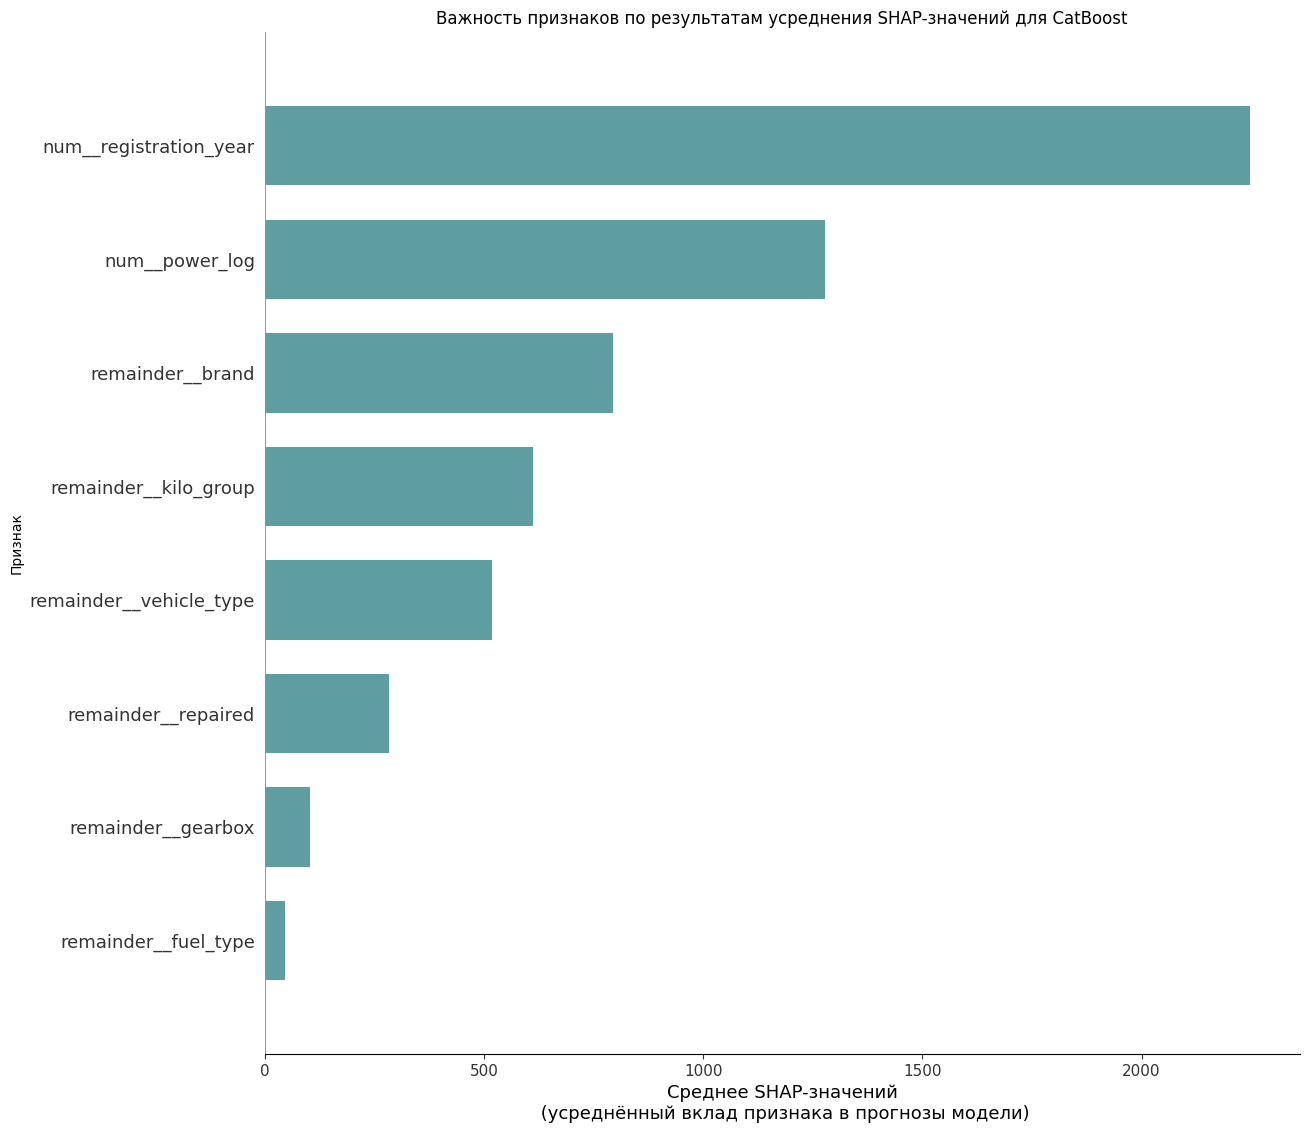

In [139]:
shap.summary_plot(shap_values_catboost, 
                  features=X_valid_transformed_catboost,  
                  feature_names=feature_names_catboost,
                  show=False,
                  plot_type='bar', 
                  plot_size=(13, 11),
                  color='cadetblue')

fig = plt.gcf()
ax = plt.gca()   

ax.set_xlabel('Среднее SHAP-значений\n (усреднённый вклад признака в прогнозы модели)')
ax.set_ylabel('Признак')
ax.set_title('Важность признаков по результатам усреднения SHAP-значений для CatBoost');

Наиболее важными оказались количественные признаки - год регистрации автомобиля и логарифмированное значение мощности. Наименее важный признак - тип топлива (ранее мы уже высказывали мысли на этот счёт, ввиду того, что 98% записей имеют одно и то же значение)

Также посмотрим на влияние признаков на каждое предсказание модели

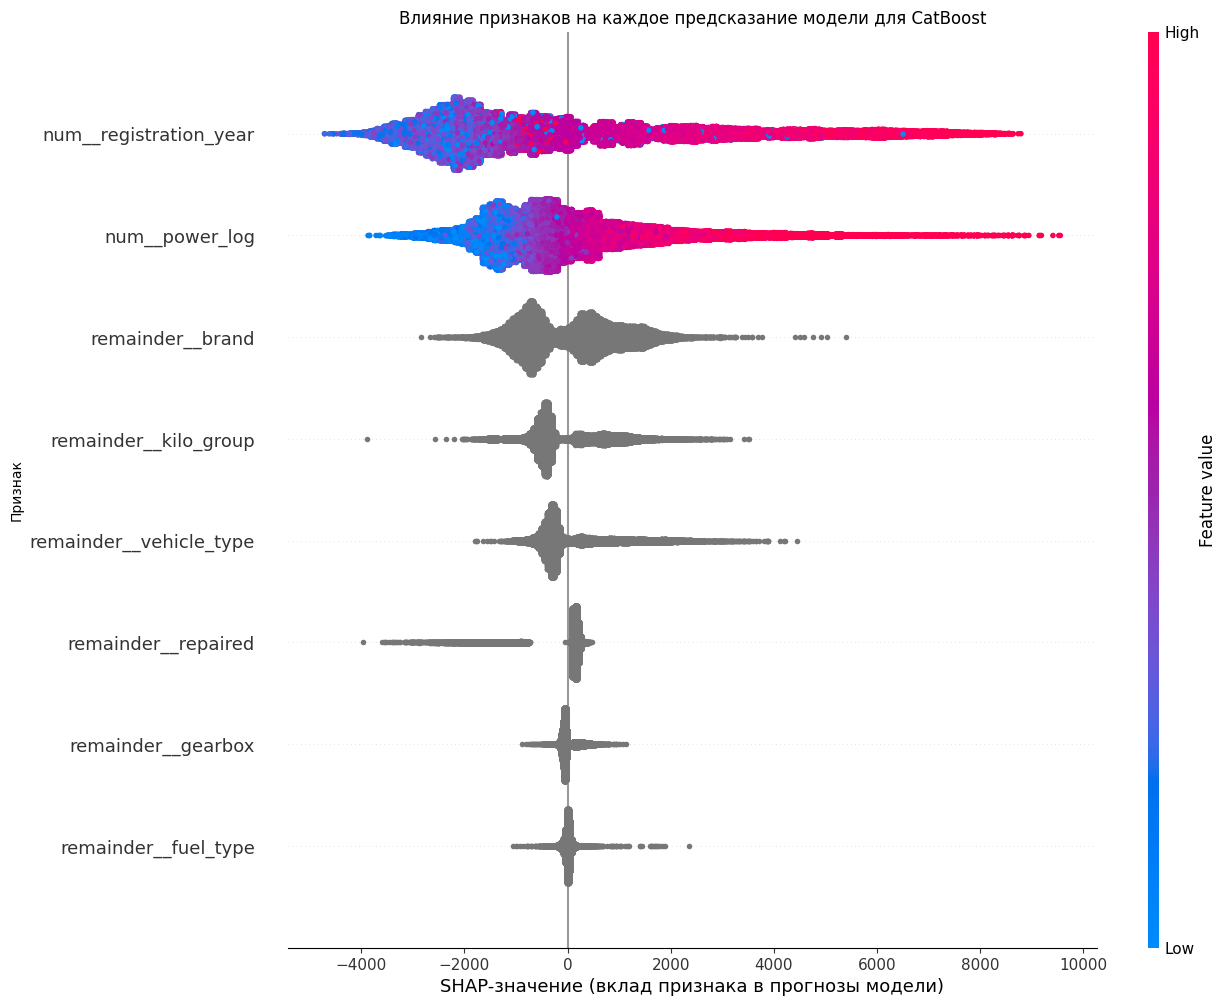

In [140]:
shap.summary_plot(shap_values_catboost, 
                  features=X_valid_transformed_catboost,  
                  feature_names=feature_names_catboost,
                  show=False, 
                  plot_size=(13, 10))
fig = plt.gcf()
ax = plt.gca()   

ax.set_xlabel('SHAP-значение (вклад признака в прогнозы модели)')
ax.set_ylabel('Признак')
ax.set_title('Влияние признаков на каждое предсказание модели для CatBoost')

plt.show()

Более высокие значения года регистрации автомобиля и логарифмированного значения мощности усиливают уверенность модели в прогнозировании более высокой стоимости автомобиля

####  XGBoost

In [141]:
#берём лучшие гиперпараметры
best_params_xgb = study_xgb.best_params


#пересобираем пайплайн
best_model_xgb = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('regressor', XGBRegressor(**best_params_xgb,
                               verbosity=0,
                               random_state=123))
])

#обучаем модель
best_model_xgb.fit(X_train, y_train)

#подготовка данных
X_train_transformed_xgb = best_model_xgb[:-1].transform(X_train)  
X_valid_transformed_xgb = best_model_xgb[:-1].transform(X_valid)

#получаем названия преобразованных признаков
feature_names_xgb = best_model_xgb[:-1].get_feature_names_out()

#достаём лучшую модель
best_xgb = best_model_xgb[-1]

# создаём explainer
explainer_xgb = shap.TreeExplainer(best_xgb)

#shap values для валидации
shap_values_xgb = explainer_xgb.shap_values(X_valid_transformed_xgb)

Посмотрим на важность признаков на основании усреднённых SHAP-значений

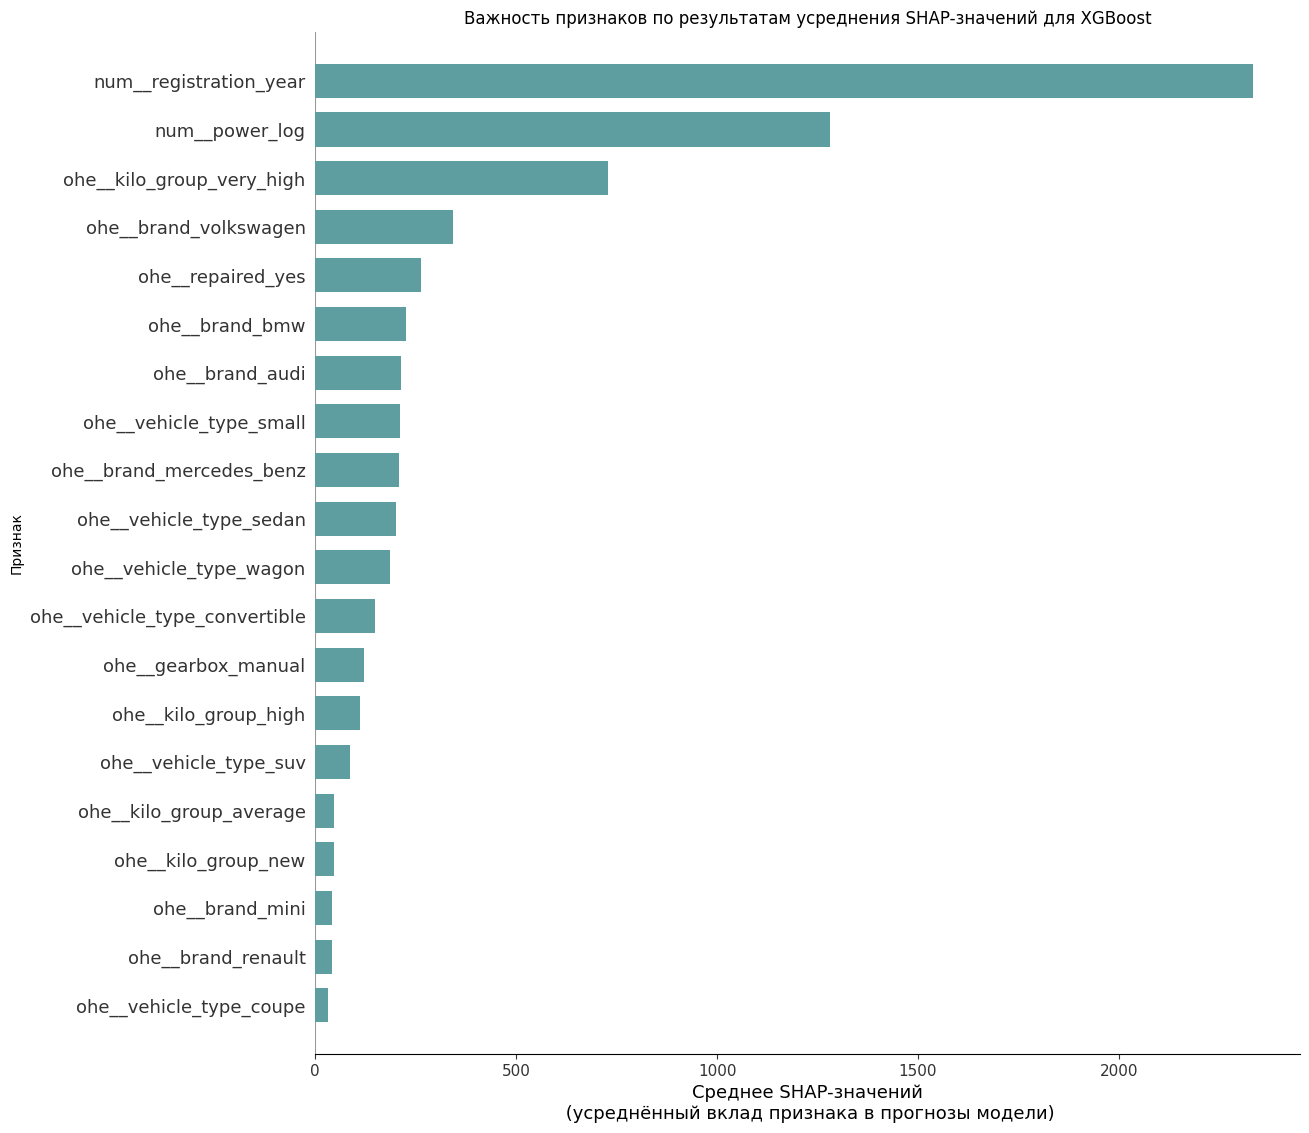

In [142]:
shap.summary_plot(shap_values_xgb, 
                  features=X_valid_transformed_xgb,  
                  feature_names=feature_names_xgb,
                  show=False,
                  plot_type='bar', 
                  plot_size=(13, 11),
                  color='cadetblue')

fig = plt.gcf()
ax = plt.gca()   

ax.set_xlabel('Среднее SHAP-значений\n (усреднённый вклад признака в прогнозы модели)')
ax.set_ylabel('Признак')
ax.set_title('Важность признаков по результатам усреднения SHAP-значений для XGBoost');

Наиболее важными также оказались количественные признаки - год регистрации автомобиля и логарифмированное значение мощности. Наименее важный признак - тип топлива, даже не отображается в итоговой таблице.

Также посмотрим на влияние признаков на каждое предсказание модели

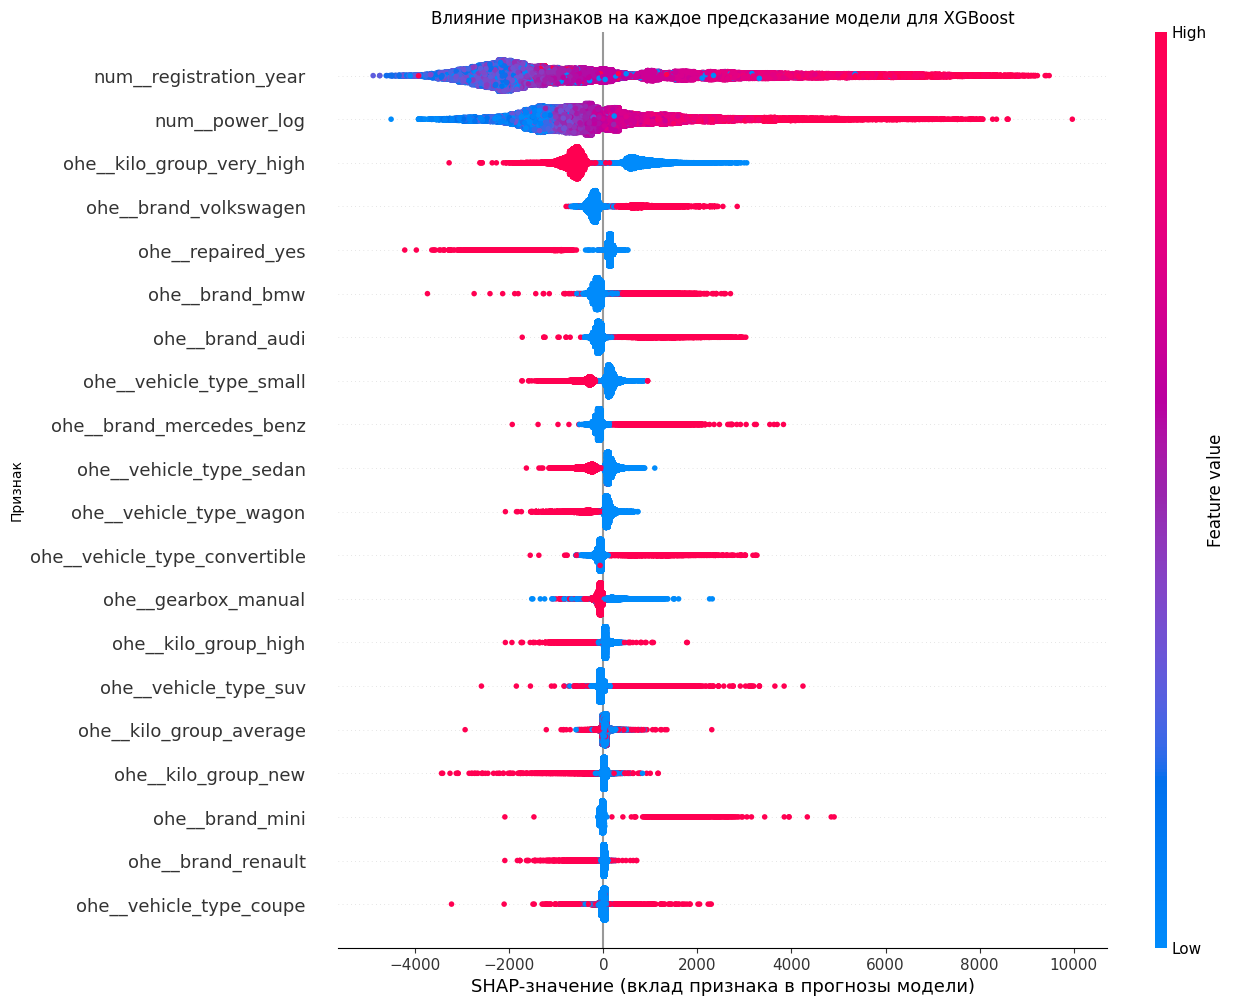

In [143]:
shap.summary_plot(shap_values_xgb, 
                  features=X_valid_transformed_xgb,  
                  feature_names=feature_names_xgb,
                  show=False, 
                  plot_size=(13, 10))
fig = plt.gcf()
ax = plt.gca()   

ax.set_xlabel('SHAP-значение (вклад признака в прогнозы модели)')
ax.set_ylabel('Признак')
ax.set_title('Влияние признаков на каждое предсказание модели для XGBoost')

plt.show()

Ситуация аналогична той, что мы наблюдали для CatBoost

#### LightGBM

In [144]:
#берём лучшие гиперпараметры
best_params_lgbm = study_lgbm.best_params


#пересобираем пайплайн
best_model_lgbm = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('regressor', LGBMRegressor(**best_params_lgbm,
                                verbose=-1,
                                random_state=123))
])

#обучаем модель
best_model_lgbm.fit(X_train, y_train)

#подготовка данных
X_train_transformed_lgbm = best_model_lgbm[:-1].transform(X_train)  
X_valid_transformed_lgbm = best_model_lgbm[:-1].transform(X_valid)

#получаем названия преобразованных признаков
feature_names_lgbm = best_model_lgbm[:-1].get_feature_names_out()

#достаём лучшую модель
best_lgbm = best_model_lgbm[-1]

# создаём explainer
explainer_lgbm = shap.TreeExplainer(best_lgbm)

#shap values для валидации
shap_values_lgbm = explainer_lgbm.shap_values(X_valid_transformed_lgbm)

Посмотрим на важность признаков на основании усреднённых SHAP-значений

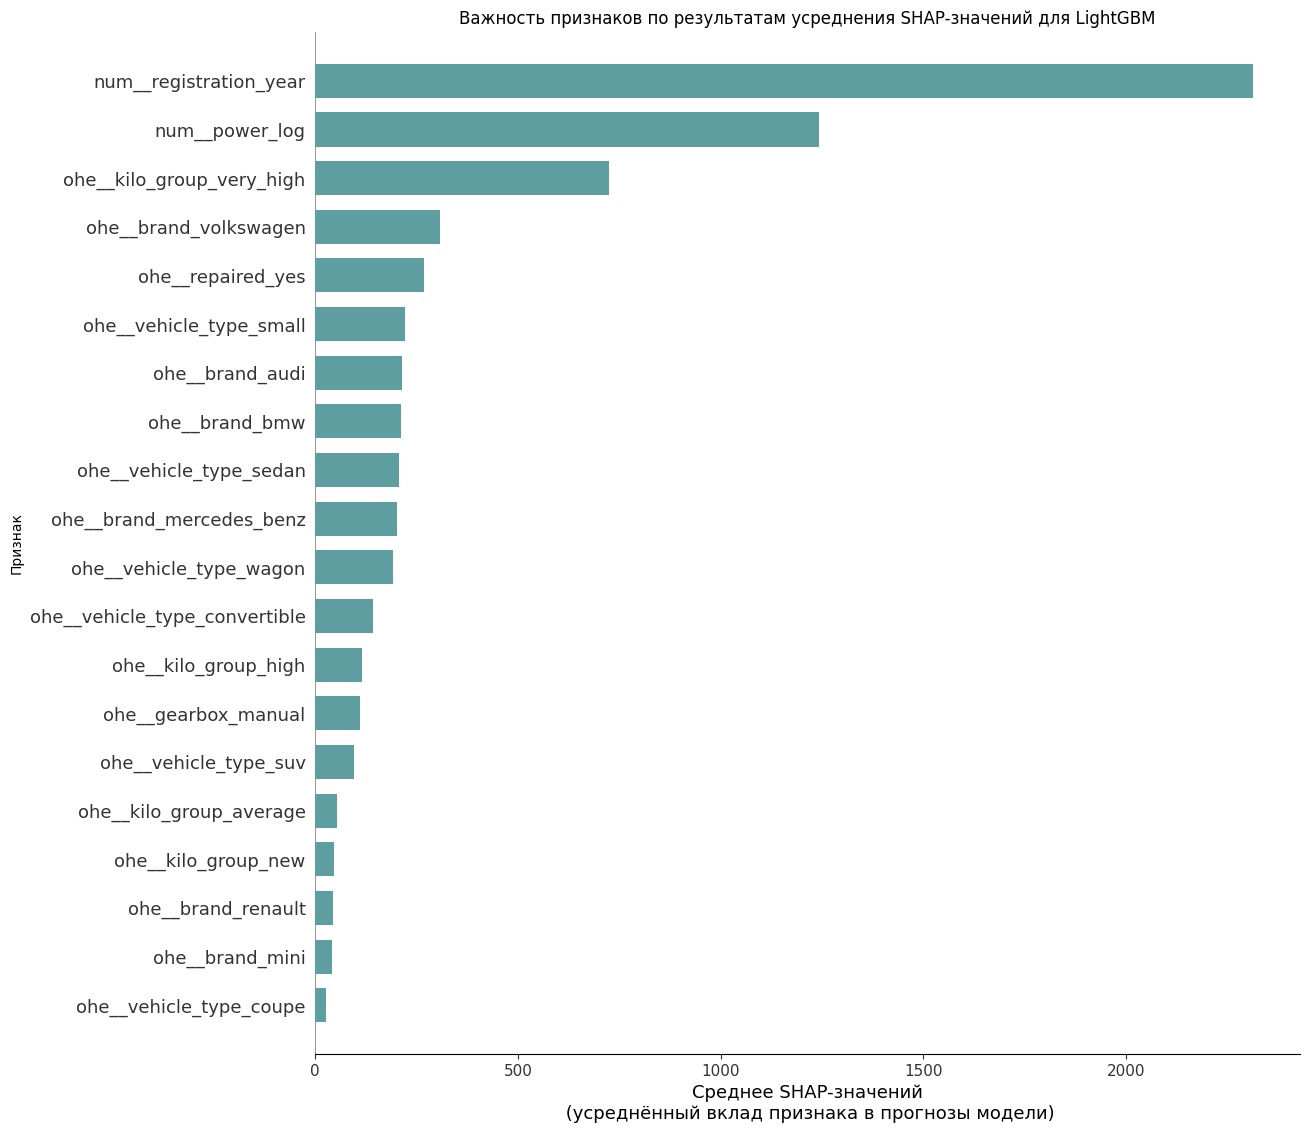

In [145]:
shap.summary_plot(shap_values_lgbm, 
                  features=X_valid_transformed_lgbm,  
                  feature_names=feature_names_lgbm,
                  show=False,
                  plot_type='bar', 
                  plot_size=(13, 11),
                  color='cadetblue')

fig = plt.gcf()
ax = plt.gca()   

ax.set_xlabel('Среднее SHAP-значений\n (усреднённый вклад признака в прогнозы модели)')
ax.set_ylabel('Признак')
ax.set_title('Важность признаков по результатам усреднения SHAP-значений для LightGBM');

Наиболее важными также оказались количественные признаки - год регистрации автомобиля и логарифмированное значение мощности. Наименее важный признак - тип топлива, не отображается в итоговой таблице

Также посмотрим на влияние признаков на каждое предсказание модели

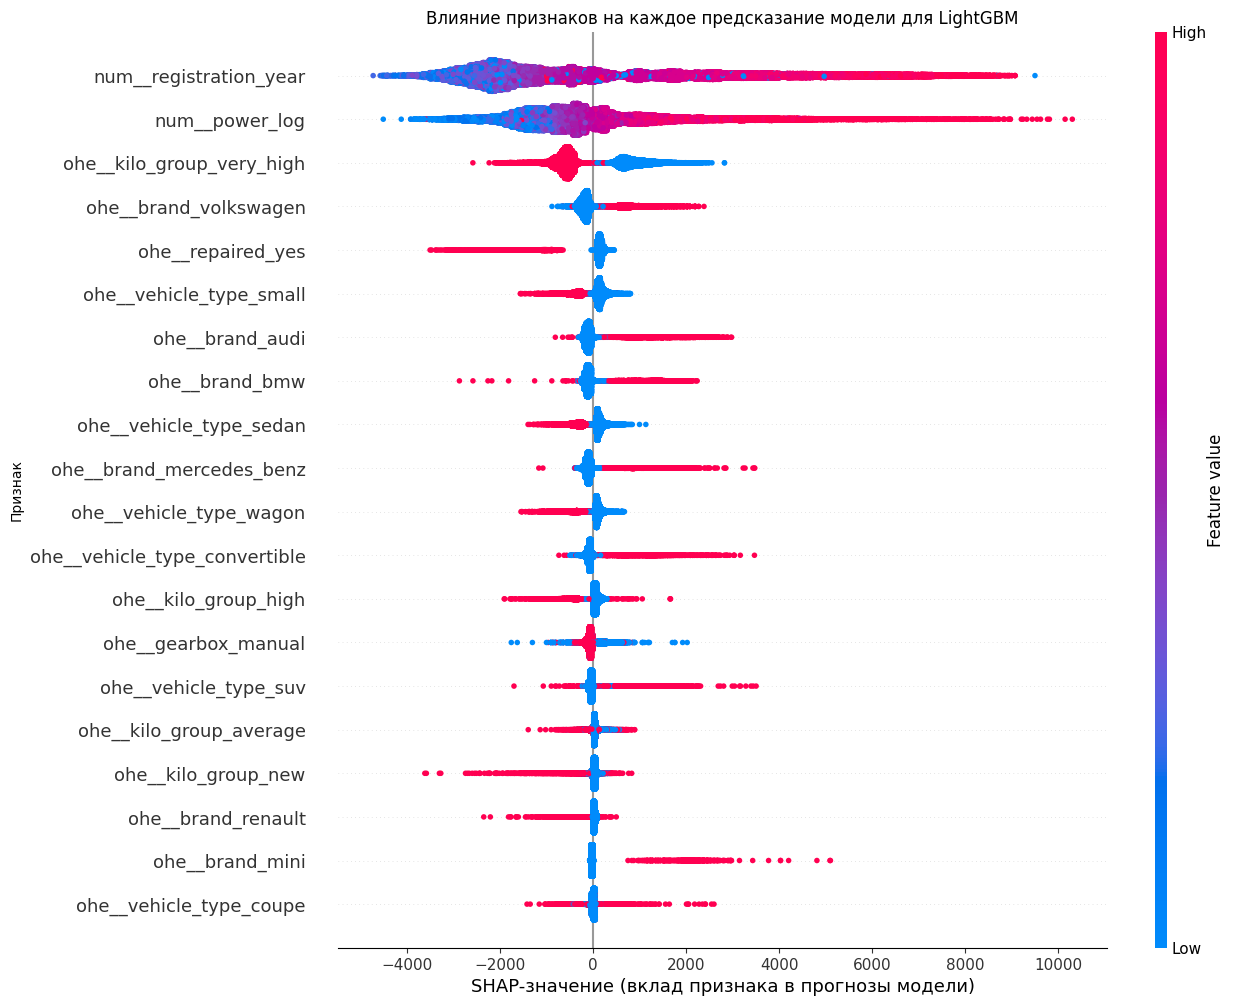

In [146]:
shap.summary_plot(shap_values_lgbm, 
                  features=X_valid_transformed_lgbm,  
                  feature_names=feature_names_lgbm,
                  show=False, 
                  plot_size=(13, 10))
fig = plt.gcf()
ax = plt.gca()   

ax.set_xlabel('SHAP-значение (вклад признака в прогнозы модели)')
ax.set_ylabel('Признак')
ax.set_title('Влияние признаков на каждое предсказание модели для LightGBM')

plt.show()

Ситуация очень похожа на ту, что мы наблюдали для CatBoost и XGBoost

#### kNN

Для модели kNN оценим важность признаков с помощью `permutation_importance`

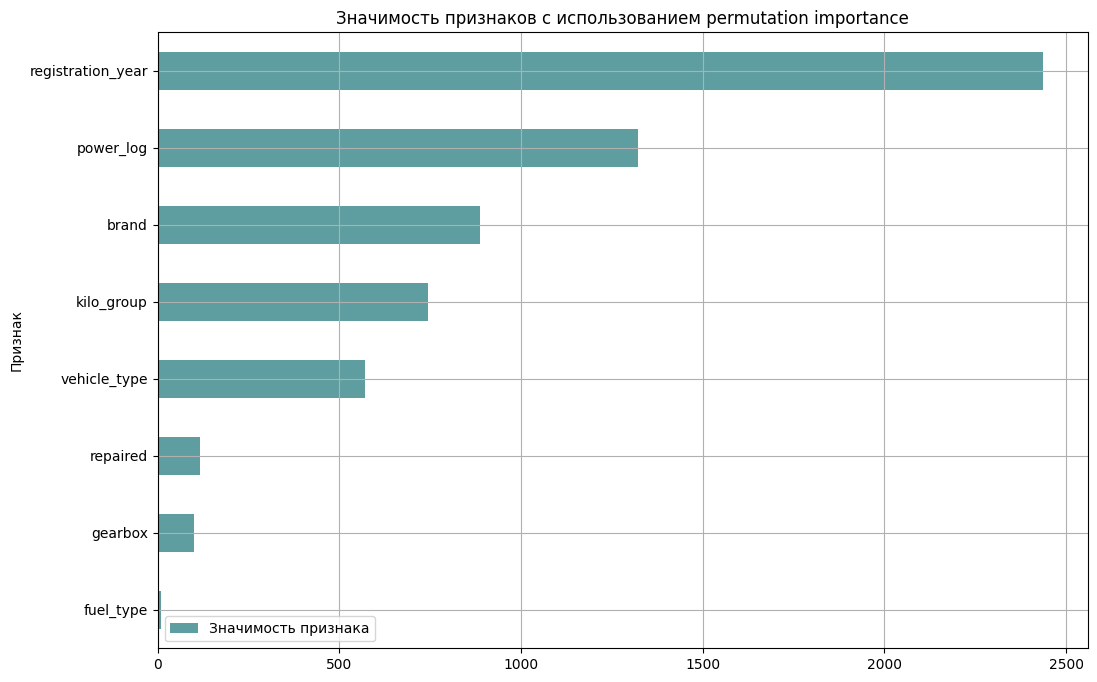

In [147]:
#берём лучшие гиперпараметры
best_params_knn = study_knn.best_params


#пересобираем пайплайн
best_model_knn = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('regressor', KNeighborsRegressor(**best_params_knn))
])

#обучаем модель
best_model_knn.fit(X_train, y_train)

#сохраним результат работы метода permutation_importance
result = permutation_importance(best_model_knn, 
                                X_valid, 
                                y_valid, 
                                scoring='neg_root_mean_squared_error',
                                random_state=123)

#получим значимости признаков и выведем их на горизонтальной столбчатой диаграмме
feature_importance_perm = pd.DataFrame({'Признак': X_train.columns, 
                                        'Значимость признака': result['importances_mean']})
feature_importance_perm = feature_importance_perm.sort_values(by='Значимость признака', ascending=True)
feature_importance_perm.plot(x='Признак', 
                             y='Значимость признака', 
                             kind='barh',
                             grid=True,
                             title='Значимость признаков с использованием permutation importance',
                             color='cadetblue');

Для модели kNN получили те же закономерности - признаки `registration_year` и `power_log` являются наиболее важными, признак `fuel_type` практически не оказывает никакого влияния

Таким образом, для 4 отобранных ранее моделей был проведён анализ важности признаков. Было установлено, что количественные признаки `registration_year` и `power_log` оказывают наибольшее влияние на предсказания модели. Из категориальных признаков наибольшее влияние оказывают признаки `brand` и `kilo_group`. Наименее важным оказывается признак `fuel_type`. Далее на кросс-валидации попробуем обучить модели без этого признака.

### Углублённый анализ выбранных моделей

На этом этапе с помощью кросс-валидации более глубоко изучим отобранные ранее модели, поскольку на предыдущем этапе результаты предсказаний могли быть обусловлены особенностями разбиения на выборки и не быть полностью релевантными для всех данных.

Создадим пайплайн. 

В качестве метрики была выбрана `RMSE`. Исходные данные были разделены на признаковое описание и целевую переменную, впоследствии - на тренировочную и тестовую выборку.

Исходные признаки были разделены на категориальные номинальные (`cat_cols`) и количественные (`num_cols`). Категориальные признаки предобработаем с помощью `OneHotEncoder` (номинальные признаки) с заполнением пропусков с помощью `SimpleImputer`. Для модели `CatBoostRegressor` категориальные признаки обрабатывать не будем, передадим напрямую в модель. Для количественных признаков используем масштабирование с помощью `StandardScaler`.

Будем более глубоко исследовать 4 отобранные ранее регрессионные модели с перебором нескольких гиперпараметров:

* *KNeighborsRegressor*. Расширим диапазон количества ближайших соседей;
* *LGBMRegressor, CatBoostRegressor, XGBoostRegressor*. Для данных моделей уменьшим шаг перебора количества решающих деревьев, а также добавим перебор доли объектов для построения каждого дерева и контроль сложности деревьев;

Оптимизацию гиперпараметров будем проводить с помощью `OptunaSearchCV`. Для каждой модели индивидуально подберём количество итераций ввиду различной скорости обучения и предсказания. Качество моделей определим по метрике `RMSE` с усреднением на кросс-валидации. Лучшую модель определим на основании оптимума по трём предложенным заказчиком параметрам - значение метрики, время обучения, время предсказания. Лучшая модель затем будет использовать для получения предсказаний на тестовой выборке

Разобьём данные на тренировочную и тестовую выборки, также удалим признак `fuel_type` как неинформативный

In [148]:
X = autos_fin.drop(['price', 'fuel_type'], axis=1)
y = autos_fin['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

#проверим корректность разбиения на выборки
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((191890, 7), (63964, 7), (191890,), (63964,))

Разбиение на выборки произведено успешно. Создадим группы признаков в соответствии с их типами данными

In [149]:
num_cols = list(X.select_dtypes(include=['int32', 'float64']))
cat_cols = list(X.select_dtypes(exclude=['int32', 'float64']))
num_cols, cat_cols

(['registration_year', 'power_log'],
 ['vehicle_type', 'gearbox', 'brand', 'repaired', 'kilo_group'])

In [150]:
#создаём пайплайн для подготовки признаков из списка cat_cols: 
#заполнение пропусков модой и OHE-кодирование
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

#создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_cols),
     ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

#создаём пайплайн для подготовки данных для CatBoost
data_preprocessor_catboost = ColumnTransformer(
    [('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)


#создадим списки с названиями моделей, метриками на тренировочных данных,
#затраченным на обучение и предсказание временем,
#а также суммарным временем оптимизации
fin_models_list = []
fin_metrics_list = []
fin_full_time_list = []
fin_fit_time_list = []
fin_predict_time_list = []

#### kNN

In [151]:
#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', KNeighborsRegressor())
    ]
)

param_grid = {

    #словарь для модели KNeighborsRegressor()
    'models__n_neighbors' : distributions.IntDistribution(1, 30),
    'models__weights': distributions.CategoricalDistribution(['uniform', 'distance'])
              
}

# запускаем таймер
start = time.time()
        

#объявляем класс OptunaSearchCV
oscv_regr_knn = optuna.integration.OptunaSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_trials=20,
    random_state=123
)
#объявляем перебор гиперпараметров
oscv_regr_knn.fit(X_train, y_train)

# считаем общее время с учётом перебора гиперпараметров
fin_full_time_list.append(time.time() - start)

#проверяем работу модели на кросс-валидации
print('Лучшая модель и её параметры:\n\n', oscv_regr_knn.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', abs(oscv_regr_knn.best_score_))

fin_models_list.append('kNN')
fin_metrics_list.append(abs(oscv_regr_knn.best_score_))

#оценим время обучения лучшей модели на тренировочной выборке
best_model_knn = oscv_regr_knn.best_estimator_

start = time.time()
best_model_knn.fit(X_train, y_train)
fin_fit_time_list.append(time.time() - start)

#оценим время предсказания лучшей модели на тренировочной выборке

start = time.time()
best_model_knn.predict(X_train)
fin_predict_time_list.append(time.time() - start)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8268\2104203615.py:22: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv_regr_knn = optuna.integration.OptunaSearchCV(
[I 2025-09-13 16:35:20,957] A new study created in memory with name: no-name-34e2424e-4ffa-495e-9fa6-d7cc461f6373
[I 2025-09-13 16:35:55,986] Trial 0 finished with value: -1980.642775858462 and parameters: {'models__n_neighbors': 22, 'models__weights': 'uniform'}. Best is trial 0 with value: -1980.642775858462.
[I 2025-09-13 16:36:31,262] Trial 1 finished with value: -1977.371678924626 and parameters: {'models__n_neighbors': 21, 'models__weights': 'uniform'}. Best is trial 1 with value: -1977.371678924626.
[I 2025-09-13 16:37:06,686] Trial 2 finished with value: -1948.8813156001063 and parameters: {'models__n_neighbors': 12, 'models__weights': 'uniform'}. Best is trial 2 with value: -1948.8813156001063.
[I 2025-09-13 16:37:42,238] Trial 3 finished with

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'brand', 'repaired',
                                                   'kilo_group']),
                       

#### LightGBM

In [152]:
#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LGBMRegressor(verbosity=-1,
                                 random_state=123))
    ]
)

param_grid = {

    #словарь для модели LGBMRegressor()
    'models__max_depth' : distributions.IntDistribution(2, 10),
    'models__learning_rate': distributions.FloatDistribution(1e-3, 1, log=True),
    'models__n_estimators': distributions.IntDistribution(100, 900, step=100),
    'models__subsample': distributions.FloatDistribution(0.5, 1, step=0.1)
                 
}

# запускаем таймер
start = time.time()
        

#объявляем класс OptunaSearchCV
oscv_regr_lgbm = optuna.integration.OptunaSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_trials=20,
    random_state=123
)
#объявляем перебор гиперпараметров
oscv_regr_lgbm.fit(X_train, y_train)

# считаем общее время с учётом перебора гиперпараметров
fin_full_time_list.append(time.time() - start)

#проверяем работу модели на кросс-валидации
print('Лучшая модель и её параметры:\n\n', oscv_regr_lgbm.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', abs(oscv_regr_lgbm.best_score_))

fin_models_list.append('LightGBM')
fin_metrics_list.append(abs(oscv_regr_lgbm.best_score_))

#оценим время обучения лучшей модели на тренировочной выборке
best_model_lgbm = oscv_regr_lgbm.best_estimator_

start = time.time()
best_model_lgbm.fit(X_train, y_train)
fin_fit_time_list.append(time.time() - start)

#оценим время предсказания лучшей модели на тренировочной выборке
start = time.time()
best_model_lgbm.predict(X_train)
fin_predict_time_list.append(time.time() - start)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8268\3147321633.py:25: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv_regr_lgbm = optuna.integration.OptunaSearchCV(
[I 2025-09-13 16:47:57,813] A new study created in memory with name: no-name-2256353a-9fad-40aa-9078-5c09e02b11d5
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\e

C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-13 16:48:51,247] Trial 6 finished with value: -1804.0288715204472 and parameters: {'models__max_depth': 9, 'models__learning_rate': 0.604773024075789, 'models__n

C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-13 16:49:27,772] Trial 12 finished with value: -1938.9207767069117 and parameters: {'models__max_depth': 2, 'models__learning_rate': 0.18727341936258823, 'models__n_estimators': 500, 'models__subsample': 0.5}. Best is trial 11 with value: -1782.4742564117037.
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X d

C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted w

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'brand', 'repaired',
                                                   'kilo_group']),
                       

C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


#### XGBoost

In [153]:
#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', XGBRegressor(verbosity=0,
                                random_state=123))
    ]
)

param_grid = {

    #словарь для модели XGBRegressor()
    'models__max_depth' : distributions.IntDistribution(2, 10),
    'models__learning_rate': distributions.FloatDistribution(1e-3, 1, log=True),
    'models__n_estimators': distributions.IntDistribution(100, 900, step=100),
    'models__subsample': distributions.FloatDistribution(0.5, 1, step=0.1),
    'models__min_child_weight': distributions.IntDistribution(1, 9, step=2)
                 
}

# запускаем таймер
start = time.time()
        

#объявляем класс OptunaSearchCV
oscv_regr_xgb = optuna.integration.OptunaSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_trials=20,
    random_state=123
)
#объявляем перебор гиперпараметров
oscv_regr_xgb.fit(X_train, y_train)

# считаем общее время с учётом перебора гиперпараметров
fin_full_time_list.append(time.time() - start)

#проверяем работу модели на кросс-валидации
print('Лучшая модель и её параметры:\n\n', oscv_regr_xgb.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', abs(oscv_regr_xgb.best_score_))

fin_models_list.append('XGBoost')
fin_metrics_list.append(abs(oscv_regr_xgb.best_score_))

#оценим время обучения лучшей модели на тренировочной выборке
best_model_xgb = oscv_regr_xgb.best_estimator_

start = time.time()
best_model_xgb.fit(X_train, y_train)
fin_fit_time_list.append(time.time() - start)

#оценим время предсказания лучшей модели на тренировочной выборке
start = time.time()
best_model_xgb.predict(X_train)
fin_predict_time_list.append(time.time() - start)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8268\55472769.py:26: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv_regr_xgb = optuna.integration.OptunaSearchCV(
[I 2025-09-13 16:50:23,388] A new study created in memory with name: no-name-09ec6dce-433b-44ea-8a72-82178764c2a1
[I 2025-09-13 16:50:33,838] Trial 0 finished with value: -1787.076025390625 and parameters: {'models__max_depth': 8, 'models__learning_rate': 0.05906411193342848, 'models__n_estimators': 300, 'models__subsample': 0.9, 'models__min_child_weight': 9}. Best is trial 0 with value: -1787.076025390625.
[I 2025-09-13 16:50:48,248] Trial 1 finished with value: -1929.148828125 and parameters: {'models__max_depth': 5, 'models__learning_rate': 0.013038249663265021, 'models__n_estimators': 600, 'models__subsample': 0.7, 'models__min_child_weight': 7}. Best is trial 0 with value: -1787.076025390625.
[I 2025-09-13 16:51:15,575] Trial 2 finished with value:

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'brand', 'repaired',
                                                   'kilo_group']),
                       

#### CatBoost

In [154]:
# получаем индексы категориальных признаков после трансформации
cat_feature_indices = list(range(len(num_cols), len(num_cols) + len(cat_cols)))

In [155]:
#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor_catboost),
        ('models', CatBoostRegressor(verbose=0,
                                     random_state=123))
    ]
)



param_grid = {

    #словарь для модели CatBoostRegressor()
    'models__depth' : distributions.IntDistribution(2, 10),
    'models__learning_rate': distributions.FloatDistribution(1e-3, 1, log=True),
    'models__iterations': distributions.IntDistribution(100, 900, step=100),
    'models__subsample': distributions.FloatDistribution(0.5, 1, step=0.1),
    'models__min_data_in_leaf': distributions.IntDistribution(1, 9, step=2)
                 
}

# запускаем таймер
start = time.time()
        

#объявляем класс OptunaSearchCV
oscv_regr_catboost = optuna.integration.OptunaSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_trials=20,
    random_state=123
)
#объявляем перебор гиперпараметров
oscv_regr_catboost.fit(X_train, y_train, models__cat_features=cat_feature_indices)

# считаем общее время с учётом перебора гиперпараметров
fin_full_time_list.append(time.time() - start)

#проверяем работу модели на кросс-валидации
print('Лучшая модель и её параметры:\n\n', oscv_regr_catboost.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', abs(oscv_regr_catboost.best_score_))

fin_models_list.append('CatBoost')
fin_metrics_list.append(abs(oscv_regr_catboost.best_score_))

#оценим время обучения лучшей модели на тренировочной выборке
best_model_catboost = oscv_regr_catboost.best_estimator_

start = time.time()
best_model_catboost.fit(X_train, y_train, models__cat_features=cat_feature_indices)
fin_fit_time_list.append(time.time() - start)

#оценим время предсказания лучшей модели на тренировочной выборке
start = time.time()
best_model_catboost.predict(X_train)
fin_predict_time_list.append(time.time() - start)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8268\3379020362.py:28: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv_regr_catboost = optuna.integration.OptunaSearchCV(
[I 2025-09-13 16:54:41,866] A new study created in memory with name: no-name-97f0d6fe-3357-4f5c-abea-27ae793d8c62
[I 2025-09-13 16:56:46,087] Trial 0 finished with value: -1829.8479343051818 and parameters: {'models__depth': 8, 'models__learning_rate': 0.05906411193342848, 'models__iterations': 300, 'models__subsample': 0.9, 'models__min_data_in_leaf': 9}. Best is trial 0 with value: -1829.8479343051818.
[I 2025-09-13 16:59:21,614] Trial 1 finished with value: -1971.1592692033075 and parameters: {'models__depth': 5, 'models__learning_rate': 0.013038249663265021, 'models__iterations': 600, 'models__subsample': 0.7, 'models__min_data_in_leaf': 7}. Best is trial 0 with value: -1829.8479343051818.
[I 2025-09-13 17:04:30,086] Trial 2 finished with valu

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['registration_year',
                                                   'power_log'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x000001BD31C9B2B0>)])
Метрика лучшей модели на кросс-валидации: 1757.9903995086966


Наконец, посмотрим на итоговые результаты для каждой модели

In [156]:
metrics_regr_fin = pd.DataFrame({
    'model': fin_models_list,
    'RMSE': np.array(fin_metrics_list),
    'full_time': fin_full_time_list,
    'fitting_time': fin_fit_time_list,
    'prediction_time': fin_predict_time_list
})
metrics_regr_fin.sort_values(by='RMSE')

,model,RMSE,full_time,fitting_time,prediction_time
3,CatBoost,1757.990400,4676.768229,102.527180,0.665000
1,LightGBM,1765.789364,143.089347,1.412132,1.032641
2,XGBoost,1767.548560,255.424104,2.370425,0.616826
0,kNN,1932.728504,714.785042,0.398000,41.651631


Отметим, что по значению метрики три модели на основе градиентного бустинга показали близкие результаты с небольшим преимуществом у `CatBoost`. Модель `kNN`, хоть и уступила им, всё равно уверенно превзошла требования заказчика по качеству метрики (`RMSE < 2500`) и могла бы быть фаворитом, если бы критерием заказчика была простота и понятность модели.

Вернёмся к бустинговым моделям. Времена предсказаний моделей также близки с некоторым преимуществом у `XGBoost`. А вот на времени обучения уже явно заметны различия - `CatBoost` обучается в десятки раз дольше, чем две других модели.
В итоге в качестве лучшей модели выберем `XGBoost`: наиболее сбалансированная модель по трём предложенным критериям - качество предсказания, время обучения модели и время предсказания модели. Стоит отметить, что также можно было выбрать `LightGBM` - чуть большее время предсказания, зато меньшее время обучения

Проверим качество лучшей модели на тестовых данных

In [157]:
y_pred_fin = oscv_regr_xgb.predict(X_test)
print(f'Метрика RMSE на тестовой выборке для лучшей модели XGBoost: {root_mean_squared_error(y_test, y_pred_fin)}')

Метрика RMSE на тестовой выборке для лучшей модели XGBoost: 1741.7095947265625


Получили значение `RMSE = 1741.71`, что даже чуть лучше, чем на кросс-валидации - модель, возможно, слегка недоучилась (малое количество итераций оптимизации), но, главное, отработала корректно и с высоким качеством; более того, качество модели не пострадало даже вопреки наличию большого числа неявных дубликатов, что мы отмечали ранее

Таким образом, на данном этапе мы непосредственно занимались обучением моделей.

На первом этапе мы подготовили данные для обучения, подготовили пайплайны для моделей. Обучили 10 регрессионных моделей с перебором гиперпараметров и оптимизацией с помощью `optuna`. 

На основании метрики качества `RMSE` и суммарного времени работы были отобраны 4 лучшие модели - `kNN`, `CatBoost`, `XGBoost` и `LightGBM`. Для этих моделей был проведён анализ важности признаков. Было установлено, что наибольшую важность имеют количественные признаки - год регистрации автомобиля и мощность. Наименее важный признак - тип топлива - был удалён как неинформативный.

Затем для 4 отобранных моделей была осуществлена оптимизация расширенного числа гиперпараметров с помощью `OptunaSearchCV`. Качество обученнных моделей оценивалось по метрике `RMSE`, времени обучения и предсказания. Наиболее оптимальной по данным параметрам оказалась модель `XGBoost`, качество которой было оценено на тестовых данных - модель показала даже более высокое значение метрики в сравнении с кросс-валидацией

## Итоговые выводы

**Ход исследования:**

* *загрузка данных*

Необходимые библиотеки были импортированы, данные загружены, названия столбцов приведены к змеиному регистру.

* *предобработка данных*

Была проведена базовая предобработка данных. Отмечено наличие признаков с пропущенными значениями. Были удалены явные дубликаты. Изменены типы данных на более корректные/подходящие. Отмечены наиболее выделяющиеся особенности признакового описания. 

* *исследовательский анализ данных*

Проведён анализ признакового описания и таргета. Удалены малоинформативные признаки `date_crawled`, `registration_month`, `date_created`, `number_of_pictures`, `postal_code`  и `last_seen`. На основе признаков `registration_year` и `kilometer` созданы категориальные признаки `reg_year_group` и `kilo_group` соответственно. Проведена логарифмическая трансформация признака `power` с образованием признака `power_log`. Удалены полные дубликаты и аномальные значения. Пропущенные значения заполнены наиболее оптимальным образом в зависимости от распределения признака и типа данных. Отмечена смещённость распределения таргета вправо ввиду наличия большого числа дорогостоящих автомобилей. Отмечена неравномерность распределения значений внутри категорий для категориальных признаков

* *корреляционный анализ данных*

Анализ линейных зависимостей количественных признаков  показал, что наибольшую корреляцию с таргетом имеет признак `registration_year`. Расширенный анализ зависимостей всех признаков с помощью корреляций `phik` показал наибольшую корреляцию с таргетом признаков `registration_year`, `model`, `reg_year_group`, `power_log`, `kilo_group`. Из коррелирующих между собой признаков  для обучения моделей были выбраны `registration_year`, `power_log` и `kilo_group`. Кроме того, был исключён признак `model` ввиду мультиколлинеарности с двумя другими признаками. Для наиболее дорогих автомобилей отметим усиление корреляций для признаков `power_log` и `kilo_group`

* *подготовка данных и исследование моделей*

Были подготовлены данные для обучения, а также пайплайны для моделей. Были обучены 10 регрессионных моделей с перебором гиперпараметров и оптимизацией с помощью `optuna`. 

На основании метрики качества `RMSE` и суммарного времени работы были отобраны 4 лучшие модели - `kNN`, `CatBoost`, `XGBoost` и `LightGBM`.


* *анализ важности признаков*

Для 4 отобранных ранее моделей был проведён анализ важности признаков. Было установлено, что количественные признаки `registration_year` и `power_log` оказывают наибольшее влияние на предсказания модели. Из категориальных признаков наибольшее влияние оказывают признаки `brand` и `kilo_group`. Наименее важным оказывается признак `fuel_type`. 


* *финальное обучение моделей и проверка качества лучшей модели на тестовой выборке*

Для 4 отобранных моделей была осуществлена оптимизация расширенного числа гиперпараметров с помощью `OptunaSearchCV`. Качество обученнных моделей оценивалось по метрике `RMSE`, времени обучения и предсказания. Наиболее оптимальной по данным параметрам оказалась модель `XGBoost`, качество которой было оценено на тестовых данных - модель показала даже более высокое качество в сравнении с кросс-валидацией, удовлетворяющее требованиям заказчика (`1767.55` на кросс-валидации и `1741.71` на тестовых данных)  